In [7]:
import gym
import numpy as np
import pickle
from model import Tabular, SoftmaxPolicy, EgreedyPolicy, \
    SigmoidTermination, IntraOptionQLearning, IntraOptionActionQLearning, \
    TerminationGradient, IntraOptionGradient
import random

discount = 0.99
lr_term = 0.25
lr_intra = 0.25
lr_critic = 0.5
epsilon = 0.01
temperature = 0.10
noptions = 4
nsteps = 1000

nruns = 1
nepisodes = 20000
verbose = True

rng = np.random.RandomState(1234)
env = gym.make('Fourrooms-v0')

#possible_next_goals = [68, 69, 70, 71, 72, 78, 79, 80, 81, 82, 88,
#                       89, 90, 91, 92, 93, 99, 100, 101, 102, 103]
#possible_next_goals = [0]
#goals = [62, 0, 40, 95, 62, 3, 97, 50] 
goals = [62] + random.sample(range(104), 19)

history = np.zeros((nruns, nepisodes, 2))

for run in range(nruns):
    features = Tabular(env.observation_space.n)
    nfeatures, nactions = len(features), env.action_space.n

    # The intra-option policies are linear-softmax functions
    option_policies = [SoftmaxPolicy(rng, nfeatures, nactions, temperature)
                       for _ in range(noptions)]
    
    # The termination function are linear-sigmoid functions
    option_terminations = [SigmoidTermination(rng, nfeatures) 
                           for _ in range(noptions)]

    # E-greedy policy over options
    policy_over_options = EgreedyPolicy(rng, nfeatures, noptions, epsilon)
    #policy_over_options = SoftmaxPolicy(rng, nfeatures, noptions, 0.001)

    # Different choices are possible for the critic. Here we learn an
    # option-value function and use the estimator for the values upon arrival
    critic = IntraOptionQLearning(discount, lr_critic, 
                                  option_terminations, policy_over_options.weights)

    # Learn Qomega separately
    action_weights = np.zeros((nfeatures, noptions, nactions))
    action_critic = IntraOptionActionQLearning(discount, lr_critic, 
                                               option_terminations, 
                                               action_weights, critic)

    # Improvement of the termination functions based on gradients
    termination_improvement = TerminationGradient(option_terminations, 
                                                  critic, lr_term)

    # Intra-option gradient improvement with critic estimator
    intraoption_improvement = IntraOptionGradient(option_policies, 
                                                  lr_intra)

    
    change_count = 1
    for episode in xrange(nepisodes):       
        if episode == 1000 * change_count:
            # Save current option policies and termination functions
            pickle.dump(option_policies, 
                        open("save/policies_{}.p".format(change_count), "wb"))
            pickle.dump(option_terminations, 
                        open("save/terminations_{}.p".format(change_count), "wb"))    
            pickle.dump(policy_over_options, 
                        open("save/mainpolicy_{}.p".format(change_count), "wb"))
            # Change goal
            #env.goal = rng.choice(possible_next_goals)
            env.goal = goals[change_count]
            print("New goal : ", env.tocell[env.goal])
            change_count += 1
            
        phi = features(env.reset())
        option = policy_over_options.sample(phi)
        action = option_policies[option].sample(phi)
        critic.start(phi, option)
        action_critic.start(phi, option, action)

        cumreward = 0.
        duration = 1
        option_switches = 0
        avgduration = 0.
        
        for step in range(nsteps):
            observation, reward, done, _ = env.step(action)
            phi = features(observation)

            # Termination might occur upon entering the new state
            if option_terminations[option].sample(phi):
                option = policy_over_options.sample(phi)
                option_switches += 1
                avgduration += (1. / option_switches) * \
                    (duration - avgduration)
                duration = 1

            action = option_policies[option].sample(phi)

            # Critic update
            update_target = critic.update(phi, option, reward, done)
            action_critic.update(phi, option, action, reward, done)

            if isinstance(option_policies[option], SoftmaxPolicy):
                # Intra-option policy update
                critic_feedback = action_critic.value(phi, option, action)
                critic_feedback -= critic.value(phi, option)
                intraoption_improvement.update(phi, option, action, 
                                               critic_feedback)
                # Termination update
                termination_improvement.update(phi, option)

            cumreward += reward
            duration += 1
            if done:
                break

        history[run, episode, 0] = step
        history[run, episode, 1] = avgduration
        if verbose:
            print('Run {} episode {} steps {} cumreward {} avg. duration \
                {} switches {}'.format(run, episode, step, cumreward, 
                                       avgduration, option_switches))
            
    pickle.dump(option_policies, 
                open("save/policies_{}.p".format(change_count), "wb"))
    pickle.dump(option_terminations, 
                open("save/terminations_{}.p".format(change_count), "wb"))    
    pickle.dump(policy_over_options, 
                open("save/mainpolicy_{}.p".format(change_count), "wb"))

[2017-11-15 12:47:55,238] Making new env: Fourrooms-v0


Run 0 episode 0 steps 101 cumreward 1.0 avg. duration                 3.12765957447 switches 47
Run 0 episode 1 steps 145 cumreward 1.0 avg. duration                 2.89473684211 switches 76
Run 0 episode 2 steps 999 cumreward 0.0 avg. duration                 3.05979381443 switches 485
Run 0 episode 3 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 4 steps 77 cumreward 1.0 avg. duration                 2.7619047619 switches 42
Run 0 episode 5 steps 116 cumreward 1.0 avg. duration                 3.05357142857 switches 56
Run 0 episode 6 steps 211 cumreward 1.0 avg. duration                 2.97196261682 switches 107
Run 0 episode 7 steps 523 cumreward 1.0 avg. duration                 2.89492753623 switches 276
Run 0 episode 8 steps 10 cumreward 1.0 avg. duration                 2.0 switches 7
Run 0 episode 9 steps 705 cumreward 1.0 avg. duration                 3.08579881657 switches 338
Run 0 episode 10 steps 43 cumreward 1.0 avg. duration          

Run 0 episode 105 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 106 steps 8 cumreward 1.0 avg. duration                 3.66666666667 switches 3
Run 0 episode 107 steps 26 cumreward 1.0 avg. duration                 2.5625 switches 16
Run 0 episode 108 steps 5 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 109 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 110 steps 21 cumreward 1.0 avg. duration                 2.75 switches 12
Run 0 episode 111 steps 19 cumreward 1.0 avg. duration                 3.375 switches 8
Run 0 episode 112 steps 6 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 113 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 114 steps 5 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 115 steps 8 cumreward 1.0 avg. duration                 2.75 switches 4
Run

Run 0 episode 225 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 226 steps 10 cumreward 1.0 avg. duration                 2.125 switches 8
Run 0 episode 227 steps 8 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 228 steps 4 cumreward 1.0 avg. duration                 1.8 switches 5
Run 0 episode 229 steps 4 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 230 steps 39 cumreward 1.0 avg. duration                 3.0 switches 19
Run 0 episode 231 steps 27 cumreward 1.0 avg. duration                 3.27272727273 switches 11
Run 0 episode 232 steps 10 cumreward 1.0 avg. duration                 3.0 switches 5
Run 0 episode 233 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 234 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 235 steps 13 cumreward 1.0 avg. duration                 3.0 switches 6
Run 0 episode 236 steps 7 cumrewa

Run 0 episode 324 steps 9 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 325 steps 19 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 326 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 327 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 328 steps 6 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 329 steps 23 cumreward 1.0 avg. duration                 2.75 switches 12
Run 0 episode 330 steps 39 cumreward 1.0 avg. duration                 3.05263157895 switches 19
Run 0 episode 331 steps 12 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 332 steps 1 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 333 steps 21 cumreward 1.0 avg. duration                 3.11111111111 switches 9
Run 0 episode 334 steps 13 cumreward 1.0 avg. duration                 3.5 switches 4
Run 

Run 0 episode 419 steps 31 cumreward 1.0 avg. duration                 3.14285714286 switches 14
Run 0 episode 420 steps 8 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 421 steps 18 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 422 steps 7 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 423 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 424 steps 4 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 425 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 426 steps 16 cumreward 1.0 avg. duration                 3.66666666667 switches 6
Run 0 episode 427 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 428 steps 12 cumreward 1.0 avg. duration                 3.0 switches 6
Run 0 episode 429 steps 6 cumreward 1.0 avg. duration                 4.0 switches 2
Run 0 episode 430

Run 0 episode 525 steps 30 cumreward 1.0 avg. duration                 3.07142857143 switches 14
Run 0 episode 526 steps 20 cumreward 1.0 avg. duration                 2.53846153846 switches 13
Run 0 episode 527 steps 12 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 528 steps 10 cumreward 1.0 avg. duration                 3.0 switches 5
Run 0 episode 529 steps 28 cumreward 1.0 avg. duration                 2.90909090909 switches 11
Run 0 episode 530 steps 12 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 531 steps 10 cumreward 1.0 avg. duration                 3.0 switches 4
Run 0 episode 532 steps 4 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 533 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 534 steps 2 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 535 steps 10 cumreward 1.0 avg. duration                 3.5 switches 4
Run 

Run 0 episode 626 steps 416 cumreward 1.0 avg. duration                 3.05445544554 switches 202
Run 0 episode 627 steps 16 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 628 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 629 steps 12 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 630 steps 13 cumreward 1.0 avg. duration                 3.6 switches 5
Run 0 episode 631 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 632 steps 13 cumreward 1.0 avg. duration                 2.44444444444 switches 9
Run 0 episode 633 steps 14 cumreward 1.0 avg. duration                 2.3 switches 10
Run 0 episode 634 steps 7 cumreward 1.0 avg. duration                 3.5 switches 2
Run 0 episode 635 steps 2 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 636 steps 15 cumreward 1.0 avg. duration                 3.33333333333 swi

Run 0 episode 738 steps 6 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 739 steps 18 cumreward 1.0 avg. duration                 3.0 switches 8
Run 0 episode 740 steps 9 cumreward 1.0 avg. duration                 3.25 switches 4
Run 0 episode 741 steps 3 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 742 steps 8 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 743 steps 9 cumreward 1.0 avg. duration                 3.66666666667 switches 3
Run 0 episode 744 steps 11 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 745 steps 7 cumreward 1.0 avg. duration                 3.33333333333 switches 3
Run 0 episode 746 steps 10 cumreward 1.0 avg. duration                 3.0 switches 5
Run 0 episode 747 steps 6 cumreward 1.0 avg. duration                 3.5 switches 2
Run 0 episode 748 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 749 st

Run 0 episode 848 steps 10 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 849 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 850 steps 53 cumreward 1.0 avg. duration                 3.03846153846 switches 26
Run 0 episode 851 steps 12 cumreward 1.0 avg. duration                 3.4 switches 5
Run 0 episode 852 steps 3 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 853 steps 9 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 854 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 855 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 856 steps 13 cumreward 1.0 avg. duration                 2.3 switches 10
Run 0 episode 857 steps 3 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 858 steps 12 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 859 

Run 0 episode 973 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 974 steps 2 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 975 steps 10 cumreward 1.0 avg. duration                 2.8 switches 5
Run 0 episode 976 steps 6 cumreward 1.0 avg. duration                 4.0 switches 2
Run 0 episode 977 steps 1 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 978 steps 12 cumreward 1.0 avg. duration                 3.4 switches 5
Run 0 episode 979 steps 5 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 980 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 981 steps 13 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 982 steps 7 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 983 steps 16 cumreward 1.0 avg. duration                 2.77777777778 switches 9
Run 0 episode 984 ste

Run 0 episode 1063 steps 162 cumreward 1.0 avg. duration                 2.9156626506 switches 83
Run 0 episode 1064 steps 5 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 1065 steps 20 cumreward 1.0 avg. duration                 2.53846153846 switches 13
Run 0 episode 1066 steps 133 cumreward 1.0 avg. duration                 2.98484848485 switches 66
Run 0 episode 1067 steps 164 cumreward 1.0 avg. duration                 2.88505747126 switches 87
Run 0 episode 1068 steps 266 cumreward 1.0 avg. duration                 2.69677419355 switches 155
Run 0 episode 1069 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 1070 steps 17 cumreward 1.0 avg. duration                 2.45454545455 switches 11
Run 0 episode 1071 steps 12 cumreward 1.0 avg. duration                 2.09090909091 switches 11
Run 0 episode 1072 steps 48 cumreward 1.0 avg. duration                 2.6 switches 30
Run 0 episode 1073 steps 112 cumreward 1.0 avg. du

Run 0 episode 1152 steps 94 cumreward 1.0 avg. duration                 2.82 switches 50
Run 0 episode 1153 steps 8 cumreward 1.0 avg. duration                 3.0 switches 3
Run 0 episode 1154 steps 56 cumreward 1.0 avg. duration                 2.8064516129 switches 31
Run 0 episode 1155 steps 165 cumreward 1.0 avg. duration                 2.58653846154 switches 104
Run 0 episode 1156 steps 92 cumreward 1.0 avg. duration                 2.91666666667 switches 48
Run 0 episode 1157 steps 106 cumreward 1.0 avg. duration                 2.73770491803 switches 61
Run 0 episode 1158 steps 67 cumreward 1.0 avg. duration                 3.03125 switches 32
Run 0 episode 1159 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 1160 steps 388 cumreward 1.0 avg. duration                 2.63291139241 switches 237
Run 0 episode 1161 steps 3 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 1162 steps 290 cumreward 1.0 avg. duration           

Run 0 episode 1241 steps 129 cumreward 1.0 avg. duration                 2.7027027027 switches 74
Run 0 episode 1242 steps 13 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 1243 steps 7 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 1244 steps 73 cumreward 1.0 avg. duration                 2.6976744186 switches 43
Run 0 episode 1245 steps 8 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 1246 steps 5 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 1247 steps 99 cumreward 1.0 avg. duration                 3.10638297872 switches 47
Run 0 episode 1248 steps 12 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 1249 steps 88 cumreward 1.0 avg. duration                 2.76 switches 50
Run 0 episode 1250 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 1251 steps 175 cumreward 1.0 avg. duration                 2.63551401869 s

Run 0 episode 1329 steps 64 cumreward 1.0 avg. duration                 2.72972972973 switches 37
Run 0 episode 1330 steps 136 cumreward 1.0 avg. duration                 2.65853658537 switches 82
Run 0 episode 1331 steps 87 cumreward 1.0 avg. duration                 2.89130434783 switches 46
Run 0 episode 1332 steps 32 cumreward 1.0 avg. duration                 2.77777777778 switches 18
Run 0 episode 1333 steps 4 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 1334 steps 70 cumreward 1.0 avg. duration                 2.62790697674 switches 43
Run 0 episode 1335 steps 4 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 1336 steps 78 cumreward 1.0 avg. duration                 2.85714285714 switches 42
Run 0 episode 1337 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 1338 steps 3 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1339 steps 1 cumreward 1.0 avg. duration   

Run 0 episode 1418 steps 55 cumreward 1.0 avg. duration                 2.6875 switches 32
Run 0 episode 1419 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1420 steps 9 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 1421 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 1422 steps 81 cumreward 1.0 avg. duration                 2.90476190476 switches 42
Run 0 episode 1423 steps 76 cumreward 1.0 avg. duration                 2.7619047619 switches 42
Run 0 episode 1424 steps 77 cumreward 1.0 avg. duration                 2.85365853659 switches 41
Run 0 episode 1425 steps 108 cumreward 1.0 avg. duration                 2.71428571429 switches 63
Run 0 episode 1426 steps 191 cumreward 1.0 avg. duration                 2.50393700787 switches 127
Run 0 episode 1427 steps 80 cumreward 1.0 avg. duration                 2.73913043478 switches 46
Run 0 episode 1428 steps 54 cumreward 1.0 avg. duration      

Run 0 episode 1509 steps 398 cumreward 1.0 avg. duration                 2.64730290456 switches 241
Run 0 episode 1510 steps 18 cumreward 1.0 avg. duration                 2.30769230769 switches 13
Run 0 episode 1511 steps 89 cumreward 1.0 avg. duration                 2.74509803922 switches 51
Run 0 episode 1512 steps 113 cumreward 1.0 avg. duration                 2.56944444444 switches 72
Run 0 episode 1513 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1514 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 1515 steps 81 cumreward 1.0 avg. duration                 2.76086956522 switches 46
Run 0 episode 1516 steps 146 cumreward 1.0 avg. duration                 2.84810126582 switches 79
Run 0 episode 1517 steps 183 cumreward 1.0 avg. duration                 2.77669902913 switches 103
Run 0 episode 1518 steps 48 cumreward 1.0 avg. duration                 2.65517241379 switches 29
Run 0 episode 1519 steps 41

Run 0 episode 1596 steps 353 cumreward 1.0 avg. duration                 2.74752475248 switches 202
Run 0 episode 1597 steps 110 cumreward 1.0 avg. duration                 2.52777777778 switches 72
Run 0 episode 1598 steps 74 cumreward 1.0 avg. duration                 2.48 switches 50
Run 0 episode 1599 steps 161 cumreward 1.0 avg. duration                 2.75 switches 92
Run 0 episode 1600 steps 44 cumreward 1.0 avg. duration                 2.38709677419 switches 31
Run 0 episode 1601 steps 1 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 1602 steps 34 cumreward 1.0 avg. duration                 2.54545454545 switches 22
Run 0 episode 1603 steps 94 cumreward 1.0 avg. duration                 3.0 switches 47
Run 0 episode 1604 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 1605 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 1606 steps 227 cumreward 1.0 avg. duration                 2.71969

Run 0 episode 1689 steps 106 cumreward 1.0 avg. duration                 2.60606060606 switches 66
Run 0 episode 1690 steps 67 cumreward 1.0 avg. duration                 2.28846153846 switches 52
Run 0 episode 1691 steps 67 cumreward 1.0 avg. duration                 2.91428571429 switches 35
Run 0 episode 1692 steps 59 cumreward 1.0 avg. duration                 3.36 switches 25
Run 0 episode 1693 steps 73 cumreward 1.0 avg. duration                 2.46 switches 50
Run 0 episode 1694 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 1695 steps 34 cumreward 1.0 avg. duration                 2.47826086957 switches 23
Run 0 episode 1696 steps 12 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 1697 steps 187 cumreward 1.0 avg. duration                 2.68468468468 switches 111
Run 0 episode 1698 steps 32 cumreward 1.0 avg. duration                 2.70588235294 switches 17
Run 0 episode 1699 steps 41 cumreward 1.0 avg. duration  

Run 0 episode 1780 steps 29 cumreward 1.0 avg. duration                 2.61111111111 switches 18
Run 0 episode 1781 steps 115 cumreward 1.0 avg. duration                 2.61971830986 switches 71
Run 0 episode 1782 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 1783 steps 82 cumreward 1.0 avg. duration                 2.54716981132 switches 53
Run 0 episode 1784 steps 23 cumreward 1.0 avg. duration                 2.27777777778 switches 18
Run 0 episode 1785 steps 203 cumreward 1.0 avg. duration                 2.52631578947 switches 133
Run 0 episode 1786 steps 6 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 1787 steps 65 cumreward 1.0 avg. duration                 2.66666666667 switches 39
Run 0 episode 1788 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 1789 steps 22 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 1790 steps 43 cumreward 1.0 a

Run 0 episode 1868 steps 146 cumreward 1.0 avg. duration                 2.75903614458 switches 83
Run 0 episode 1869 steps 246 cumreward 1.0 avg. duration                 2.64 switches 150
Run 0 episode 1870 steps 36 cumreward 1.0 avg. duration                 2.5 switches 24
Run 0 episode 1871 steps 2 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 1872 steps 58 cumreward 1.0 avg. duration                 2.45 switches 40
Run 0 episode 1873 steps 3 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 1874 steps 30 cumreward 1.0 avg. duration                 2.76470588235 switches 17
Run 0 episode 1875 steps 75 cumreward 1.0 avg. duration                 2.5625 switches 48
Run 0 episode 1876 steps 3 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 1877 steps 111 cumreward 1.0 avg. duration                 2.58571428571 switches 70
Run 0 episode 1878 steps 56 cumreward 1.0 avg. duration                 2.75 switches 3

Run 0 episode 1964 steps 269 cumreward 1.0 avg. duration                 2.50279329609 switches 179
Run 0 episode 1965 steps 32 cumreward 1.0 avg. duration                 2.6 switches 20
Run 0 episode 1966 steps 3 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 1967 steps 3 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 1968 steps 83 cumreward 1.0 avg. duration                 2.31746031746 switches 63
Run 0 episode 1969 steps 54 cumreward 1.0 avg. duration                 2.55882352941 switches 34
Run 0 episode 1970 steps 55 cumreward 1.0 avg. duration                 2.35 switches 40
Run 0 episode 1971 steps 87 cumreward 1.0 avg. duration                 2.55357142857 switches 56
Run 0 episode 1972 steps 89 cumreward 1.0 avg. duration                 2.36923076923 switches 65
Run 0 episode 1973 steps 84 cumreward 1.0 avg. duration                 2.47368421053 switches 57
Run 0 episode 1974 steps 1 cumreward 1.0 avg. duration       

Run 0 episode 2056 steps 22 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 2057 steps 78 cumreward 1.0 avg. duration                 2.5 switches 52
Run 0 episode 2058 steps 107 cumreward 1.0 avg. duration                 2.62121212121 switches 66
Run 0 episode 2059 steps 68 cumreward 1.0 avg. duration                 2.51111111111 switches 45
Run 0 episode 2060 steps 31 cumreward 1.0 avg. duration                 2.61111111111 switches 18
Run 0 episode 2061 steps 14 cumreward 1.0 avg. duration                 3.33333333333 switches 6
Run 0 episode 2062 steps 73 cumreward 1.0 avg. duration                 2.52083333333 switches 48
Run 0 episode 2063 steps 35 cumreward 1.0 avg. duration                 3.1875 switches 16
Run 0 episode 2064 steps 8 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 2065 steps 42 cumreward 1.0 avg. duration                 2.53846153846 switches 26
Run 0 episode 2066 steps 14 cumreward 1.0 avg. du

Run 0 episode 2150 steps 93 cumreward 1.0 avg. duration                 2.48387096774 switches 62
Run 0 episode 2151 steps 14 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 2152 steps 17 cumreward 1.0 avg. duration                 3.125 switches 8
Run 0 episode 2153 steps 17 cumreward 1.0 avg. duration                 2.30769230769 switches 13
Run 0 episode 2154 steps 38 cumreward 1.0 avg. duration                 3.0 switches 18
Run 0 episode 2155 steps 49 cumreward 1.0 avg. duration                 2.62068965517 switches 29
Run 0 episode 2156 steps 28 cumreward 1.0 avg. duration                 2.47368421053 switches 19
Run 0 episode 2157 steps 59 cumreward 1.0 avg. duration                 2.68571428571 switches 35
Run 0 episode 2158 steps 30 cumreward 1.0 avg. duration                 2.76470588235 switches 17
Run 0 episode 2159 steps 54 cumreward 1.0 avg. duration                 2.60606060606 switches 33
Run 0 episode 2160 steps 75 cumreward 1.

Run 0 episode 2241 steps 109 cumreward 1.0 avg. duration                 2.69841269841 switches 63
Run 0 episode 2242 steps 46 cumreward 1.0 avg. duration                 2.7037037037 switches 27
Run 0 episode 2243 steps 98 cumreward 1.0 avg. duration                 2.66101694915 switches 59
Run 0 episode 2244 steps 7 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 2245 steps 21 cumreward 1.0 avg. duration                 2.58333333333 switches 12
Run 0 episode 2246 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 2247 steps 55 cumreward 1.0 avg. duration                 2.61764705882 switches 34
Run 0 episode 2248 steps 78 cumreward 1.0 avg. duration                 2.44444444444 switches 54
Run 0 episode 2249 steps 23 cumreward 1.0 avg. duration                 2.15 switches 20
Run 0 episode 2250 steps 121 cumreward 1.0 avg. duration                 2.4756097561 switches 82
Run 0 episode 2251 steps 22 cumreward 1.0 a

Run 0 episode 2332 steps 23 cumreward 1.0 avg. duration                 2.69230769231 switches 13
Run 0 episode 2333 steps 27 cumreward 1.0 avg. duration                 2.6875 switches 16
Run 0 episode 2334 steps 14 cumreward 1.0 avg. duration                 2.3 switches 10
Run 0 episode 2335 steps 9 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 2336 steps 20 cumreward 1.0 avg. duration                 3.11111111111 switches 9
Run 0 episode 2337 steps 19 cumreward 1.0 avg. duration                 2.1875 switches 16
Run 0 episode 2338 steps 17 cumreward 1.0 avg. duration                 2.77777777778 switches 9
Run 0 episode 2339 steps 23 cumreward 1.0 avg. duration                 2.57142857143 switches 14
Run 0 episode 2340 steps 14 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 2341 steps 4 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 2342 steps 3 cumreward 1.0 avg. duration                

Run 0 episode 2440 steps 18 cumreward 1.0 avg. duration                 2.38461538462 switches 13
Run 0 episode 2441 steps 17 cumreward 1.0 avg. duration                 3.125 switches 8
Run 0 episode 2442 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 2443 steps 20 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 2444 steps 8 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 2445 steps 13 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 2446 steps 11 cumreward 1.0 avg. duration                 2.375 switches 8
Run 0 episode 2447 steps 23 cumreward 1.0 avg. duration                 2.76923076923 switches 13
Run 0 episode 2448 steps 27 cumreward 1.0 avg. duration                 2.35 switches 20
Run 0 episode 2449 steps 31 cumreward 1.0 avg. duration                 2.31818181818 switches 22
Run 0 episode 2450 steps 15 cumreward 1.0 avg. duration                 

Run 0 episode 2539 steps 27 cumreward 1.0 avg. duration                 2.42105263158 switches 19
Run 0 episode 2540 steps 41 cumreward 1.0 avg. duration                 2.36666666667 switches 30
Run 0 episode 2541 steps 15 cumreward 1.0 avg. duration                 2.6 switches 5
Run 0 episode 2542 steps 70 cumreward 1.0 avg. duration                 2.55555555556 switches 45
Run 0 episode 2543 steps 67 cumreward 1.0 avg. duration                 2.88571428571 switches 35
Run 0 episode 2544 steps 31 cumreward 1.0 avg. duration                 2.63157894737 switches 19
Run 0 episode 2545 steps 15 cumreward 1.0 avg. duration                 2.55555555556 switches 9
Run 0 episode 2546 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 2547 steps 30 cumreward 1.0 avg. duration                 2.42857142857 switches 21
Run 0 episode 2548 steps 6 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 2549 steps 0 cumreward 1.0 avg. duration  

Run 0 episode 2631 steps 10 cumreward 1.0 avg. duration                 3.33333333333 switches 3
Run 0 episode 2632 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 2633 steps 7 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 2634 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 2635 steps 22 cumreward 1.0 avg. duration                 3.44444444444 switches 9
Run 0 episode 2636 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 2637 steps 6 cumreward 1.0 avg. duration                 3.0 switches 3
Run 0 episode 2638 steps 13 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 2639 steps 37 cumreward 1.0 avg. duration                 2.48 switches 25
Run 0 episode 2640 steps 15 cumreward 1.0 avg. duration                 2.66666666667 switches 9
Run 0 episode 2641 steps 19 cumreward 1.0 avg. duration                 2.63636363636 switche

Run 0 episode 2744 steps 11 cumreward 1.0 avg. duration                 2.375 switches 8
Run 0 episode 2745 steps 19 cumreward 1.0 avg. duration                 2.46153846154 switches 13
Run 0 episode 2746 steps 9 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 2747 steps 19 cumreward 1.0 avg. duration                 2.58333333333 switches 12
Run 0 episode 2748 steps 20 cumreward 1.0 avg. duration                 2.42857142857 switches 14
Run 0 episode 2749 steps 8 cumreward 1.0 avg. duration                 2.6 switches 5
Run 0 episode 2750 steps 5 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 2751 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 2752 steps 2 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 2753 steps 20 cumreward 1.0 avg. duration                 2.81818181818 switches 11
Run 0 episode 2754 steps 9 cumreward 1.0 avg. duration                 6.0 switches 1
Ru

Run 0 episode 2837 steps 21 cumreward 1.0 avg. duration                 2.5 switches 14
Run 0 episode 2838 steps 36 cumreward 1.0 avg. duration                 2.71428571429 switches 21
Run 0 episode 2839 steps 33 cumreward 1.0 avg. duration                 2.4347826087 switches 23
Run 0 episode 2840 steps 13 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 2841 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 2842 steps 9 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 2843 steps 3 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 2844 steps 26 cumreward 1.0 avg. duration                 2.26315789474 switches 19
Run 0 episode 2845 steps 51 cumreward 1.0 avg. duration                 2.78571428571 switches 28
Run 0 episode 2846 steps 23 cumreward 1.0 avg. duration                 2.53846153846 switches 13
Run 0 episode 2847 steps 5 cumreward 1.0 avg. duration    

Run 0 episode 2952 steps 24 cumreward 1.0 avg. duration                 3.18181818182 switches 11
Run 0 episode 2953 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 2954 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 2955 steps 10 cumreward 1.0 avg. duration                 3.0 switches 5
Run 0 episode 2956 steps 27 cumreward 1.0 avg. duration                 2.35 switches 20
Run 0 episode 2957 steps 7 cumreward 1.0 avg. duration                 4.0 switches 2
Run 0 episode 2958 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 2959 steps 26 cumreward 1.0 avg. duration                 2.44444444444 switches 18
Run 0 episode 2960 steps 8 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 2961 steps 12 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 2962 steps 31 cumreward 1.0 avg. duration                 2.92857142857 switches 14
Run

Run 0 episode 3045 steps 158 cumreward 1.0 avg. duration                 2.79545454545 switches 88
Run 0 episode 3046 steps 25 cumreward 1.0 avg. duration                 2.4375 switches 16
Run 0 episode 3047 steps 18 cumreward 1.0 avg. duration                 2.28571428571 switches 14
Run 0 episode 3048 steps 19 cumreward 1.0 avg. duration                 2.26666666667 switches 15
Run 0 episode 3049 steps 40 cumreward 1.0 avg. duration                 2.48148148148 switches 27
Run 0 episode 3050 steps 74 cumreward 1.0 avg. duration                 2.7619047619 switches 42
Run 0 episode 3051 steps 193 cumreward 1.0 avg. duration                 2.8380952381 switches 105
Run 0 episode 3052 steps 161 cumreward 1.0 avg. duration                 2.73913043478 switches 92
Run 0 episode 3053 steps 21 cumreward 1.0 avg. duration                 2.61538461538 switches 13
Run 0 episode 3054 steps 98 cumreward 1.0 avg. duration                 2.60655737705 switches 61
Run 0 episode 3055 steps 

Run 0 episode 3139 steps 45 cumreward 1.0 avg. duration                 2.8 switches 25
Run 0 episode 3140 steps 46 cumreward 1.0 avg. duration                 2.45161290323 switches 31
Run 0 episode 3141 steps 86 cumreward 1.0 avg. duration                 2.65384615385 switches 52
Run 0 episode 3142 steps 20 cumreward 1.0 avg. duration                 2.53846153846 switches 13
Run 0 episode 3143 steps 13 cumreward 1.0 avg. duration                 2.625 switches 8
Run 0 episode 3144 steps 52 cumreward 1.0 avg. duration                 2.54545454545 switches 33
Run 0 episode 3145 steps 57 cumreward 1.0 avg. duration                 2.58823529412 switches 34
Run 0 episode 3146 steps 10 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 3147 steps 22 cumreward 1.0 avg. duration                 2.69230769231 switches 13
Run 0 episode 3148 steps 4 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 3149 steps 181 cumreward 1.0 avg. dura

Run 0 episode 3233 steps 35 cumreward 1.0 avg. duration                 2.84210526316 switches 19
Run 0 episode 3234 steps 11 cumreward 1.0 avg. duration                 2.375 switches 8
Run 0 episode 3235 steps 6 cumreward 1.0 avg. duration                 1.85714285714 switches 7
Run 0 episode 3236 steps 43 cumreward 1.0 avg. duration                 2.86956521739 switches 23
Run 0 episode 3237 steps 56 cumreward 1.0 avg. duration                 2.55555555556 switches 36
Run 0 episode 3238 steps 34 cumreward 1.0 avg. duration                 2.41666666667 switches 24
Run 0 episode 3239 steps 44 cumreward 1.0 avg. duration                 2.57142857143 switches 28
Run 0 episode 3240 steps 78 cumreward 1.0 avg. duration                 2.73333333333 switches 45
Run 0 episode 3241 steps 26 cumreward 1.0 avg. duration                 2.44444444444 switches 18
Run 0 episode 3242 steps 31 cumreward 1.0 avg. duration                 2.63157894737 switches 19
Run 0 episode 3243 steps 19 cum

Run 0 episode 3321 steps 35 cumreward 1.0 avg. duration                 2.6 switches 20
Run 0 episode 3322 steps 1 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 3323 steps 61 cumreward 1.0 avg. duration                 2.5641025641 switches 39
Run 0 episode 3324 steps 22 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 3325 steps 21 cumreward 1.0 avg. duration                 2.23529411765 switches 17
Run 0 episode 3326 steps 369 cumreward 1.0 avg. duration                 2.48790322581 switches 248
Run 0 episode 3327 steps 301 cumreward 1.0 avg. duration                 2.5202020202 switches 198
Run 0 episode 3328 steps 38 cumreward 1.0 avg. duration                 2.40740740741 switches 27
Run 0 episode 3329 steps 68 cumreward 1.0 avg. duration                 2.41666666667 switches 48
Run 0 episode 3330 steps 21 cumreward 1.0 avg. duration                 2.23529411765 switches 17
Run 0 episode 3331 steps 106 cumreward 1

Run 0 episode 3409 steps 31 cumreward 1.0 avg. duration                 2.34782608696 switches 23
Run 0 episode 3410 steps 100 cumreward 1.0 avg. duration                 2.5625 switches 64
Run 0 episode 3411 steps 23 cumreward 1.0 avg. duration                 2.76923076923 switches 13
Run 0 episode 3412 steps 148 cumreward 1.0 avg. duration                 2.55789473684 switches 95
Run 0 episode 3413 steps 37 cumreward 1.0 avg. duration                 2.94117647059 switches 17
Run 0 episode 3414 steps 260 cumreward 1.0 avg. duration                 2.57575757576 switches 165
Run 0 episode 3415 steps 63 cumreward 1.0 avg. duration                 2.4 switches 45
Run 0 episode 3416 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 3417 steps 25 cumreward 1.0 avg. duration                 2.92307692308 switches 13
Run 0 episode 3418 steps 20 cumreward 1.0 avg. duration                 2.11111111111 switches 18
Run 0 episode 3419 steps 15 cumreward 1.0 avg

Run 0 episode 3495 steps 98 cumreward 1.0 avg. duration                 2.4 switches 70
Run 0 episode 3496 steps 47 cumreward 1.0 avg. duration                 2.30555555556 switches 36
Run 0 episode 3497 steps 32 cumreward 1.0 avg. duration                 2.6 switches 20
Run 0 episode 3498 steps 41 cumreward 1.0 avg. duration                 2.46428571429 switches 28
Run 0 episode 3499 steps 34 cumreward 1.0 avg. duration                 2.7 switches 20
Run 0 episode 3500 steps 15 cumreward 1.0 avg. duration                 2.5 switches 10
Run 0 episode 3501 steps 32 cumreward 1.0 avg. duration                 2.23076923077 switches 26
Run 0 episode 3502 steps 14 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 3503 steps 15 cumreward 1.0 avg. duration                 2.15384615385 switches 13
Run 0 episode 3504 steps 101 cumreward 1.0 avg. duration                 2.42253521127 switches 71
Run 0 episode 3505 steps 343 cumreward 1.0 avg. duration             

Run 0 episode 3587 steps 50 cumreward 1.0 avg. duration                 2.66666666667 switches 30
Run 0 episode 3588 steps 62 cumreward 1.0 avg. duration                 2.47619047619 switches 42
Run 0 episode 3589 steps 39 cumreward 1.0 avg. duration                 2.56 switches 25
Run 0 episode 3590 steps 51 cumreward 1.0 avg. duration                 2.225 switches 40
Run 0 episode 3591 steps 17 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 3592 steps 103 cumreward 1.0 avg. duration                 2.47142857143 switches 70
Run 0 episode 3593 steps 182 cumreward 1.0 avg. duration                 2.48760330579 switches 121
Run 0 episode 3594 steps 73 cumreward 1.0 avg. duration                 2.40384615385 switches 52
Run 0 episode 3595 steps 91 cumreward 1.0 avg. duration                 2.49180327869 switches 61
Run 0 episode 3596 steps 80 cumreward 1.0 avg. duration                 2.53846153846 switches 52
Run 0 episode 3597 steps 12 cumrew

Run 0 episode 3673 steps 46 cumreward 1.0 avg. duration                 2.15 switches 40
Run 0 episode 3674 steps 28 cumreward 1.0 avg. duration                 2.35 switches 20
Run 0 episode 3675 steps 213 cumreward 1.0 avg. duration                 2.38311688312 switches 154
Run 0 episode 3676 steps 140 cumreward 1.0 avg. duration                 2.34615384615 switches 104
Run 0 episode 3677 steps 23 cumreward 1.0 avg. duration                 2.4375 switches 16
Run 0 episode 3678 steps 41 cumreward 1.0 avg. duration                 2.32258064516 switches 31
Run 0 episode 3679 steps 255 cumreward 1.0 avg. duration                 2.37837837838 switches 185
Run 0 episode 3680 steps 194 cumreward 1.0 avg. duration                 2.4696969697 switches 132
Run 0 episode 3681 steps 44 cumreward 1.0 avg. duration                 2.51724137931 switches 29
Run 0 episode 3682 steps 106 cumreward 1.0 avg. duration                 2.29268292683 switches 82
Run 0 episode 3683 steps 79 cumreward

Run 0 episode 3761 steps 67 cumreward 1.0 avg. duration                 2.3137254902 switches 51
Run 0 episode 3762 steps 97 cumreward 1.0 avg. duration                 2.24358974359 switches 78
Run 0 episode 3763 steps 80 cumreward 1.0 avg. duration                 2.77777777778 switches 45
Run 0 episode 3764 steps 27 cumreward 1.0 avg. duration                 2.5 switches 18
Run 0 episode 3765 steps 7 cumreward 1.0 avg. duration                 2.0 switches 7
Run 0 episode 3766 steps 138 cumreward 1.0 avg. duration                 2.32692307692 switches 104
Run 0 episode 3767 steps 98 cumreward 1.0 avg. duration                 2.46268656716 switches 67
Run 0 episode 3768 steps 24 cumreward 1.0 avg. duration                 2.5 switches 16
Run 0 episode 3769 steps 221 cumreward 1.0 avg. duration                 2.48322147651 switches 149
Run 0 episode 3770 steps 216 cumreward 1.0 avg. duration                 2.43046357616 switches 151
Run 0 episode 3771 steps 132 cumreward 1.0 avg.

Run 0 episode 3849 steps 76 cumreward 1.0 avg. duration                 2.39622641509 switches 53
Run 0 episode 3850 steps 51 cumreward 1.0 avg. duration                 2.18604651163 switches 43
Run 0 episode 3851 steps 6 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 3852 steps 22 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 3853 steps 46 cumreward 1.0 avg. duration                 2.40625 switches 32
Run 0 episode 3854 steps 8 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 3855 steps 45 cumreward 1.0 avg. duration                 2.60714285714 switches 28
Run 0 episode 3856 steps 9 cumreward 1.0 avg. duration                 2.8 switches 5
Run 0 episode 3857 steps 24 cumreward 1.0 avg. duration                 2.64285714286 switches 14
Run 0 episode 3858 steps 18 cumreward 1.0 avg. duration                 2.8 switches 10
Run 0 episode 3859 steps 49 cumreward 1.0 avg. duration                

Run 0 episode 3937 steps 98 cumreward 1.0 avg. duration                 2.63333333333 switches 60
Run 0 episode 3938 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 3939 steps 111 cumreward 1.0 avg. duration                 2.3875 switches 80
Run 0 episode 3940 steps 57 cumreward 1.0 avg. duration                 2.54054054054 switches 37
Run 0 episode 3941 steps 67 cumreward 1.0 avg. duration                 2.39583333333 switches 48
Run 0 episode 3942 steps 13 cumreward 1.0 avg. duration                 2.625 switches 8
Run 0 episode 3943 steps 21 cumreward 1.0 avg. duration                 2.35714285714 switches 14
Run 0 episode 3944 steps 3 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 3945 steps 29 cumreward 1.0 avg. duration                 2.47368421053 switches 19
Run 0 episode 3946 steps 21 cumreward 1.0 avg. duration                 2.33333333333 switches 15
Run 0 episode 3947 steps 190 cumreward 1.0 avg. d

Run 0 episode 4024 steps 88 cumreward 1.0 avg. duration                 2.359375 switches 64
Run 0 episode 4025 steps 509 cumreward 1.0 avg. duration                 2.48830409357 switches 342
Run 0 episode 4026 steps 45 cumreward 1.0 avg. duration                 2.375 switches 32
Run 0 episode 4027 steps 59 cumreward 1.0 avg. duration                 2.45 switches 40
Run 0 episode 4028 steps 26 cumreward 1.0 avg. duration                 2.38888888889 switches 18
Run 0 episode 4029 steps 39 cumreward 1.0 avg. duration                 2.39285714286 switches 28
Run 0 episode 4030 steps 6 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 4031 steps 22 cumreward 1.0 avg. duration                 2.75 switches 12
Run 0 episode 4032 steps 18 cumreward 1.0 avg. duration                 2.21428571429 switches 14
Run 0 episode 4033 steps 39 cumreward 1.0 avg. duration                 2.31034482759 switches 29
Run 0 episode 4034 steps 1 cumreward 1.0 avg. duration       

Run 0 episode 4111 steps 80 cumreward 1.0 avg. duration                 2.43636363636 switches 55
Run 0 episode 4112 steps 130 cumreward 1.0 avg. duration                 2.3 switches 100
Run 0 episode 4113 steps 30 cumreward 1.0 avg. duration                 2.42857142857 switches 21
Run 0 episode 4114 steps 95 cumreward 1.0 avg. duration                 2.40298507463 switches 67
Run 0 episode 4115 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 4116 steps 35 cumreward 1.0 avg. duration                 2.41666666667 switches 24
Run 0 episode 4117 steps 23 cumreward 1.0 avg. duration                 2.27777777778 switches 18
Run 0 episode 4118 steps 28 cumreward 1.0 avg. duration                 2.55555555556 switches 18
Run 0 episode 4119 steps 18 cumreward 1.0 avg. duration                 2.33333333333 switches 12
Run 0 episode 4120 steps 48 cumreward 1.0 avg. duration                 2.5 switches 32
Run 0 episode 4121 steps 33 cumreward 1.0 avg. dur

Run 0 episode 4197 steps 49 cumreward 1.0 avg. duration                 2.32432432432 switches 37
Run 0 episode 4198 steps 91 cumreward 1.0 avg. duration                 2.34328358209 switches 67
Run 0 episode 4199 steps 9 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 4200 steps 17 cumreward 1.0 avg. duration                 2.88888888889 switches 9
Run 0 episode 4201 steps 7 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 4202 steps 59 cumreward 1.0 avg. duration                 2.59459459459 switches 37
Run 0 episode 4203 steps 122 cumreward 1.0 avg. duration                 2.74285714286 switches 70
Run 0 episode 4204 steps 28 cumreward 1.0 avg. duration                 2.22727272727 switches 22
Run 0 episode 4205 steps 22 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 4206 steps 75 cumreward 1.0 avg. duration                 2.44230769231 switches 52
Run 0 episode 4207 steps 80 cumreward 1.0 a

Run 0 episode 4287 steps 154 cumreward 1.0 avg. duration                 2.49019607843 switches 102
Run 0 episode 4288 steps 60 cumreward 1.0 avg. duration                 2.39534883721 switches 43
Run 0 episode 4289 steps 37 cumreward 1.0 avg. duration                 2.32142857143 switches 28
Run 0 episode 4290 steps 114 cumreward 1.0 avg. duration                 2.4125 switches 80
Run 0 episode 4291 steps 60 cumreward 1.0 avg. duration                 2.25531914894 switches 47
Run 0 episode 4292 steps 12 cumreward 1.0 avg. duration                 2.09090909091 switches 11
Run 0 episode 4293 steps 33 cumreward 1.0 avg. duration                 2.13793103448 switches 29
Run 0 episode 4294 steps 34 cumreward 1.0 avg. duration                 2.47826086957 switches 23
Run 0 episode 4295 steps 25 cumreward 1.0 avg. duration                 2.78571428571 switches 14
Run 0 episode 4296 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 4297 steps 0 cumreward

Run 0 episode 4375 steps 222 cumreward 1.0 avg. duration                 2.34545454545 switches 165
Run 0 episode 4376 steps 58 cumreward 1.0 avg. duration                 2.28888888889 switches 45
Run 0 episode 4377 steps 5 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 4378 steps 45 cumreward 1.0 avg. duration                 2.32352941176 switches 34
Run 0 episode 4379 steps 116 cumreward 1.0 avg. duration                 2.50649350649 switches 77
Run 0 episode 4380 steps 11 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 4381 steps 29 cumreward 1.0 avg. duration                 2.31818181818 switches 22
Run 0 episode 4382 steps 73 cumreward 1.0 avg. duration                 2.58695652174 switches 46
Run 0 episode 4383 steps 47 cumreward 1.0 avg. duration                 2.27027027027 switches 37
Run 0 episode 4384 steps 53 cumreward 1.0 avg. duration                 2.51428571429 switches 35
Run 0 episode 4385 s

Run 0 episode 4463 steps 23 cumreward 1.0 avg. duration                 2.1 switches 20
Run 0 episode 4464 steps 45 cumreward 1.0 avg. duration                 2.28571428571 switches 35
Run 0 episode 4465 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 4466 steps 74 cumreward 1.0 avg. duration                 2.40384615385 switches 52
Run 0 episode 4467 steps 31 cumreward 1.0 avg. duration                 2.66666666667 switches 18
Run 0 episode 4468 steps 42 cumreward 1.0 avg. duration                 2.36666666667 switches 30
Run 0 episode 4469 steps 11 cumreward 1.0 avg. duration                 2.375 switches 8
Run 0 episode 4470 steps 1 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 4471 steps 29 cumreward 1.0 avg. duration                 2.70588235294 switches 17
Run 0 episode 4472 steps 1 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 4473 steps 108 cumreward 1.0 avg. duration        

Run 0 episode 4560 steps 47 cumreward 1.0 avg. duration                 2.46875 switches 32
Run 0 episode 4561 steps 24 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 episode 4562 steps 49 cumreward 1.0 avg. duration                 2.53125 switches 32
Run 0 episode 4563 steps 55 cumreward 1.0 avg. duration                 2.38461538462 switches 39
Run 0 episode 4564 steps 89 cumreward 1.0 avg. duration                 2.29411764706 switches 68
Run 0 episode 4565 steps 20 cumreward 1.0 avg. duration                 2.33333333333 switches 15
Run 0 episode 4566 steps 34 cumreward 1.0 avg. duration                 2.30769230769 switches 26
Run 0 episode 4567 steps 123 cumreward 1.0 avg. duration                 2.3085106383 switches 94
Run 0 episode 4568 steps 26 cumreward 1.0 avg. duration                 2.3 switches 20
Run 0 episode 4569 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 4570 steps 58 cumreward 1.0 avg. duratio

Run 0 episode 4646 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 4647 steps 62 cumreward 1.0 avg. duration                 2.44186046512 switches 43
Run 0 episode 4648 steps 28 cumreward 1.0 avg. duration                 2.33333333333 switches 21
Run 0 episode 4649 steps 67 cumreward 1.0 avg. duration                 2.36734693878 switches 49
Run 0 episode 4650 steps 303 cumreward 1.0 avg. duration                 2.31140350877 switches 228
Run 0 episode 4651 steps 37 cumreward 1.0 avg. duration                 2.24137931034 switches 29
Run 0 episode 4652 steps 86 cumreward 1.0 avg. duration                 2.38709677419 switches 62
Run 0 episode 4653 steps 258 cumreward 1.0 avg. duration                 2.45197740113 switches 177
Run 0 episode 4654 steps 93 cumreward 1.0 avg. duration                 2.30985915493 switches 71
Run 0 episode 4655 steps 42 cumreward 1.0 avg. duration                 2.35483870968 switches 31
Run 0 episode 4656 steps 4 c

Run 0 episode 4735 steps 127 cumreward 1.0 avg. duration                 2.30927835052 switches 97
Run 0 episode 4736 steps 12 cumreward 1.0 avg. duration                 1.91666666667 switches 12
Run 0 episode 4737 steps 98 cumreward 1.0 avg. duration                 2.4 switches 70
Run 0 episode 4738 steps 24 cumreward 1.0 avg. duration                 2.41176470588 switches 17
Run 0 episode 4739 steps 33 cumreward 1.0 avg. duration                 3.28571428571 switches 14
Run 0 episode 4740 steps 35 cumreward 1.0 avg. duration                 2.75 switches 20
Run 0 episode 4741 steps 28 cumreward 1.0 avg. duration                 2.86666666667 switches 15
Run 0 episode 4742 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 4743 steps 57 cumreward 1.0 avg. duration                 2.65625 switches 32
Run 0 episode 4744 steps 46 cumreward 1.0 avg. duration                 2.31428571429 switches 35
Run 0 episode 4745 steps 110 cumreward 1.0 avg

Run 0 episode 4834 steps 9 cumreward 1.0 avg. duration                 2.0 switches 9
Run 0 episode 4835 steps 22 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 4836 steps 198 cumreward 1.0 avg. duration                 2.35616438356 switches 146
Run 0 episode 4837 steps 64 cumreward 1.0 avg. duration                 2.9375 switches 32
Run 0 episode 4838 steps 41 cumreward 1.0 avg. duration                 2.37931034483 switches 29
Run 0 episode 4839 steps 114 cumreward 1.0 avg. duration                 2.40740740741 switches 81
Run 0 episode 4840 steps 48 cumreward 1.0 avg. duration                 2.54838709677 switches 31
Run 0 episode 4841 steps 17 cumreward 1.0 avg. duration                 2.16666666667 switches 12
Run 0 episode 4842 steps 35 cumreward 1.0 avg. duration                 2.25925925926 switches 27
Run 0 episode 4843 steps 141 cumreward 1.0 avg. duration                 2.34285714286 switches 105
Run 0 episode 4844 steps 106 cumre

Run 0 episode 4924 steps 27 cumreward 1.0 avg. duration                 2.22727272727 switches 22
Run 0 episode 4925 steps 23 cumreward 1.0 avg. duration                 2.4375 switches 16
Run 0 episode 4926 steps 28 cumreward 1.0 avg. duration                 2.47368421053 switches 19
Run 0 episode 4927 steps 25 cumreward 1.0 avg. duration                 2.31578947368 switches 19
Run 0 episode 4928 steps 16 cumreward 1.0 avg. duration                 2.6 switches 10
Run 0 episode 4929 steps 61 cumreward 1.0 avg. duration                 2.5641025641 switches 39
Run 0 episode 4930 steps 23 cumreward 1.0 avg. duration                 2.15 switches 20
Run 0 episode 4931 steps 2 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 4932 steps 24 cumreward 1.0 avg. duration                 2.26315789474 switches 19
Run 0 episode 4933 steps 27 cumreward 1.0 avg. duration                 2.5 switches 18
Run 0 episode 4934 steps 24 cumreward 1.0 avg. duration              

Run 0 episode 5010 steps 999 cumreward 0.0 avg. duration                 2.52519083969 switches 655
Run 0 episode 5011 steps 999 cumreward 0.0 avg. duration                 2.67899159664 switches 595
Run 0 episode 5012 steps 201 cumreward 1.0 avg. duration                 2.68907563025 switches 119
Run 0 episode 5013 steps 451 cumreward 1.0 avg. duration                 2.52364864865 switches 296
Run 0 episode 5014 steps 999 cumreward 0.0 avg. duration                 2.58412698413 switches 630
Run 0 episode 5015 steps 742 cumreward 1.0 avg. duration                 2.51738241309 switches 489
Run 0 episode 5016 steps 385 cumreward 1.0 avg. duration                 2.36524822695 switches 282
Run 0 episode 5017 steps 241 cumreward 1.0 avg. duration                 2.66206896552 switches 145
Run 0 episode 5018 steps 37 cumreward 1.0 avg. duration                 2.68181818182 switches 22
Run 0 episode 5019 steps 339 cumreward 1.0 avg. duration                 2.64563106796 switches 206
Ru

Run 0 episode 5094 steps 113 cumreward 1.0 avg. duration                 2.61428571429 switches 70
Run 0 episode 5095 steps 133 cumreward 1.0 avg. duration                 2.64197530864 switches 81
Run 0 episode 5096 steps 396 cumreward 1.0 avg. duration                 2.71428571429 switches 231
Run 0 episode 5097 steps 125 cumreward 1.0 avg. duration                 2.86567164179 switches 67
Run 0 episode 5098 steps 130 cumreward 1.0 avg. duration                 2.68831168831 switches 77
Run 0 episode 5099 steps 60 cumreward 1.0 avg. duration                 2.76470588235 switches 34
Run 0 episode 5100 steps 22 cumreward 1.0 avg. duration                 2.375 switches 16
Run 0 episode 5101 steps 52 cumreward 1.0 avg. duration                 2.73333333333 switches 30
Run 0 episode 5102 steps 100 cumreward 1.0 avg. duration                 2.51515151515 switches 66
Run 0 episode 5103 steps 110 cumreward 1.0 avg. duration                 2.73015873016 switches 63
Run 0 episode 5104 s

Run 0 episode 5183 steps 73 cumreward 1.0 avg. duration                 2.65909090909 switches 44
Run 0 episode 5184 steps 61 cumreward 1.0 avg. duration                 2.78787878788 switches 33
Run 0 episode 5185 steps 18 cumreward 1.0 avg. duration                 2.2 switches 15
Run 0 episode 5186 steps 106 cumreward 1.0 avg. duration                 2.77966101695 switches 59
Run 0 episode 5187 steps 47 cumreward 1.0 avg. duration                 2.51612903226 switches 31
Run 0 episode 5188 steps 78 cumreward 1.0 avg. duration                 2.57142857143 switches 49
Run 0 episode 5189 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 5190 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 5191 steps 43 cumreward 1.0 avg. duration                 2.53571428571 switches 28
Run 0 episode 5192 steps 46 cumreward 1.0 avg. duration                 2.53333333333 switches 30
Run 0 episode 5193 steps 132 cumreward 1.0 

Run 0 episode 5276 steps 60 cumreward 1.0 avg. duration                 2.76470588235 switches 34
Run 0 episode 5277 steps 3 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 5278 steps 54 cumreward 1.0 avg. duration                 2.54285714286 switches 35
Run 0 episode 5279 steps 27 cumreward 1.0 avg. duration                 2.5 switches 18
Run 0 episode 5280 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 5281 steps 14 cumreward 1.0 avg. duration                 2.16666666667 switches 12
Run 0 episode 5282 steps 59 cumreward 1.0 avg. duration                 2.75757575758 switches 33
Run 0 episode 5283 steps 78 cumreward 1.0 avg. duration                 2.90243902439 switches 41
Run 0 episode 5284 steps 49 cumreward 1.0 avg. duration                 2.53125 switches 32
Run 0 episode 5285 steps 38 cumreward 1.0 avg. duration                 2.72727272727 switches 22
Run 0 episode 5286 steps 10 cumreward 1.0 avg. duration     

Run 0 episode 5366 steps 65 cumreward 1.0 avg. duration                 3.0 switches 32
Run 0 episode 5367 steps 58 cumreward 1.0 avg. duration                 2.65714285714 switches 35
Run 0 episode 5368 steps 52 cumreward 1.0 avg. duration                 2.44444444444 switches 36
Run 0 episode 5369 steps 67 cumreward 1.0 avg. duration                 2.48888888889 switches 45
Run 0 episode 5370 steps 84 cumreward 1.0 avg. duration                 2.55555555556 switches 54
Run 0 episode 5371 steps 24 cumreward 1.0 avg. duration                 2.91666666667 switches 12
Run 0 episode 5372 steps 27 cumreward 1.0 avg. duration                 2.5 switches 18
Run 0 episode 5373 steps 49 cumreward 1.0 avg. duration                 2.30555555556 switches 36
Run 0 episode 5374 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 5375 steps 3 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 5376 steps 30 cumreward 1.0 avg. duration         

Run 0 episode 5458 steps 55 cumreward 1.0 avg. duration                 2.57142857143 switches 35
Run 0 episode 5459 steps 14 cumreward 1.0 avg. duration                 2.16666666667 switches 12
Run 0 episode 5460 steps 27 cumreward 1.0 avg. duration                 2.36842105263 switches 19
Run 0 episode 5461 steps 4 cumreward 1.0 avg. duration                 1.8 switches 5
Run 0 episode 5462 steps 63 cumreward 1.0 avg. duration                 2.46511627907 switches 43
Run 0 episode 5463 steps 46 cumreward 1.0 avg. duration                 2.7037037037 switches 27
Run 0 episode 5464 steps 24 cumreward 1.0 avg. duration                 2.5 switches 16
Run 0 episode 5465 steps 66 cumreward 1.0 avg. duration                 2.64102564103 switches 39
Run 0 episode 5466 steps 68 cumreward 1.0 avg. duration                 2.51111111111 switches 45
Run 0 episode 5467 steps 58 cumreward 1.0 avg. duration                 2.56756756757 switches 37
Run 0 episode 5468 steps 51 cumreward 1.0 a

Run 0 episode 5548 steps 227 cumreward 1.0 avg. duration                 2.94827586207 switches 116
Run 0 episode 5549 steps 57 cumreward 1.0 avg. duration                 2.54054054054 switches 37
Run 0 episode 5550 steps 70 cumreward 1.0 avg. duration                 2.75 switches 40
Run 0 episode 5551 steps 36 cumreward 1.0 avg. duration                 2.5 switches 24
Run 0 episode 5552 steps 28 cumreward 1.0 avg. duration                 2.55555555556 switches 18
Run 0 episode 5553 steps 51 cumreward 1.0 avg. duration                 2.35135135135 switches 37
Run 0 episode 5554 steps 53 cumreward 1.0 avg. duration                 2.76666666667 switches 30
Run 0 episode 5555 steps 76 cumreward 1.0 avg. duration                 2.40740740741 switches 54
Run 0 episode 5556 steps 55 cumreward 1.0 avg. duration                 2.42105263158 switches 38
Run 0 episode 5557 steps 80 cumreward 1.0 avg. duration                 2.81818181818 switches 44
Run 0 episode 5558 steps 61 cumreward

Run 0 episode 5639 steps 42 cumreward 1.0 avg. duration                 2.61538461538 switches 26
Run 0 episode 5640 steps 3 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 5641 steps 29 cumreward 1.0 avg. duration                 2.35 switches 20
Run 0 episode 5642 steps 33 cumreward 1.0 avg. duration                 2.18518518519 switches 27
Run 0 episode 5643 steps 56 cumreward 1.0 avg. duration                 2.36585365854 switches 41
Run 0 episode 5644 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 5645 steps 91 cumreward 1.0 avg. duration                 2.56896551724 switches 58
Run 0 episode 5646 steps 5 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 5647 steps 67 cumreward 1.0 avg. duration                 2.34693877551 switches 49
Run 0 episode 5648 steps 34 cumreward 1.0 avg. duration                 2.47826086957 switches 23
Run 0 episode 5649 steps 4 cumrew

Run 0 episode 5736 steps 88 cumreward 1.0 avg. duration                 2.76 switches 50
Run 0 episode 5737 steps 13 cumreward 1.0 avg. duration                 2.85714285714 switches 7
Run 0 episode 5738 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 5739 steps 45 cumreward 1.0 avg. duration                 2.5 switches 30
Run 0 episode 5740 steps 44 cumreward 1.0 avg. duration                 2.375 switches 32
Run 0 episode 5741 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 5742 steps 49 cumreward 1.0 avg. duration                 2.48484848485 switches 33
Run 0 episode 5743 steps 70 cumreward 1.0 avg. duration                 2.46808510638 switches 47
Run 0 episode 5744 steps 60 cumreward 1.0 avg. duration                 2.5 switches 40
Run 0 episode 5745 steps 83 cumreward 1.0 avg. duration                 2.69387755102 switches 49
Run 0 episode 5746 steps 2 cumreward 1.0 avg. duration                 3

Run 0 episode 5826 steps 52 cumreward 1.0 avg. duration                 2.41666666667 switches 36
Run 0 episode 5827 steps 30 cumreward 1.0 avg. duration                 2.64705882353 switches 17
Run 0 episode 5828 steps 18 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 5829 steps 27 cumreward 1.0 avg. duration                 2.5 switches 16
Run 0 episode 5830 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 5831 steps 8 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 5832 steps 27 cumreward 1.0 avg. duration                 2.2380952381 switches 21
Run 0 episode 5833 steps 23 cumreward 1.0 avg. duration                 2.4375 switches 16
Run 0 episode 5834 steps 74 cumreward 1.0 avg. duration                 3.11428571429 switches 35
Run 0 episode 5835 steps 26 cumreward 1.0 avg. duration                 2.52941176471 switches 17
Run 0 episode 5836 steps 0 cumreward 1.0 avg. duration        

Run 0 episode 5920 steps 67 cumreward 1.0 avg. duration                 2.45652173913 switches 46
Run 0 episode 5921 steps 21 cumreward 1.0 avg. duration                 2.66666666667 switches 12
Run 0 episode 5922 steps 52 cumreward 1.0 avg. duration                 2.44444444444 switches 36
Run 0 episode 5923 steps 69 cumreward 1.0 avg. duration                 2.53333333333 switches 45
Run 0 episode 5924 steps 28 cumreward 1.0 avg. duration                 2.4 switches 20
Run 0 episode 5925 steps 59 cumreward 1.0 avg. duration                 2.34090909091 switches 44
Run 0 episode 5926 steps 88 cumreward 1.0 avg. duration                 2.64150943396 switches 53
Run 0 episode 5927 steps 39 cumreward 1.0 avg. duration                 2.40740740741 switches 27
Run 0 episode 5928 steps 44 cumreward 1.0 avg. duration                 2.62962962963 switches 27
Run 0 episode 5929 steps 47 cumreward 1.0 avg. duration                 2.5 switches 30
Run 0 episode 5930 steps 50 cumreward 1.

Run 0 episode 6011 steps 102 cumreward 1.0 avg. duration                 2.64516129032 switches 62
Run 0 episode 6012 steps 100 cumreward 1.0 avg. duration                 2.42857142857 switches 70
Run 0 episode 6013 steps 98 cumreward 1.0 avg. duration                 2.68965517241 switches 58
Run 0 episode 6014 steps 34 cumreward 1.0 avg. duration                 2.61904761905 switches 21
Run 0 episode 6015 steps 99 cumreward 1.0 avg. duration                 2.70689655172 switches 58
Run 0 episode 6016 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 6017 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 6018 steps 12 cumreward 1.0 avg. duration                 2.71428571429 switches 7
Run 0 episode 6019 steps 37 cumreward 1.0 avg. duration                 2.66666666667 switches 21
Run 0 episode 6020 steps 47 cumreward 1.0 avg. duration                 2.38235294118 switches 34
Run 0 episode 6021 step

Run 0 episode 6104 steps 30 cumreward 1.0 avg. duration                 2.57894736842 switches 19
Run 0 episode 6105 steps 5 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 6106 steps 43 cumreward 1.0 avg. duration                 2.53571428571 switches 28
Run 0 episode 6107 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 6108 steps 13 cumreward 1.0 avg. duration                 2.3 switches 10
Run 0 episode 6109 steps 36 cumreward 1.0 avg. duration                 2.8 switches 20
Run 0 episode 6110 steps 104 cumreward 1.0 avg. duration                 2.33333333333 switches 78
Run 0 episode 6111 steps 14 cumreward 1.0 avg. duration                 3.25 switches 4
Run 0 episode 6112 steps 8 cumreward 1.0 avg. duration                 2.6 switches 5
Run 0 episode 6113 steps 21 cumreward 1.0 avg. duration                 2.3125 switches 16
Run 0 episode 6114 steps 38 cumreward 1.0 avg. duration                 2.68181818

Run 0 episode 6192 steps 91 cumreward 1.0 avg. duration                 2.54237288136 switches 59
Run 0 episode 6193 steps 15 cumreward 1.0 avg. duration                 2.0 switches 15
Run 0 episode 6194 steps 24 cumreward 1.0 avg. duration                 2.84615384615 switches 13
Run 0 episode 6195 steps 43 cumreward 1.0 avg. duration                 2.34375 switches 32
Run 0 episode 6196 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 6197 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 6198 steps 13 cumreward 1.0 avg. duration                 2.18181818182 switches 11
Run 0 episode 6199 steps 23 cumreward 1.0 avg. duration                 2.27777777778 switches 18
Run 0 episode 6200 steps 60 cumreward 1.0 avg. duration                 2.39534883721 switches 43
Run 0 episode 6201 steps 1 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 6202 steps 22 cumreward 1.0 avg. duration       

Run 0 episode 6289 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 6290 steps 37 cumreward 1.0 avg. duration                 2.54166666667 switches 24
Run 0 episode 6291 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 6292 steps 5 cumreward 1.0 avg. duration                 1.83333333333 switches 6
Run 0 episode 6293 steps 48 cumreward 1.0 avg. duration                 2.64285714286 switches 28
Run 0 episode 6294 steps 33 cumreward 1.0 avg. duration                 2.83333333333 switches 18
Run 0 episode 6295 steps 27 cumreward 1.0 avg. duration                 2.58823529412 switches 17
Run 0 episode 6296 steps 51 cumreward 1.0 avg. duration                 2.63333333333 switches 30
Run 0 episode 6297 steps 38 cumreward 1.0 avg. duration                 2.42307692308 switches 26
Run 0 episode 6298 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 6299 steps 27 cumreward 1.0 avg. d

Run 0 episode 6383 steps 75 cumreward 1.0 avg. duration                 2.66666666667 switches 45
Run 0 episode 6384 steps 18 cumreward 1.0 avg. duration                 2.38461538462 switches 13
Run 0 episode 6385 steps 15 cumreward 1.0 avg. duration                 2.07142857143 switches 14
Run 0 episode 6386 steps 60 cumreward 1.0 avg. duration                 2.46341463415 switches 41
Run 0 episode 6387 steps 22 cumreward 1.0 avg. duration                 2.15789473684 switches 19
Run 0 episode 6388 steps 15 cumreward 1.0 avg. duration                 2.36363636364 switches 11
Run 0 episode 6389 steps 27 cumreward 1.0 avg. duration                 2.28571428571 switches 21
Run 0 episode 6390 steps 26 cumreward 1.0 avg. duration                 2.36842105263 switches 19
Run 0 episode 6391 steps 40 cumreward 1.0 avg. duration                 2.42857142857 switches 28
Run 0 episode 6392 steps 9 cumreward 1.0 avg. duration                 2.5 switches 6
Run 0 episode 6393 steps 4 cumre

Run 0 episode 6475 steps 57 cumreward 1.0 avg. duration                 2.5 switches 38
Run 0 episode 6476 steps 34 cumreward 1.0 avg. duration                 2.36 switches 25
Run 0 episode 6477 steps 60 cumreward 1.0 avg. duration                 2.53846153846 switches 39
Run 0 episode 6478 steps 13 cumreward 1.0 avg. duration                 2.18181818182 switches 11
Run 0 episode 6479 steps 34 cumreward 1.0 avg. duration                 2.78947368421 switches 19
Run 0 episode 6480 steps 32 cumreward 1.0 avg. duration                 2.39130434783 switches 23
Run 0 episode 6481 steps 39 cumreward 1.0 avg. duration                 2.625 switches 24
Run 0 episode 6482 steps 3 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 6483 steps 15 cumreward 1.0 avg. duration                 2.15384615385 switches 13
Run 0 episode 6484 steps 38 cumreward 1.0 avg. duration                 2.35714285714 switches 28
Run 0 episode 6485 steps 19 cumreward 1.0 avg. duration    

Run 0 episode 6572 steps 31 cumreward 1.0 avg. duration                 2.47619047619 switches 21
Run 0 episode 6573 steps 20 cumreward 1.0 avg. duration                 2.42857142857 switches 14
Run 0 episode 6574 steps 53 cumreward 1.0 avg. duration                 2.51428571429 switches 35
Run 0 episode 6575 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 6576 steps 30 cumreward 1.0 avg. duration                 2.5 switches 20
Run 0 episode 6577 steps 17 cumreward 1.0 avg. duration                 2.0625 switches 16
Run 0 episode 6578 steps 39 cumreward 1.0 avg. duration                 2.625 switches 24
Run 0 episode 6579 steps 63 cumreward 1.0 avg. duration                 2.46511627907 switches 43
Run 0 episode 6580 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 6581 steps 51 cumreward 1.0 avg. duration                 2.7 switches 30
Run 0 episode 6582 steps 24 cumreward 1.0 avg. duration              

Run 0 episode 6669 steps 50 cumreward 1.0 avg. duration                 2.47058823529 switches 34
Run 0 episode 6670 steps 39 cumreward 1.0 avg. duration                 2.34482758621 switches 29
Run 0 episode 6671 steps 30 cumreward 1.0 avg. duration                 2.57894736842 switches 19
Run 0 episode 6672 steps 13 cumreward 1.0 avg. duration                 2.3 switches 10
Run 0 episode 6673 steps 34 cumreward 1.0 avg. duration                 2.7 switches 20
Run 0 episode 6674 steps 4 cumreward 1.0 avg. duration                 1.8 switches 5
Run 0 episode 6675 steps 12 cumreward 1.0 avg. duration                 3.0 switches 6
Run 0 episode 6676 steps 7 cumreward 1.0 avg. duration                 2.16666666667 switches 6
Run 0 episode 6677 steps 18 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 6678 steps 19 cumreward 1.0 avg. duration                 2.26666666667 switches 15
Run 0 episode 6679 steps 8 cumreward 1.0 avg. duration                 2.14

Run 0 episode 6773 steps 31 cumreward 1.0 avg. duration                 2.20833333333 switches 24
Run 0 episode 6774 steps 67 cumreward 1.0 avg. duration                 2.39583333333 switches 48
Run 0 episode 6775 steps 36 cumreward 1.0 avg. duration                 2.38461538462 switches 26
Run 0 episode 6776 steps 12 cumreward 1.0 avg. duration                 3.4 switches 5
Run 0 episode 6777 steps 5 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 6778 steps 23 cumreward 1.0 avg. duration                 2.35294117647 switches 17
Run 0 episode 6779 steps 2 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 6780 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 6781 steps 13 cumreward 1.0 avg. duration                 3.0 switches 6
Run 0 episode 6782 steps 84 cumreward 1.0 avg. duration                 2.53703703704 switches 54
Run 0 episode 6783 steps 30 cumreward 1.0 avg. duration          

Run 0 episode 6863 steps 22 cumreward 1.0 avg. duration                 2.69230769231 switches 13
Run 0 episode 6864 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 6865 steps 17 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 6866 steps 25 cumreward 1.0 avg. duration                 2.47058823529 switches 17
Run 0 episode 6867 steps 53 cumreward 1.0 avg. duration                 2.2619047619 switches 42
Run 0 episode 6868 steps 22 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 episode 6869 steps 30 cumreward 1.0 avg. duration                 2.61111111111 switches 18
Run 0 episode 6870 steps 6 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 6871 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 6872 steps 16 cumreward 1.0 avg. duration                 2.33333333333 switches 12
Run 0 episode 6873 steps 38 cumreward 1.0 avg

Run 0 episode 6955 steps 51 cumreward 1.0 avg. duration                 2.59375 switches 32
Run 0 episode 6956 steps 15 cumreward 1.0 avg. duration                 2.36363636364 switches 11
Run 0 episode 6957 steps 24 cumreward 1.0 avg. duration                 2.26315789474 switches 19
Run 0 episode 6958 steps 31 cumreward 1.0 avg. duration                 2.55 switches 20
Run 0 episode 6959 steps 39 cumreward 1.0 avg. duration                 2.39285714286 switches 28
Run 0 episode 6960 steps 56 cumreward 1.0 avg. duration                 2.47368421053 switches 38
Run 0 episode 6961 steps 18 cumreward 1.0 avg. duration                 2.63636363636 switches 11
Run 0 episode 6962 steps 27 cumreward 1.0 avg. duration                 2.28571428571 switches 21
Run 0 episode 6963 steps 31 cumreward 1.0 avg. duration                 2.40909090909 switches 22
Run 0 episode 6964 steps 28 cumreward 1.0 avg. duration                 2.75 switches 16
Run 0 episode 6965 steps 15 cumreward 1.0 av

Run 0 episode 7043 steps 343 cumreward 1.0 avg. duration                 2.67980295567 switches 203
Run 0 episode 7044 steps 216 cumreward 1.0 avg. duration                 2.59259259259 switches 135
Run 0 episode 7045 steps 5 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 7046 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 7047 steps 126 cumreward 1.0 avg. duration                 2.61538461538 switches 78
Run 0 episode 7048 steps 398 cumreward 1.0 avg. duration                 2.5983935743 switches 249
Run 0 episode 7049 steps 7 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 7050 steps 60 cumreward 1.0 avg. duration                 2.78787878788 switches 33
Run 0 episode 7051 steps 137 cumreward 1.0 avg. duration                 2.76623376623 switches 77
Run 0 episode 7052 steps 11 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 7053 steps 41 cumreward 1

Run 0 episode 7131 steps 36 cumreward 1.0 avg. duration                 2.16666666667 switches 30
Run 0 episode 7132 steps 51 cumreward 1.0 avg. duration                 2.5 switches 34
Run 0 episode 7133 steps 86 cumreward 1.0 avg. duration                 2.45762711864 switches 59
Run 0 episode 7134 steps 69 cumreward 1.0 avg. duration                 2.88888888889 switches 36
Run 0 episode 7135 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 7136 steps 30 cumreward 1.0 avg. duration                 2.42857142857 switches 21
Run 0 episode 7137 steps 97 cumreward 1.0 avg. duration                 2.41791044776 switches 67
Run 0 episode 7138 steps 8 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 7139 steps 37 cumreward 1.0 avg. duration                 2.44 switches 25
Run 0 episode 7140 steps 2 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 7141 steps 109 cumreward 1.0 avg. duration                 2.

Run 0 episode 7222 steps 25 cumreward 1.0 avg. duration                 2.33333333333 switches 18
Run 0 episode 7223 steps 71 cumreward 1.0 avg. duration                 2.69047619048 switches 42
Run 0 episode 7224 steps 34 cumreward 1.0 avg. duration                 2.41666666667 switches 24
Run 0 episode 7225 steps 31 cumreward 1.0 avg. duration                 2.19230769231 switches 26
Run 0 episode 7226 steps 51 cumreward 1.0 avg. duration                 2.25641025641 switches 39
Run 0 episode 7227 steps 7 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 7228 steps 49 cumreward 1.0 avg. duration                 2.56666666667 switches 30
Run 0 episode 7229 steps 97 cumreward 1.0 avg. duration                 2.56451612903 switches 62
Run 0 episode 7230 steps 46 cumreward 1.0 avg. duration                 2.35294117647 switches 34
Run 0 episode 7231 steps 23 cumreward 1.0 avg. duration                 2.375 switches 16
Run 0 episode 7232 steps 57 cumreward 1.

Run 0 episode 7312 steps 199 cumreward 1.0 avg. duration                 2.68644067797 switches 118
Run 0 episode 7313 steps 64 cumreward 1.0 avg. duration                 2.48837209302 switches 43
Run 0 episode 7314 steps 147 cumreward 1.0 avg. duration                 2.48484848485 switches 99
Run 0 episode 7315 steps 48 cumreward 1.0 avg. duration                 2.5 switches 32
Run 0 episode 7316 steps 54 cumreward 1.0 avg. duration                 2.42105263158 switches 38
Run 0 episode 7317 steps 15 cumreward 1.0 avg. duration                 2.5 switches 10
Run 0 episode 7318 steps 42 cumreward 1.0 avg. duration                 2.41379310345 switches 29
Run 0 episode 7319 steps 29 cumreward 1.0 avg. duration                 2.52631578947 switches 19
Run 0 episode 7320 steps 67 cumreward 1.0 avg. duration                 2.59523809524 switches 42
Run 0 episode 7321 steps 2 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 7322 steps 35 cumreward 1.0 avg. du

Run 0 episode 7406 steps 73 cumreward 1.0 avg. duration                 2.33333333333 switches 54
Run 0 episode 7407 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 7408 steps 5 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 7409 steps 110 cumreward 1.0 avg. duration                 2.50684931507 switches 73
Run 0 episode 7410 steps 7 cumreward 1.0 avg. duration                 2.0 switches 7
Run 0 episode 7411 steps 10 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 7412 steps 39 cumreward 1.0 avg. duration                 2.35714285714 switches 28
Run 0 episode 7413 steps 14 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 7414 steps 64 cumreward 1.0 avg. duration                 2.56097560976 switches 41
Run 0 episode 7415 steps 16 cumreward 1.0 avg. duration                 2.66666666667 switches 9
Run 0 episode 7416 steps 35 cumreward 1.0 avg. duration 

Run 0 episode 7493 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 7494 steps 6 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 7495 steps 38 cumreward 1.0 avg. duration                 2.22580645161 switches 31
Run 0 episode 7496 steps 90 cumreward 1.0 avg. duration                 2.66666666667 switches 54
Run 0 episode 7497 steps 59 cumreward 1.0 avg. duration                 2.37209302326 switches 43
Run 0 episode 7498 steps 42 cumreward 1.0 avg. duration                 2.55555555556 switches 27
Run 0 episode 7499 steps 70 cumreward 1.0 avg. duration                 2.48936170213 switches 47
Run 0 episode 7500 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 7501 steps 27 cumreward 1.0 avg. duration                 2.42105263158 switches 19
Run 0 episode 7502 steps 56 cumreward 1.0 avg. duration                 2.48648648649 switches 37
Run 0 episode 7503 steps 49 cumreward 1.0 avg. duration

Run 0 episode 7590 steps 51 cumreward 1.0 avg. duration                 2.42857142857 switches 35
Run 0 episode 7591 steps 125 cumreward 1.0 avg. duration                 2.42045454545 switches 88
Run 0 episode 7592 steps 63 cumreward 1.0 avg. duration                 2.46511627907 switches 43
Run 0 episode 7593 steps 11 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 7594 steps 193 cumreward 1.0 avg. duration                 2.58333333333 switches 120
Run 0 episode 7595 steps 46 cumreward 1.0 avg. duration                 2.66666666667 switches 27
Run 0 episode 7596 steps 79 cumreward 1.0 avg. duration                 2.32203389831 switches 59
Run 0 episode 7597 steps 111 cumreward 1.0 avg. duration                 2.58571428571 switches 70
Run 0 episode 7598 steps 57 cumreward 1.0 avg. duration                 2.4358974359 switches 39
Run 0 episode 7599 steps 96 cumreward 1.0 avg. duration                 2.45454545455 switches 66
Run 0 episode 7600

Run 0 episode 7677 steps 47 cumreward 1.0 avg. duration                 2.46875 switches 32
Run 0 episode 7678 steps 25 cumreward 1.0 avg. duration                 2.38888888889 switches 18
Run 0 episode 7679 steps 17 cumreward 1.0 avg. duration                 2.7 switches 10
Run 0 episode 7680 steps 32 cumreward 1.0 avg. duration                 2.6 switches 20
Run 0 episode 7681 steps 35 cumreward 1.0 avg. duration                 2.65 switches 20
Run 0 episode 7682 steps 15 cumreward 1.0 avg. duration                 2.08333333333 switches 12
Run 0 episode 7683 steps 10 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 7684 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 7685 steps 32 cumreward 1.0 avg. duration                 3.0 switches 16
Run 0 episode 7686 steps 48 cumreward 1.0 avg. duration                 2.51612903226 switches 31
Run 0 episode 7687 steps 42 cumreward 1.0 avg. duration                 2.2

Run 0 episode 7776 steps 30 cumreward 1.0 avg. duration                 2.36363636364 switches 22
Run 0 episode 7777 steps 54 cumreward 1.0 avg. duration                 2.63636363636 switches 33
Run 0 episode 7778 steps 111 cumreward 1.0 avg. duration                 2.52777777778 switches 72
Run 0 episode 7779 steps 12 cumreward 1.0 avg. duration                 2.0 switches 11
Run 0 episode 7780 steps 44 cumreward 1.0 avg. duration                 2.46666666667 switches 30
Run 0 episode 7781 steps 136 cumreward 1.0 avg. duration                 2.37373737374 switches 99
Run 0 episode 7782 steps 21 cumreward 1.0 avg. duration                 2.5 switches 14
Run 0 episode 7783 steps 98 cumreward 1.0 avg. duration                 2.61666666667 switches 60
Run 0 episode 7784 steps 69 cumreward 1.0 avg. duration                 2.68292682927 switches 41
Run 0 episode 7785 steps 9 cumreward 1.0 avg. duration                 2.8 switches 5
Run 0 episode 7786 steps 33 cumreward 1.0 avg. dur

Run 0 episode 7863 steps 25 cumreward 1.0 avg. duration                 2.64285714286 switches 14
Run 0 episode 7864 steps 8 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 7865 steps 23 cumreward 1.0 avg. duration                 2.53333333333 switches 15
Run 0 episode 7866 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 7867 steps 57 cumreward 1.0 avg. duration                 2.5 switches 38
Run 0 episode 7868 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 7869 steps 48 cumreward 1.0 avg. duration                 2.6 switches 30
Run 0 episode 7870 steps 38 cumreward 1.0 avg. duration                 2.31034482759 switches 29
Run 0 episode 7871 steps 31 cumreward 1.0 avg. duration                 2.63157894737 switches 19
Run 0 episode 7872 steps 47 cumreward 1.0 avg. duration                 2.27027027027 switches 37
Run 0 episode 7873 steps 44 cumreward 1.0 avg. duration                 2.34

Run 0 episode 7951 steps 55 cumreward 1.0 avg. duration                 2.44736842105 switches 38
Run 0 episode 7952 steps 38 cumreward 1.0 avg. duration                 2.31034482759 switches 29
Run 0 episode 7953 steps 172 cumreward 1.0 avg. duration                 2.45762711864 switches 118
Run 0 episode 7954 steps 88 cumreward 1.0 avg. duration                 2.35384615385 switches 65
Run 0 episode 7955 steps 34 cumreward 1.0 avg. duration                 2.73684210526 switches 19
Run 0 episode 7956 steps 77 cumreward 1.0 avg. duration                 2.50980392157 switches 51
Run 0 episode 7957 steps 31 cumreward 1.0 avg. duration                 2.47619047619 switches 21
Run 0 episode 7958 steps 49 cumreward 1.0 avg. duration                 2.36111111111 switches 36
Run 0 episode 7959 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 7960 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 7961 steps 15 cumreward 1.0 

Run 0 episode 8043 steps 33 cumreward 1.0 avg. duration                 2.39130434783 switches 23
Run 0 episode 8044 steps 29 cumreward 1.0 avg. duration                 2.16666666667 switches 24
Run 0 episode 8045 steps 23 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 8046 steps 16 cumreward 1.0 avg. duration                 2.5 switches 10
Run 0 episode 8047 steps 22 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 episode 8048 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 8049 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 8050 steps 16 cumreward 1.0 avg. duration                 2.6 switches 10
Run 0 episode 8051 steps 32 cumreward 1.0 avg. duration                 2.40909090909 switches 22
Run 0 episode 8052 steps 14 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 8053 steps 66 cumreward 1.0 avg. duration                 2.

Run 0 episode 8130 steps 23 cumreward 1.0 avg. duration                 2.69230769231 switches 13
Run 0 episode 8131 steps 7 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 8132 steps 43 cumreward 1.0 avg. duration                 2.4 switches 30
Run 0 episode 8133 steps 9 cumreward 1.0 avg. duration                 2.0 switches 9
Run 0 episode 8134 steps 27 cumreward 1.0 avg. duration                 2.58823529412 switches 17
Run 0 episode 8135 steps 31 cumreward 1.0 avg. duration                 2.45 switches 20
Run 0 episode 8136 steps 66 cumreward 1.0 avg. duration                 2.25 switches 52
Run 0 episode 8137 steps 30 cumreward 1.0 avg. duration                 2.33333333333 switches 21
Run 0 episode 8138 steps 28 cumreward 1.0 avg. duration                 2.35 switches 20
Run 0 episode 8139 steps 23 cumreward 1.0 avg. duration                 2.27777777778 switches 18
Run 0 episode 8140 steps 41 cumreward 1.0 avg. duration                 2.4137931

Run 0 episode 8217 steps 22 cumreward 1.0 avg. duration                 2.375 switches 16
Run 0 episode 8218 steps 90 cumreward 1.0 avg. duration                 2.55172413793 switches 58
Run 0 episode 8219 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 8220 steps 18 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 8221 steps 25 cumreward 1.0 avg. duration                 2.33333333333 switches 18
Run 0 episode 8222 steps 18 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 8223 steps 99 cumreward 1.0 avg. duration                 2.44117647059 switches 68
Run 0 episode 8224 steps 62 cumreward 1.0 avg. duration                 2.57894736842 switches 38
Run 0 episode 8225 steps 28 cumreward 1.0 avg. duration                 2.55555555556 switches 18
Run 0 episode 8226 steps 14 cumreward 1.0 avg. duration                 2.16666666667 switches 12
Run 0 episode 8227 steps 59 cumreward 

Run 0 episode 8312 steps 136 cumreward 1.0 avg. duration                 2.46739130435 switches 92
Run 0 episode 8313 steps 10 cumreward 1.0 avg. duration                 2.125 switches 8
Run 0 episode 8314 steps 13 cumreward 1.0 avg. duration                 2.18181818182 switches 11
Run 0 episode 8315 steps 66 cumreward 1.0 avg. duration                 2.94117647059 switches 34
Run 0 episode 8316 steps 40 cumreward 1.0 avg. duration                 2.39285714286 switches 28
Run 0 episode 8317 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 8318 steps 46 cumreward 1.0 avg. duration                 2.39393939394 switches 33
Run 0 episode 8319 steps 28 cumreward 1.0 avg. duration                 2.55555555556 switches 18
Run 0 episode 8320 steps 100 cumreward 1.0 avg. duration                 2.70689655172 switches 58
Run 0 episode 8321 steps 53 cumreward 1.0 avg. duration                 2.35897435897 switches 39
Run 0 episode 8322 steps 33

Run 0 episode 8407 steps 39 cumreward 1.0 avg. duration                 2.4 switches 25
Run 0 episode 8408 steps 27 cumreward 1.0 avg. duration                 2.36842105263 switches 19
Run 0 episode 8409 steps 33 cumreward 1.0 avg. duration                 2.375 switches 24
Run 0 episode 8410 steps 66 cumreward 1.0 avg. duration                 2.25 switches 52
Run 0 episode 8411 steps 110 cumreward 1.0 avg. duration                 2.375 switches 80
Run 0 episode 8412 steps 36 cumreward 1.0 avg. duration                 2.4 switches 25
Run 0 episode 8413 steps 20 cumreward 1.0 avg. duration                 2.42857142857 switches 14
Run 0 episode 8414 steps 44 cumreward 1.0 avg. duration                 2.62962962963 switches 27
Run 0 episode 8415 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 8416 steps 9 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 8417 steps 45 cumreward 1.0 avg. duration                 2.3235

Run 0 episode 8498 steps 40 cumreward 1.0 avg. duration                 2.5 switches 26
Run 0 episode 8499 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 8500 steps 20 cumreward 1.0 avg. duration                 2.58333333333 switches 12
Run 0 episode 8501 steps 39 cumreward 1.0 avg. duration                 2.35714285714 switches 28
Run 0 episode 8502 steps 23 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 episode 8503 steps 44 cumreward 1.0 avg. duration                 2.38709677419 switches 31
Run 0 episode 8504 steps 6 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 8505 steps 47 cumreward 1.0 avg. duration                 2.38235294118 switches 34
Run 0 episode 8506 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 8507 steps 28 cumreward 1.0 avg. duration                 2.5 switches 18
Run 0 episode 8508 steps 37 cumreward 1.0 avg. duration           

Run 0 episode 8588 steps 38 cumreward 1.0 avg. duration                 2.63636363636 switches 22
Run 0 episode 8589 steps 42 cumreward 1.0 avg. duration                 2.41379310345 switches 29
Run 0 episode 8590 steps 20 cumreward 1.0 avg. duration                 2.25 switches 16
Run 0 episode 8591 steps 39 cumreward 1.0 avg. duration                 2.11764705882 switches 34
Run 0 episode 8592 steps 46 cumreward 1.0 avg. duration                 2.21621621622 switches 37
Run 0 episode 8593 steps 6 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 8594 steps 18 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 8595 steps 66 cumreward 1.0 avg. duration                 2.375 switches 48
Run 0 episode 8596 steps 20 cumreward 1.0 avg. duration                 2.26666666667 switches 15
Run 0 episode 8597 steps 14 cumreward 1.0 avg. duration                 2.16666666667 switches 12
Run 0 episode 8598 steps 23 cumreward 1.0 avg. d

Run 0 episode 8678 steps 21 cumreward 1.0 avg. duration                 2.66666666667 switches 12
Run 0 episode 8679 steps 20 cumreward 1.0 avg. duration                 2.25 switches 16
Run 0 episode 8680 steps 28 cumreward 1.0 avg. duration                 2.5 switches 18
Run 0 episode 8681 steps 22 cumreward 1.0 avg. duration                 2.23529411765 switches 17
Run 0 episode 8682 steps 15 cumreward 1.0 avg. duration                 2.25 switches 12
Run 0 episode 8683 steps 19 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 8684 steps 22 cumreward 1.0 avg. duration                 2.15789473684 switches 19
Run 0 episode 8685 steps 21 cumreward 1.0 avg. duration                 2.23529411765 switches 17
Run 0 episode 8686 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 8687 steps 99 cumreward 1.0 avg. duration                 2.4776119403 switches 67
Run 0 episode 8688 steps 22 cumreward 1.0 avg. duration      

Run 0 episode 8768 steps 37 cumreward 1.0 avg. duration                 2.44 switches 25
Run 0 episode 8769 steps 37 cumreward 1.0 avg. duration                 2.33333333333 switches 27
Run 0 episode 8770 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 8771 steps 36 cumreward 1.0 avg. duration                 2.16666666667 switches 30
Run 0 episode 8772 steps 47 cumreward 1.0 avg. duration                 2.7037037037 switches 27
Run 0 episode 8773 steps 112 cumreward 1.0 avg. duration                 2.6 switches 70
Run 0 episode 8774 steps 257 cumreward 1.0 avg. duration                 2.46242774566 switches 173
Run 0 episode 8775 steps 54 cumreward 1.0 avg. duration                 2.36842105263 switches 38
Run 0 episode 8776 steps 19 cumreward 1.0 avg. duration                 2.2 switches 15
Run 0 episode 8777 steps 14 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 8778 steps 52 cumreward 1.0 avg. duration              

Run 0 episode 8859 steps 95 cumreward 1.0 avg. duration                 2.41791044776 switches 67
Run 0 episode 8860 steps 24 cumreward 1.0 avg. duration                 2.33333333333 switches 18
Run 0 episode 8861 steps 32 cumreward 1.0 avg. duration                 2.23076923077 switches 26
Run 0 episode 8862 steps 25 cumreward 1.0 avg. duration                 2.41176470588 switches 17
Run 0 episode 8863 steps 26 cumreward 1.0 avg. duration                 2.36842105263 switches 19
Run 0 episode 8864 steps 5 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 8865 steps 24 cumreward 1.0 avg. duration                 2.35294117647 switches 17
Run 0 episode 8866 steps 13 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 8867 steps 44 cumreward 1.0 avg. duration                 2.33333333333 switches 33
Run 0 episode 8868 steps 52 cumreward 1.0 avg. duration                 2.5 switches 34
Run 0 episode 8869 steps 8 cumrew

Run 0 episode 8947 steps 50 cumreward 1.0 avg. duration                 2.38888888889 switches 36
Run 0 episode 8948 steps 93 cumreward 1.0 avg. duration                 2.5 switches 62
Run 0 episode 8949 steps 2 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 8950 steps 24 cumreward 1.0 avg. duration                 2.33333333333 switches 18
Run 0 episode 8951 steps 26 cumreward 1.0 avg. duration                 2.47058823529 switches 17
Run 0 episode 8952 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 8953 steps 18 cumreward 1.0 avg. duration                 2.8 switches 10
Run 0 episode 8954 steps 81 cumreward 1.0 avg. duration                 2.42857142857 switches 56
Run 0 episode 8955 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 8956 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 8957 steps 15 cumreward 1.0 avg. duration                 2.3 switches 10


Run 0 episode 9035 steps 455 cumreward 1.0 avg. duration                 2.55290102389 switches 293
Run 0 episode 9036 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 9037 steps 187 cumreward 1.0 avg. duration                 2.60869565217 switches 115
Run 0 episode 9038 steps 82 cumreward 1.0 avg. duration                 2.31147540984 switches 61
Run 0 episode 9039 steps 99 cumreward 1.0 avg. duration                 2.73214285714 switches 56
Run 0 episode 9040 steps 5 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 9041 steps 160 cumreward 1.0 avg. duration                 2.60606060606 switches 99
Run 0 episode 9042 steps 121 cumreward 1.0 avg. duration                 2.5125 switches 80
Run 0 episode 9043 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 9044 steps 21 cumreward 1.0 avg. duration                 2.72727272727 switches 11
Run 0 episode 9045 steps 7 cumreward 1.0 avg. 

Run 0 episode 9119 steps 20 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 9120 steps 342 cumreward 1.0 avg. duration                 2.50660792952 switches 227
Run 0 episode 9121 steps 97 cumreward 1.0 avg. duration                 2.42647058824 switches 68
Run 0 episode 9122 steps 29 cumreward 1.0 avg. duration                 2.52631578947 switches 19
Run 0 episode 9123 steps 36 cumreward 1.0 avg. duration                 2.63636363636 switches 22
Run 0 episode 9124 steps 6 cumreward 1.0 avg. duration                 1.85714285714 switches 7
Run 0 episode 9125 steps 254 cumreward 1.0 avg. duration                 2.50295857988 switches 169
Run 0 episode 9126 steps 191 cumreward 1.0 avg. duration                 2.40441176471 switches 136
Run 0 episode 9127 steps 162 cumreward 1.0 avg. duration                 2.51401869159 switches 107
Run 0 episode 9128 steps 50 cumreward 1.0 avg. duration                 2.38888888889 switches 36
Run 0 episode 

Run 0 episode 9209 steps 39 cumreward 1.0 avg. duration                 2.44444444444 switches 27
Run 0 episode 9210 steps 95 cumreward 1.0 avg. duration                 2.484375 switches 64
Run 0 episode 9211 steps 20 cumreward 1.0 avg. duration                 2.42857142857 switches 14
Run 0 episode 9212 steps 68 cumreward 1.0 avg. duration                 2.58139534884 switches 43
Run 0 episode 9213 steps 80 cumreward 1.0 avg. duration                 2.48148148148 switches 54
Run 0 episode 9214 steps 36 cumreward 1.0 avg. duration                 2.61904761905 switches 21
Run 0 episode 9215 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 9216 steps 53 cumreward 1.0 avg. duration                 2.48571428571 switches 35
Run 0 episode 9217 steps 22 cumreward 1.0 avg. duration                 2.3125 switches 16
Run 0 episode 9218 steps 24 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 episode 9219 steps 82 cumreward 1.0 av

Run 0 episode 9303 steps 9 cumreward 1.0 avg. duration                 4.0 switches 3
Run 0 episode 9304 steps 141 cumreward 1.0 avg. duration                 2.48936170213 switches 94
Run 0 episode 9305 steps 42 cumreward 1.0 avg. duration                 2.3125 switches 32
Run 0 episode 9306 steps 3 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 9307 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 9308 steps 69 cumreward 1.0 avg. duration                 2.30188679245 switches 53
Run 0 episode 9309 steps 45 cumreward 1.0 avg. duration                 2.57142857143 switches 28
Run 0 episode 9310 steps 32 cumreward 1.0 avg. duration                 2.45454545455 switches 22
Run 0 episode 9311 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 9312 steps 61 cumreward 1.0 avg. duration                 2.5641025641 switches 39
Run 0 episode 9313 steps 109 cumreward 1.0 avg. duration                 2

Run 0 episode 9393 steps 37 cumreward 1.0 avg. duration                 2.48 switches 25
Run 0 episode 9394 steps 60 cumreward 1.0 avg. duration                 2.42857142857 switches 42
Run 0 episode 9395 steps 13 cumreward 1.0 avg. duration                 2.0 switches 13
Run 0 episode 9396 steps 47 cumreward 1.0 avg. duration                 2.39393939394 switches 33
Run 0 episode 9397 steps 76 cumreward 1.0 avg. duration                 2.36363636364 switches 55
Run 0 episode 9398 steps 30 cumreward 1.0 avg. duration                 2.2 switches 25
Run 0 episode 9399 steps 73 cumreward 1.0 avg. duration                 2.5 switches 48
Run 0 episode 9400 steps 28 cumreward 1.0 avg. duration                 2.33333333333 switches 21
Run 0 episode 9401 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 9402 steps 40 cumreward 1.0 avg. duration                 2.1875 switches 32
Run 0 episode 9403 steps 40 cumreward 1.0 avg. duration                 2.25 s

Run 0 episode 9484 steps 25 cumreward 1.0 avg. duration                 2.27777777778 switches 18
Run 0 episode 9485 steps 42 cumreward 1.0 avg. duration                 2.3125 switches 32
Run 0 episode 9486 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 9487 steps 58 cumreward 1.0 avg. duration                 2.26086956522 switches 46
Run 0 episode 9488 steps 7 cumreward 1.0 avg. duration                 2.16666666667 switches 6
Run 0 episode 9489 steps 72 cumreward 1.0 avg. duration                 2.53191489362 switches 47
Run 0 episode 9490 steps 207 cumreward 1.0 avg. duration                 2.35294117647 switches 153
Run 0 episode 9491 steps 48 cumreward 1.0 avg. duration                 2.2972972973 switches 37
Run 0 episode 9492 steps 99 cumreward 1.0 avg. duration                 2.59677419355 switches 62
Run 0 episode 9493 steps 49 cumreward 1.0 avg. duration                 2.32432432432 switches 37
Run 0 episode 9494 steps 28 c

Run 0 episode 9571 steps 11 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 9572 steps 13 cumreward 1.0 avg. duration                 2.3 switches 10
Run 0 episode 9573 steps 9 cumreward 1.0 avg. duration                 1.9 switches 10
Run 0 episode 9574 steps 40 cumreward 1.0 avg. duration                 2.25 switches 32
Run 0 episode 9575 steps 85 cumreward 1.0 avg. duration                 2.23188405797 switches 69
Run 0 episode 9576 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 9577 steps 5 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 9578 steps 18 cumreward 1.0 avg. duration                 2.38461538462 switches 13
Run 0 episode 9579 steps 60 cumreward 1.0 avg. duration                 2.475 switches 40
Run 0 episode 9580 steps 30 cumreward 1.0 avg. duration                 2.36363636364 switches 22
Run 0 episode 9581 steps 16 cumreward 1.0 avg. duration        

Run 0 episode 9667 steps 48 cumreward 1.0 avg. duration                 2.51612903226 switches 31
Run 0 episode 9668 steps 5 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 9669 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 9670 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 9671 steps 95 cumreward 1.0 avg. duration                 2.55737704918 switches 61
Run 0 episode 9672 steps 45 cumreward 1.0 avg. duration                 2.36363636364 switches 33
Run 0 episode 9673 steps 1 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 9674 steps 14 cumreward 1.0 avg. duration                 2.5 switches 8
Run 0 episode 9675 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 9676 steps 4 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 9677 steps 16 cumreward 1.0 avg. duration                 2.1428571

Run 0 episode 9762 steps 26 cumreward 1.0 avg. duration                 2.2380952381 switches 21
Run 0 episode 9763 steps 39 cumreward 1.0 avg. duration                 2.39285714286 switches 28
Run 0 episode 9764 steps 30 cumreward 1.0 avg. duration                 2.2 switches 25
Run 0 episode 9765 steps 13 cumreward 1.0 avg. duration                 2.3 switches 10
Run 0 episode 9766 steps 22 cumreward 1.0 avg. duration                 2.22222222222 switches 18
Run 0 episode 9767 steps 23 cumreward 1.0 avg. duration                 2.35294117647 switches 17
Run 0 episode 9768 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 9769 steps 17 cumreward 1.0 avg. duration                 2.30769230769 switches 13
Run 0 episode 9770 steps 11 cumreward 1.0 avg. duration                 1.91666666667 switches 12
Run 0 episode 9771 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 9772 steps 33 cumreward 1.0 avg. duration          

Run 0 episode 9854 steps 46 cumreward 1.0 avg. duration                 2.27777777778 switches 36
Run 0 episode 9855 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 9856 steps 53 cumreward 1.0 avg. duration                 2.33333333333 switches 39
Run 0 episode 9857 steps 50 cumreward 1.0 avg. duration                 2.5625 switches 32
Run 0 episode 9858 steps 5 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 9859 steps 28 cumreward 1.0 avg. duration                 2.33333333333 switches 21
Run 0 episode 9860 steps 30 cumreward 1.0 avg. duration                 2.66666666667 switches 18
Run 0 episode 9861 steps 21 cumreward 1.0 avg. duration                 2.16666666667 switches 18
Run 0 episode 9862 steps 38 cumreward 1.0 avg. duration                 2.72727272727 switches 22
Run 0 episode 9863 steps 30 cumreward 1.0 avg. duration                 2.36363636364 switches 22
Run 0 episode 9864 steps 0 cumreward 1.0 avg. dura

Run 0 episode 9944 steps 39 cumreward 1.0 avg. duration                 2.25806451613 switches 31
Run 0 episode 9945 steps 7 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 9946 steps 32 cumreward 1.0 avg. duration                 2.28 switches 25
Run 0 episode 9947 steps 21 cumreward 1.0 avg. duration                 2.61538461538 switches 13
Run 0 episode 9948 steps 17 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 9949 steps 3 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 9950 steps 13 cumreward 1.0 avg. duration                 2.44444444444 switches 9
Run 0 episode 9951 steps 16 cumreward 1.0 avg. duration                 2.06666666667 switches 15
Run 0 episode 9952 steps 25 cumreward 1.0 avg. duration                 2.15789473684 switches 19
Run 0 episode 9953 steps 66 cumreward 1.0 avg. duration                 2.46666666667 switches 45
Run 0 episode 9954 steps 39 cumreward 1.0 avg. durati

Run 0 episode 10029 steps 999 cumreward 0.0 avg. duration                 2.46470588235 switches 680
Run 0 episode 10030 steps 28 cumreward 1.0 avg. duration                 2.55555555556 switches 18
Run 0 episode 10031 steps 357 cumreward 1.0 avg. duration                 2.47916666667 switches 240
Run 0 episode 10032 steps 52 cumreward 1.0 avg. duration                 2.33333333333 switches 39
Run 0 episode 10033 steps 44 cumreward 1.0 avg. duration                 2.79166666667 switches 24
Run 0 episode 10034 steps 328 cumreward 1.0 avg. duration                 2.47297297297 switches 222
Run 0 episode 10035 steps 105 cumreward 1.0 avg. duration                 2.47887323944 switches 71
Run 0 episode 10036 steps 39 cumreward 1.0 avg. duration                 2.14705882353 switches 34
Run 0 episode 10037 steps 21 cumreward 1.0 avg. duration                 2.3125 switches 16
Run 0 episode 10038 steps 400 cumreward 1.0 avg. duration                 2.50943396226 switches 265
Run 0 ep

Run 0 episode 10118 steps 18 cumreward 1.0 avg. duration                 2.13333333333 switches 15
Run 0 episode 10119 steps 21 cumreward 1.0 avg. duration                 2.11111111111 switches 18
Run 0 episode 10120 steps 45 cumreward 1.0 avg. duration                 2.28571428571 switches 35
Run 0 episode 10121 steps 30 cumreward 1.0 avg. duration                 2.5 switches 20
Run 0 episode 10122 steps 53 cumreward 1.0 avg. duration                 2.43243243243 switches 37
Run 0 episode 10123 steps 19 cumreward 1.0 avg. duration                 2.13333333333 switches 15
Run 0 episode 10124 steps 14 cumreward 1.0 avg. duration                 2.07692307692 switches 13
Run 0 episode 10125 steps 60 cumreward 1.0 avg. duration                 2.51282051282 switches 39
Run 0 episode 10126 steps 13 cumreward 1.0 avg. duration                 2.0 switches 12
Run 0 episode 10127 steps 25 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 episode 10128 steps 0 cu

Run 0 episode 10209 steps 38 cumreward 1.0 avg. duration                 2.40740740741 switches 27
Run 0 episode 10210 steps 45 cumreward 1.0 avg. duration                 2.2 switches 35
Run 0 episode 10211 steps 9 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 10212 steps 64 cumreward 1.0 avg. duration                 2.4 switches 45
Run 0 episode 10213 steps 58 cumreward 1.0 avg. duration                 2.23913043478 switches 46
Run 0 episode 10214 steps 74 cumreward 1.0 avg. duration                 2.32727272727 switches 55
Run 0 episode 10215 steps 19 cumreward 1.0 avg. duration                 2.14285714286 switches 14
Run 0 episode 10216 steps 19 cumreward 1.0 avg. duration                 2.0 switches 18
Run 0 episode 10217 steps 27 cumreward 1.0 avg. duration                 2.17391304348 switches 23
Run 0 episode 10218 steps 84 cumreward 1.0 avg. duration                 2.23529411765 switches 68
Run 0 episode 10219 steps 2 cumreward 1.0 

Run 0 episode 10299 steps 25 cumreward 1.0 avg. duration                 2.25 switches 20
Run 0 episode 10300 steps 43 cumreward 1.0 avg. duration                 2.38709677419 switches 31
Run 0 episode 10301 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 10302 steps 23 cumreward 1.0 avg. duration                 2.15 switches 20
Run 0 episode 10303 steps 43 cumreward 1.0 avg. duration                 2.22857142857 switches 35
Run 0 episode 10304 steps 19 cumreward 1.0 avg. duration                 2.2 switches 15
Run 0 episode 10305 steps 40 cumreward 1.0 avg. duration                 2.25 switches 32
Run 0 episode 10306 steps 22 cumreward 1.0 avg. duration                 2.10526315789 switches 19
Run 0 episode 10307 steps 16 cumreward 1.0 avg. duration                 2.18181818182 switches 11
Run 0 episode 10308 steps 16 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 10309 steps 33 cumreward 1.0 avg. duration             

Run 0 episode 10395 steps 78 cumreward 1.0 avg. duration                 2.34482758621 switches 58
Run 0 episode 10396 steps 16 cumreward 1.0 avg. duration                 2.07142857143 switches 14
Run 0 episode 10397 steps 10 cumreward 1.0 avg. duration                 2.125 switches 8
Run 0 episode 10398 steps 17 cumreward 1.0 avg. duration                 2.21428571429 switches 14
Run 0 episode 10399 steps 25 cumreward 1.0 avg. duration                 2.14285714286 switches 21
Run 0 episode 10400 steps 37 cumreward 1.0 avg. duration                 2.27586206897 switches 29
Run 0 episode 10401 steps 45 cumreward 1.0 avg. duration                 2.32352941176 switches 34
Run 0 episode 10402 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 10403 steps 34 cumreward 1.0 avg. duration                 2.47826086957 switches 23
Run 0 episode 10404 steps 32 cumreward 1.0 avg. duration                 2.28 switches 25
Run 0 episode 10405 steps 22 cumreward 1

Run 0 episode 10482 steps 40 cumreward 1.0 avg. duration                 2.17647058824 switches 34
Run 0 episode 10483 steps 12 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 10484 steps 43 cumreward 1.0 avg. duration                 2.26470588235 switches 34
Run 0 episode 10485 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 10486 steps 52 cumreward 1.0 avg. duration                 2.3 switches 40
Run 0 episode 10487 steps 19 cumreward 1.0 avg. duration                 2.05555555556 switches 18
Run 0 episode 10488 steps 29 cumreward 1.0 avg. duration                 2.61111111111 switches 18
Run 0 episode 10489 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 10490 steps 50 cumreward 1.0 avg. duration                 2.35135135135 switches 37
Run 0 episode 10491 steps 43 cumreward 1.0 avg. duration                 2.19444444444 switches 36
Run 0 episode 10492 steps 18 cumreward 1.0 avg. durati

Run 0 episode 10575 steps 29 cumreward 1.0 avg. duration                 2.38095238095 switches 21
Run 0 episode 10576 steps 16 cumreward 1.0 avg. duration                 2.25 switches 12
Run 0 episode 10577 steps 35 cumreward 1.0 avg. duration                 2.12903225806 switches 31
Run 0 episode 10578 steps 16 cumreward 1.0 avg. duration                 2.25 switches 12
Run 0 episode 10579 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 10580 steps 45 cumreward 1.0 avg. duration                 2.25 switches 36
Run 0 episode 10581 steps 9 cumreward 1.0 avg. duration                 2.0 switches 9
Run 0 episode 10582 steps 11 cumreward 1.0 avg. duration                 2.1 switches 10
Run 0 episode 10583 steps 28 cumreward 1.0 avg. duration                 2.16666666667 switches 24
Run 0 episode 10584 steps 9 cumreward 1.0 avg. duration                 1.9 switches 10
Run 0 episode 10585 steps 36 cumreward 1.0 avg. duration                

Run 0 episode 10664 steps 164 cumreward 1.0 avg. duration                 2.34426229508 switches 122
Run 0 episode 10665 steps 66 cumreward 1.0 avg. duration                 2.2 switches 55
Run 0 episode 10666 steps 41 cumreward 1.0 avg. duration                 2.42857142857 switches 28
Run 0 episode 10667 steps 19 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 10668 steps 23 cumreward 1.0 avg. duration                 2.05 switches 20
Run 0 episode 10669 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 10670 steps 23 cumreward 1.0 avg. duration                 2.04545454545 switches 22
Run 0 episode 10671 steps 38 cumreward 1.0 avg. duration                 2.26666666667 switches 30
Run 0 episode 10672 steps 37 cumreward 1.0 avg. duration                 2.23333333333 switches 30
Run 0 episode 10673 steps 26 cumreward 1.0 avg. duration                 2.18181818182 switches 22
Run 0 episode 10674 steps 34 cumreward 

Run 0 episode 10757 steps 65 cumreward 1.0 avg. duration                 2.39130434783 switches 46
Run 0 episode 10758 steps 13 cumreward 1.0 avg. duration                 2.44444444444 switches 9
Run 0 episode 10759 steps 21 cumreward 1.0 avg. duration                 2.05 switches 20
Run 0 episode 10760 steps 78 cumreward 1.0 avg. duration                 2.27868852459 switches 61
Run 0 episode 10761 steps 26 cumreward 1.0 avg. duration                 2.3 switches 20
Run 0 episode 10762 steps 33 cumreward 1.0 avg. duration                 2.22222222222 switches 27
Run 0 episode 10763 steps 35 cumreward 1.0 avg. duration                 2.52173913043 switches 23
Run 0 episode 10764 steps 6 cumreward 1.0 avg. duration                 1.83333333333 switches 6
Run 0 episode 10765 steps 32 cumreward 1.0 avg. duration                 2.33333333333 switches 24
Run 0 episode 10766 steps 31 cumreward 1.0 avg. duration                 2.14814814815 switches 27
Run 0 episode 10767 steps 11 cum

Run 0 episode 10845 steps 40 cumreward 1.0 avg. duration                 2.14705882353 switches 34
Run 0 episode 10846 steps 27 cumreward 1.0 avg. duration                 2.17391304348 switches 23
Run 0 episode 10847 steps 17 cumreward 1.0 avg. duration                 2.36363636364 switches 11
Run 0 episode 10848 steps 23 cumreward 1.0 avg. duration                 2.35294117647 switches 17
Run 0 episode 10849 steps 12 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 10850 steps 70 cumreward 1.0 avg. duration                 2.40816326531 switches 49
Run 0 episode 10851 steps 23 cumreward 1.0 avg. duration                 2.35294117647 switches 17
Run 0 episode 10852 steps 30 cumreward 1.0 avg. duration                 2.2 switches 25
Run 0 episode 10853 steps 14 cumreward 1.0 avg. duration                 2.16666666667 switches 12
Run 0 episode 10854 steps 14 cumreward 1.0 avg. duration                 2.0 switches 14
Run 0 episode 10855 steps 21 cumreward 1

Run 0 episode 10931 steps 13 cumreward 1.0 avg. duration                 2.0 switches 13
Run 0 episode 10932 steps 14 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 10933 steps 59 cumreward 1.0 avg. duration                 2.31111111111 switches 45
Run 0 episode 10934 steps 44 cumreward 1.0 avg. duration                 2.29411764706 switches 34
Run 0 episode 10935 steps 11 cumreward 1.0 avg. duration                 2.0 switches 8
Run 0 episode 10936 steps 13 cumreward 1.0 avg. duration                 2.0 switches 13
Run 0 episode 10937 steps 11 cumreward 1.0 avg. duration                 2.375 switches 8
Run 0 episode 10938 steps 31 cumreward 1.0 avg. duration                 2.34782608696 switches 23
Run 0 episode 10939 steps 30 cumreward 1.0 avg. duration                 2.5 switches 20
Run 0 episode 10940 steps 22 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 10941 steps 22 cumreward 1.0 avg. duration              

Run 0 episode 11020 steps 463 cumreward 1.0 avg. duration                 2.34202898551 switches 345
Run 0 episode 11021 steps 273 cumreward 1.0 avg. duration                 2.37878787879 switches 198
Run 0 episode 11022 steps 2 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 11023 steps 51 cumreward 1.0 avg. duration                 2.54545454545 switches 33
Run 0 episode 11024 steps 201 cumreward 1.0 avg. duration                 2.39583333333 switches 144
Run 0 episode 11025 steps 16 cumreward 1.0 avg. duration                 2.23076923077 switches 13
Run 0 episode 11026 steps 242 cumreward 1.0 avg. duration                 2.38285714286 switches 175
Run 0 episode 11027 steps 18 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 11028 steps 29 cumreward 1.0 avg. duration                 2.4 switches 20
Run 0 episode 11029 steps 31 cumreward 1.0 avg. duration                 2.40909090909 switches 22
Run 0 episode 11030 steps 100 cumr

Run 0 episode 11113 steps 114 cumreward 1.0 avg. duration                 2.3950617284 switches 81
Run 0 episode 11114 steps 126 cumreward 1.0 avg. duration                 2.35869565217 switches 92
Run 0 episode 11115 steps 104 cumreward 1.0 avg. duration                 2.57575757576 switches 66
Run 0 episode 11116 steps 23 cumreward 1.0 avg. duration                 2.16666666667 switches 18
Run 0 episode 11117 steps 104 cumreward 1.0 avg. duration                 2.33333333333 switches 78
Run 0 episode 11118 steps 10 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 11119 steps 121 cumreward 1.0 avg. duration                 2.37931034483 switches 87
Run 0 episode 11120 steps 43 cumreward 1.0 avg. duration                 2.64 switches 25
Run 0 episode 11121 steps 39 cumreward 1.0 avg. duration                 2.625 switches 24
Run 0 episode 11122 steps 233 cumreward 1.0 avg. duration                 2.41212121212 switches 165
Run 0 episode 11123 st

Run 0 episode 11206 steps 174 cumreward 1.0 avg. duration                 2.40650406504 switches 123
Run 0 episode 11207 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 11208 steps 26 cumreward 1.0 avg. duration                 2.2380952381 switches 21
Run 0 episode 11209 steps 48 cumreward 1.0 avg. duration                 2.45454545455 switches 33
Run 0 episode 11210 steps 33 cumreward 1.0 avg. duration                 2.26923076923 switches 26
Run 0 episode 11211 steps 13 cumreward 1.0 avg. duration                 2.625 switches 8
Run 0 episode 11212 steps 23 cumreward 1.0 avg. duration                 2.04545454545 switches 22
Run 0 episode 11213 steps 75 cumreward 1.0 avg. duration                 2.45098039216 switches 51
Run 0 episode 11214 steps 29 cumreward 1.0 avg. duration                 2.26086956522 switches 23
Run 0 episode 11215 steps 31 cumreward 1.0 avg. duration                 2.25 switches 24
Run 0 episode 11216 steps 91 cumreward 

Run 0 episode 11299 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 11300 steps 35 cumreward 1.0 avg. duration                 2.45833333333 switches 24
Run 0 episode 11301 steps 27 cumreward 1.0 avg. duration                 2.22727272727 switches 22
Run 0 episode 11302 steps 28 cumreward 1.0 avg. duration                 2.21739130435 switches 23
Run 0 episode 11303 steps 38 cumreward 1.0 avg. duration                 2.27586206897 switches 29
Run 0 episode 11304 steps 50 cumreward 1.0 avg. duration                 2.42857142857 switches 35
Run 0 episode 11305 steps 39 cumreward 1.0 avg. duration                 2.22580645161 switches 31
Run 0 episode 11306 steps 38 cumreward 1.0 avg. duration                 2.26666666667 switches 30
Run 0 episode 11307 steps 37 cumreward 1.0 avg. duration                 2.44 switches 25
Run 0 episode 11308 steps 46 cumreward 1.0 avg. duration                 2.53333333333 switches 30
Run 0 episode 11309 s

Run 0 episode 11393 steps 81 cumreward 1.0 avg. duration                 2.49056603774 switches 53
Run 0 episode 11394 steps 82 cumreward 1.0 avg. duration                 2.3064516129 switches 62
Run 0 episode 11395 steps 55 cumreward 1.0 avg. duration                 2.48648648649 switches 37
Run 0 episode 11396 steps 45 cumreward 1.0 avg. duration                 2.32352941176 switches 34
Run 0 episode 11397 steps 54 cumreward 1.0 avg. duration                 2.28571428571 switches 42
Run 0 episode 11398 steps 85 cumreward 1.0 avg. duration                 2.3125 switches 64
Run 0 episode 11399 steps 91 cumreward 1.0 avg. duration                 2.37878787879 switches 66
Run 0 episode 11400 steps 101 cumreward 1.0 avg. duration                 2.28571428571 switches 77
Run 0 episode 11401 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 11402 steps 13 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 11403 steps 33 c

Run 0 episode 11480 steps 38 cumreward 1.0 avg. duration                 2.48 switches 25
Run 0 episode 11481 steps 68 cumreward 1.0 avg. duration                 2.36 switches 50
Run 0 episode 11482 steps 30 cumreward 1.0 avg. duration                 2.36363636364 switches 22
Run 0 episode 11483 steps 24 cumreward 1.0 avg. duration                 2.71428571429 switches 14
Run 0 episode 11484 steps 4 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 11485 steps 13 cumreward 1.0 avg. duration                 2.18181818182 switches 11
Run 0 episode 11486 steps 33 cumreward 1.0 avg. duration                 2.14285714286 switches 28
Run 0 episode 11487 steps 36 cumreward 1.0 avg. duration                 2.34615384615 switches 26
Run 0 episode 11488 steps 44 cumreward 1.0 avg. duration                 2.22857142857 switches 35
Run 0 episode 11489 steps 51 cumreward 1.0 avg. duration                 2.53125 switches 32
Run 0 episode 11490 steps 46 cumreward 1.0 avg

Run 0 episode 11575 steps 37 cumreward 1.0 avg. duration                 2.27586206897 switches 29
Run 0 episode 11576 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 11577 steps 20 cumreward 1.0 avg. duration                 2.11764705882 switches 17
Run 0 episode 11578 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 11579 steps 46 cumreward 1.0 avg. duration                 2.35294117647 switches 34
Run 0 episode 11580 steps 2 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 11581 steps 15 cumreward 1.0 avg. duration                 2.07142857143 switches 14
Run 0 episode 11582 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 11583 steps 36 cumreward 1.0 avg. duration                 2.16129032258 switches 31
Run 0 episode 11584 steps 9 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 11585 steps 45 cumreward 1.0 avg. du

Run 0 episode 11666 steps 85 cumreward 1.0 avg. duration                 2.47368421053 switches 57
Run 0 episode 11667 steps 12 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 11668 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 11669 steps 52 cumreward 1.0 avg. duration                 2.33333333333 switches 39
Run 0 episode 11670 steps 26 cumreward 1.0 avg. duration                 2.2380952381 switches 21
Run 0 episode 11671 steps 2 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 11672 steps 29 cumreward 1.0 avg. duration                 2.33333333333 switches 21
Run 0 episode 11673 steps 15 cumreward 1.0 avg. duration                 3.0 switches 7
Run 0 episode 11674 steps 29 cumreward 1.0 avg. duration                 2.52631578947 switches 19
Run 0 episode 11675 steps 52 cumreward 1.0 avg. duration                 2.48571428571 switches 35
Run 0 episode 11676 steps 3 cumreward 1.0 avg.

Run 0 episode 11762 steps 60 cumreward 1.0 avg. duration                 2.42857142857 switches 42
Run 0 episode 11763 steps 62 cumreward 1.0 avg. duration                 2.37777777778 switches 45
Run 0 episode 11764 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 11765 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 11766 steps 23 cumreward 1.0 avg. duration                 2.4375 switches 16
Run 0 episode 11767 steps 39 cumreward 1.0 avg. duration                 2.18181818182 switches 33
Run 0 episode 11768 steps 10 cumreward 1.0 avg. duration                 2.0 switches 10
Run 0 episode 11769 steps 39 cumreward 1.0 avg. duration                 2.22580645161 switches 31
Run 0 episode 11770 steps 12 cumreward 1.0 avg. duration                 2.0 switches 12
Run 0 episode 11771 steps 21 cumreward 1.0 avg. duration                 2.05 switches 20
Run 0 episode 11772 steps 12 cumreward 1.0 avg. duration              

Run 0 episode 11859 steps 87 cumreward 1.0 avg. duration                 2.45 switches 60
Run 0 episode 11860 steps 86 cumreward 1.0 avg. duration                 2.30303030303 switches 66
Run 0 episode 11861 steps 32 cumreward 1.0 avg. duration                 2.28 switches 25
Run 0 episode 11862 steps 62 cumreward 1.0 avg. duration                 2.64864864865 switches 37
Run 0 episode 11863 steps 7 cumreward 1.0 avg. duration                 2.75 switches 4
Run 0 episode 11864 steps 59 cumreward 1.0 avg. duration                 2.43902439024 switches 41
Run 0 episode 11865 steps 6 cumreward 1.0 avg. duration                 1.85714285714 switches 7
Run 0 episode 11866 steps 3 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 11867 steps 43 cumreward 1.0 avg. duration                 2.44827586207 switches 29
Run 0 episode 11868 steps 56 cumreward 1.0 avg. duration                 2.33333333333 switches 42
Run 0 episode 11869 steps 16 cumreward 1.0 avg. durat

Run 0 episode 11952 steps 42 cumreward 1.0 avg. duration                 2.35483870968 switches 31
Run 0 episode 11953 steps 125 cumreward 1.0 avg. duration                 2.31914893617 switches 94
Run 0 episode 11954 steps 117 cumreward 1.0 avg. duration                 2.39759036145 switches 83
Run 0 episode 11955 steps 36 cumreward 1.0 avg. duration                 2.63636363636 switches 22
Run 0 episode 11956 steps 32 cumreward 1.0 avg. duration                 2.6 switches 20
Run 0 episode 11957 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 11958 steps 19 cumreward 1.0 avg. duration                 2.0 switches 19
Run 0 episode 11959 steps 34 cumreward 1.0 avg. duration                 2.25925925926 switches 27
Run 0 episode 11960 steps 29 cumreward 1.0 avg. duration                 2.33333333333 switches 21
Run 0 episode 11961 steps 4 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 11962 steps 1 cumreward 1.0 avg. durat

Run 0 episode 12044 steps 45 cumreward 1.0 avg. duration                 2.60714285714 switches 28
Run 0 episode 12045 steps 53 cumreward 1.0 avg. duration                 2.3 switches 40
Run 0 episode 12046 steps 24 cumreward 1.0 avg. duration                 2.15789473684 switches 19
Run 0 episode 12047 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 12048 steps 19 cumreward 1.0 avg. duration                 2.26666666667 switches 15
Run 0 episode 12049 steps 10 cumreward 1.0 avg. duration                 2.11111111111 switches 9
Run 0 episode 12050 steps 36 cumreward 1.0 avg. duration                 2.28571428571 switches 28
Run 0 episode 12051 steps 11 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 12052 steps 69 cumreward 1.0 avg. duration                 2.41666666667 switches 48
Run 0 episode 12053 steps 20 cumreward 1.0 avg. duration                 2.25 switches 16
Run 0 episode 12054 steps 19 cumreward 1

Run 0 episode 12144 steps 44 cumreward 1.0 avg. duration                 2.4 switches 30
Run 0 episode 12145 steps 58 cumreward 1.0 avg. duration                 2.52631578947 switches 38
Run 0 episode 12146 steps 18 cumreward 1.0 avg. duration                 3.57142857143 switches 7
Run 0 episode 12147 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 12148 steps 52 cumreward 1.0 avg. duration                 2.40540540541 switches 37
Run 0 episode 12149 steps 42 cumreward 1.0 avg. duration                 2.41379310345 switches 29
Run 0 episode 12150 steps 18 cumreward 1.0 avg. duration                 2.30769230769 switches 13
Run 0 episode 12151 steps 32 cumreward 1.0 avg. duration                 2.40909090909 switches 22
Run 0 episode 12152 steps 48 cumreward 1.0 avg. duration                 2.20512820513 switches 39
Run 0 episode 12153 steps 14 cumreward 1.0 avg. duration                 2.44444444444 switches 9
Run 0 episode 12154 steps 30 cumre

Run 0 episode 12233 steps 53 cumreward 1.0 avg. duration                 2.44444444444 switches 36
Run 0 episode 12234 steps 14 cumreward 1.0 avg. duration                 2.44444444444 switches 9
Run 0 episode 12235 steps 27 cumreward 1.0 avg. duration                 2.13043478261 switches 23
Run 0 episode 12236 steps 24 cumreward 1.0 avg. duration                 2.4375 switches 16
Run 0 episode 12237 steps 19 cumreward 1.0 avg. duration                 2.46153846154 switches 13
Run 0 episode 12238 steps 40 cumreward 1.0 avg. duration                 2.18181818182 switches 33
Run 0 episode 12239 steps 35 cumreward 1.0 avg. duration                 2.54545454545 switches 22
Run 0 episode 12240 steps 11 cumreward 1.0 avg. duration                 2.1 switches 10
Run 0 episode 12241 steps 45 cumreward 1.0 avg. duration                 2.16216216216 switches 37
Run 0 episode 12242 steps 5 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 12243 steps 15 c

Run 0 episode 12320 steps 34 cumreward 1.0 avg. duration                 2.1724137931 switches 29
Run 0 episode 12321 steps 31 cumreward 1.0 avg. duration                 2.40909090909 switches 22
Run 0 episode 12322 steps 47 cumreward 1.0 avg. duration                 2.175 switches 40
Run 0 episode 12323 steps 1 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 12324 steps 17 cumreward 1.0 avg. duration                 2.30769230769 switches 13
Run 0 episode 12325 steps 58 cumreward 1.0 avg. duration                 2.23913043478 switches 46
Run 0 episode 12326 steps 15 cumreward 1.0 avg. duration                 2.16666666667 switches 12
Run 0 episode 12327 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 12328 steps 5 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 12329 steps 29 cumreward 1.0 avg. duration                 2.31818181818 switches 22
Run 0 episode 12330 steps 29 cumreward 1.0 a

Run 0 episode 12416 steps 32 cumreward 1.0 avg. duration                 2.45454545455 switches 22
Run 0 episode 12417 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 12418 steps 20 cumreward 1.0 avg. duration                 2.11764705882 switches 17
Run 0 episode 12419 steps 43 cumreward 1.0 avg. duration                 2.24242424242 switches 33
Run 0 episode 12420 steps 50 cumreward 1.0 avg. duration                 2.25 switches 40
Run 0 episode 12421 steps 17 cumreward 1.0 avg. duration                 2.33333333333 switches 12
Run 0 episode 12422 steps 10 cumreward 1.0 avg. duration                 2.11111111111 switches 9
Run 0 episode 12423 steps 51 cumreward 1.0 avg. duration                 2.5 switches 34
Run 0 episode 12424 steps 19 cumreward 1.0 avg. duration                 2.28571428571 switches 14
Run 0 episode 12425 steps 11 cumreward 1.0 avg. duration                 2.1 switches 10
Run 0 episode 12426 steps 28 cumreward 1.0 avg. dura

Run 0 episode 12516 steps 35 cumreward 1.0 avg. duration                 2.2962962963 switches 27
Run 0 episode 12517 steps 48 cumreward 1.0 avg. duration                 2.20512820513 switches 39
Run 0 episode 12518 steps 74 cumreward 1.0 avg. duration                 2.32142857143 switches 56
Run 0 episode 12519 steps 13 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 12520 steps 38 cumreward 1.0 avg. duration                 2.68181818182 switches 22
Run 0 episode 12521 steps 7 cumreward 1.0 avg. duration                 2.16666666667 switches 6
Run 0 episode 12522 steps 35 cumreward 1.0 avg. duration                 2.34615384615 switches 26
Run 0 episode 12523 steps 28 cumreward 1.0 avg. duration                 2.28571428571 switches 21
Run 0 episode 12524 steps 27 cumreward 1.0 avg. duration                 2.125 switches 24
Run 0 episode 12525 steps 21 cumreward 1.0 avg. duration                 2.17647058824 switches 17
Run 0 episode 12526 st

Run 0 episode 12613 steps 35 cumreward 1.0 avg. duration                 2.21428571429 switches 28
Run 0 episode 12614 steps 30 cumreward 1.0 avg. duration                 2.66666666667 switches 18
Run 0 episode 12615 steps 42 cumreward 1.0 avg. duration                 2.3125 switches 32
Run 0 episode 12616 steps 39 cumreward 1.0 avg. duration                 2.32142857143 switches 28
Run 0 episode 12617 steps 17 cumreward 1.0 avg. duration                 2.30769230769 switches 13
Run 0 episode 12618 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 12619 steps 26 cumreward 1.0 avg. duration                 2.2380952381 switches 21
Run 0 episode 12620 steps 15 cumreward 1.0 avg. duration                 2.36363636364 switches 11
Run 0 episode 12621 steps 13 cumreward 1.0 avg. duration                 2.3 switches 10
Run 0 episode 12622 steps 32 cumreward 1.0 avg. duration                 2.39130434783 switches 23
Run 0 episode 12623 steps 22 c

Run 0 episode 12714 steps 45 cumreward 1.0 avg. duration                 2.38709677419 switches 31
Run 0 episode 12715 steps 5 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 12716 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 12717 steps 13 cumreward 1.0 avg. duration                 2.09090909091 switches 11
Run 0 episode 12718 steps 26 cumreward 1.0 avg. duration                 2.5 switches 16
Run 0 episode 12719 steps 29 cumreward 1.0 avg. duration                 2.5 switches 18
Run 0 episode 12720 steps 19 cumreward 1.0 avg. duration                 2.2 switches 15
Run 0 episode 12721 steps 50 cumreward 1.0 avg. duration                 2.54838709677 switches 31
Run 0 episode 12722 steps 27 cumreward 1.0 avg. duration                 2.52941176471 switches 17
Run 0 episode 12723 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 12724 steps 19 cumreward 1.0 avg. duration                 2.

Run 0 episode 12804 steps 34 cumreward 1.0 avg. duration                 2.13333333333 switches 30
Run 0 episode 12805 steps 9 cumreward 1.0 avg. duration                 2.125 switches 8
Run 0 episode 12806 steps 32 cumreward 1.0 avg. duration                 2.18518518519 switches 27
Run 0 episode 12807 steps 15 cumreward 1.0 avg. duration                 2.55555555556 switches 9
Run 0 episode 12808 steps 11 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 12809 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 12810 steps 23 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 episode 12811 steps 18 cumreward 1.0 avg. duration                 2.13333333333 switches 15
Run 0 episode 12812 steps 19 cumreward 1.0 avg. duration                 2.2 switches 15
Run 0 episode 12813 steps 34 cumreward 1.0 avg. duration                 2.375 switches 24
Run 0 episode 12814 steps 23 cumreward 1.0 avg. dura

Run 0 episode 12902 steps 29 cumreward 1.0 avg. duration                 2.47368421053 switches 19
Run 0 episode 12903 steps 17 cumreward 1.0 avg. duration                 2.06666666667 switches 15
Run 0 episode 12904 steps 29 cumreward 1.0 avg. duration                 2.4 switches 20
Run 0 episode 12905 steps 6 cumreward 1.0 avg. duration                 1.8 switches 5
Run 0 episode 12906 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 12907 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 12908 steps 33 cumreward 1.0 avg. duration                 2.6 switches 20
Run 0 episode 12909 steps 24 cumreward 1.0 avg. duration                 2.15 switches 20
Run 0 episode 12910 steps 13 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 12911 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 12912 steps 30 cumreward 1.0 avg. duration                 2.3

Run 0 episode 12999 steps 10 cumreward 1.0 avg. duration                 2.28571428571 switches 7
('New goal : ', (7, 2))
Run 0 episode 13000 steps 999 cumreward 0.0 avg. duration                 2.37414030261 switches 727
Run 0 episode 13001 steps 999 cumreward 0.0 avg. duration                 2.39525139665 switches 716
Run 0 episode 13002 steps 393 cumreward 1.0 avg. duration                 2.37543859649 switches 285
Run 0 episode 13003 steps 343 cumreward 1.0 avg. duration                 2.45957446809 switches 235
Run 0 episode 13004 steps 250 cumreward 1.0 avg. duration                 2.43352601156 switches 173
Run 0 episode 13005 steps 123 cumreward 1.0 avg. duration                 2.44705882353 switches 85
Run 0 episode 13006 steps 97 cumreward 1.0 avg. duration                 2.49230769231 switches 65
Run 0 episode 13007 steps 27 cumreward 1.0 avg. duration                 2.3 switches 20
Run 0 episode 13008 steps 53 cumreward 1.0 avg. duration                 2.2926829268

Run 0 episode 13088 steps 37 cumreward 1.0 avg. duration                 2.33333333333 switches 27
Run 0 episode 13089 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 13090 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 13091 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 13092 steps 46 cumreward 1.0 avg. duration                 2.25 switches 36
Run 0 episode 13093 steps 16 cumreward 1.0 avg. duration                 2.77777777778 switches 9
Run 0 episode 13094 steps 12 cumreward 1.0 avg. duration                 2.0 switches 8
Run 0 episode 13095 steps 6 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 13096 steps 19 cumreward 1.0 avg. duration                 2.35714285714 switches 14
Run 0 episode 13097 steps 34 cumreward 1.0 avg. duration                 2.41666666667 switches 24
Run 0 episode 13098 steps 2 cumreward 1.0 avg. duration              

Run 0 episode 13190 steps 63 cumreward 1.0 avg. duration                 2.75 switches 36
Run 0 episode 13191 steps 14 cumreward 1.0 avg. duration                 2.75 switches 8
Run 0 episode 13192 steps 14 cumreward 1.0 avg. duration                 2.0 switches 13
Run 0 episode 13193 steps 15 cumreward 1.0 avg. duration                 2.36363636364 switches 11
Run 0 episode 13194 steps 17 cumreward 1.0 avg. duration                 2.30769230769 switches 13
Run 0 episode 13195 steps 17 cumreward 1.0 avg. duration                 3.0 switches 8
Run 0 episode 13196 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 13197 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 13198 steps 25 cumreward 1.0 avg. duration                 2.04545454545 switches 22
Run 0 episode 13199 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 13200 steps 40 cumreward 1.0 avg. duration                 2.3

Run 0 episode 13278 steps 27 cumreward 1.0 avg. duration                 2.17391304348 switches 23
Run 0 episode 13279 steps 28 cumreward 1.0 avg. duration                 2.17391304348 switches 23
Run 0 episode 13280 steps 17 cumreward 1.0 avg. duration                 3.0 switches 8
Run 0 episode 13281 steps 21 cumreward 1.0 avg. duration                 2.10526315789 switches 19
Run 0 episode 13282 steps 44 cumreward 1.0 avg. duration                 2.26470588235 switches 34
Run 0 episode 13283 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 13284 steps 7 cumreward 1.0 avg. duration                 2.16666666667 switches 6
Run 0 episode 13285 steps 18 cumreward 1.0 avg. duration                 2.2 switches 15
Run 0 episode 13286 steps 11 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 13287 steps 41 cumreward 1.0 avg. duration                 2.17647058824 switches 34
Run 0 episode 13288 steps 15 cumreward 1.0 avg

Run 0 episode 13383 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 13384 steps 28 cumreward 1.0 avg. duration                 2.4 switches 20
Run 0 episode 13385 steps 4 cumreward 1.0 avg. duration                 1.8 switches 5
Run 0 episode 13386 steps 25 cumreward 1.0 avg. duration                 2.25 switches 20
Run 0 episode 13387 steps 41 cumreward 1.0 avg. duration                 2.13888888889 switches 36
Run 0 episode 13388 steps 20 cumreward 1.0 avg. duration                 2.17647058824 switches 17
Run 0 episode 13389 steps 36 cumreward 1.0 avg. duration                 2.38461538462 switches 26
Run 0 episode 13390 steps 33 cumreward 1.0 avg. duration                 2.32 switches 25
Run 0 episode 13391 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 13392 steps 39 cumreward 1.0 avg. duration                 2.14705882353 switches 34
Run 0 episode 13393 steps 41 cumreward 1.0 avg. duration                 2

Run 0 episode 13479 steps 86 cumreward 1.0 avg. duration                 2.30303030303 switches 66
Run 0 episode 13480 steps 61 cumreward 1.0 avg. duration                 2.32608695652 switches 46
Run 0 episode 13481 steps 15 cumreward 1.0 avg. duration                 2.0 switches 15
Run 0 episode 13482 steps 23 cumreward 1.0 avg. duration                 2.4375 switches 16
Run 0 episode 13483 steps 29 cumreward 1.0 avg. duration                 2.27272727273 switches 22
Run 0 episode 13484 steps 25 cumreward 1.0 avg. duration                 2.19047619048 switches 21
Run 0 episode 13485 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 13486 steps 36 cumreward 1.0 avg. duration                 2.66666666667 switches 21
Run 0 episode 13487 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 13488 steps 20 cumreward 1.0 avg. duration                 2.35714285714 switches 14
Run 0 episode 13489 steps 7 cumreward 1.0 avg. dura

Run 0 episode 13575 steps 27 cumreward 1.0 avg. duration                 2.35 switches 20
Run 0 episode 13576 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 13577 steps 38 cumreward 1.0 avg. duration                 2.27586206897 switches 29
Run 0 episode 13578 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 13579 steps 37 cumreward 1.0 avg. duration                 2.32142857143 switches 28
Run 0 episode 13580 steps 17 cumreward 1.0 avg. duration                 2.0625 switches 16
Run 0 episode 13581 steps 48 cumreward 1.0 avg. duration                 2.37142857143 switches 35
Run 0 episode 13582 steps 18 cumreward 1.0 avg. duration                 2.63636363636 switches 11
Run 0 episode 13583 steps 15 cumreward 1.0 avg. duration                 2.07142857143 switches 14
Run 0 episode 13584 steps 35 cumreward 1.0 avg. duration                 2.25 switches 28
Run 0 episode 13585 steps 25 cumreward 1.0 avg. duration   

Run 0 episode 13667 steps 98 cumreward 1.0 avg. duration                 2.46268656716 switches 67
Run 0 episode 13668 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 13669 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 13670 steps 10 cumreward 1.0 avg. duration                 2.11111111111 switches 9
Run 0 episode 13671 steps 7 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 13672 steps 12 cumreward 1.0 avg. duration                 3.0 switches 6
Run 0 episode 13673 steps 17 cumreward 1.0 avg. duration                 2.7 switches 10
Run 0 episode 13674 steps 16 cumreward 1.0 avg. duration                 2.33333333333 switches 12
Run 0 episode 13675 steps 18 cumreward 1.0 avg. duration                 2.05882352941 switches 17
Run 0 episode 13676 steps 11 cumreward 1.0 avg. duration                 3.0 switches 5
Run 0 episode 13677 steps 36 cumreward 1.0 avg. duration                 2.2857

Run 0 episode 13772 steps 56 cumreward 1.0 avg. duration                 2.4 switches 40
Run 0 episode 13773 steps 7 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 13774 steps 41 cumreward 1.0 avg. duration                 2.17142857143 switches 35
Run 0 episode 13775 steps 18 cumreward 1.0 avg. duration                 2.2 switches 15
Run 0 episode 13776 steps 16 cumreward 1.0 avg. duration                 2.06666666667 switches 15
Run 0 episode 13777 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 13778 steps 41 cumreward 1.0 avg. duration                 2.32258064516 switches 31
Run 0 episode 13779 steps 24 cumreward 1.0 avg. duration                 2.14285714286 switches 21
Run 0 episode 13780 steps 35 cumreward 1.0 avg. duration                 2.12903225806 switches 31
Run 0 episode 13781 steps 22 cumreward 1.0 avg. duration                 2.17647058824 switches 17
Run 0 episode 13782 steps 28 cumreward 1.0

Run 0 episode 13868 steps 24 cumreward 1.0 avg. duration                 2.21052631579 switches 19
Run 0 episode 13869 steps 16 cumreward 1.0 avg. duration                 2.23076923077 switches 13
Run 0 episode 13870 steps 3 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 13871 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 13872 steps 26 cumreward 1.0 avg. duration                 2.3 switches 20
Run 0 episode 13873 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 13874 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 13875 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 13876 steps 23 cumreward 1.0 avg. duration                 2.15789473684 switches 19
Run 0 episode 13877 steps 31 cumreward 1.0 avg. duration                 2.25 switches 24
Run 0 episode 13878 steps 7 cumreward 1.0 avg. duration                 2.0 switches 7
Ru

Run 0 episode 13962 steps 37 cumreward 1.0 avg. duration                 2.23333333333 switches 30
Run 0 episode 13963 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 13964 steps 66 cumreward 1.0 avg. duration                 2.26923076923 switches 52
Run 0 episode 13965 steps 18 cumreward 1.0 avg. duration                 2.2 switches 15
Run 0 episode 13966 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 13967 steps 50 cumreward 1.0 avg. duration                 2.225 switches 40
Run 0 episode 13968 steps 51 cumreward 1.0 avg. duration                 2.25 switches 40
Run 0 episode 13969 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 13970 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 13971 steps 25 cumreward 1.0 avg. duration                 2.13636363636 switches 22
Run 0 episode 13972 steps 7 cumreward 1.0 avg. duration                 2.0

Run 0 episode 14057 steps 10 cumreward 1.0 avg. duration                 2.0 switches 9
Run 0 episode 14058 steps 33 cumreward 1.0 avg. duration                 2.18518518519 switches 27
Run 0 episode 14059 steps 3 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 14060 steps 55 cumreward 1.0 avg. duration                 2.52777777778 switches 36
Run 0 episode 14061 steps 51 cumreward 1.0 avg. duration                 2.15909090909 switches 44
Run 0 episode 14062 steps 47 cumreward 1.0 avg. duration                 2.31428571429 switches 35
Run 0 episode 14063 steps 27 cumreward 1.0 avg. duration                 2.22727272727 switches 22
Run 0 episode 14064 steps 18 cumreward 1.0 avg. duration                 2.2 switches 15
Run 0 episode 14065 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 14066 steps 79 cumreward 1.0 avg. duration                 2.41818181818 switches 55
Run 0 episode 14067 steps 20 cumreward 1.0 avg. durati

Run 0 episode 14157 steps 18 cumreward 1.0 avg. duration                 2.0 switches 16
Run 0 episode 14158 steps 16 cumreward 1.0 avg. duration                 2.07692307692 switches 13
Run 0 episode 14159 steps 21 cumreward 1.0 avg. duration                 2.16666666667 switches 18
Run 0 episode 14160 steps 18 cumreward 1.0 avg. duration                 2.28571428571 switches 14
Run 0 episode 14161 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 14162 steps 24 cumreward 1.0 avg. duration                 2.5 switches 16
Run 0 episode 14163 steps 25 cumreward 1.0 avg. duration                 2.25 switches 20
Run 0 episode 14164 steps 21 cumreward 1.0 avg. duration                 2.3125 switches 16
Run 0 episode 14165 steps 50 cumreward 1.0 avg. duration                 2.72413793103 switches 29
Run 0 episode 14166 steps 29 cumreward 1.0 avg. duration                 2.61111111111 switches 18
Run 0 episode 14167 steps 19 cumreward 1.0 avg. 

Run 0 episode 14248 steps 17 cumreward 1.0 avg. duration                 2.13333333333 switches 15
Run 0 episode 14249 steps 1 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 14250 steps 16 cumreward 1.0 avg. duration                 2.33333333333 switches 12
Run 0 episode 14251 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 14252 steps 12 cumreward 1.0 avg. duration                 2.0 switches 11
Run 0 episode 14253 steps 7 cumreward 1.0 avg. duration                 2.0 switches 7
Run 0 episode 14254 steps 12 cumreward 1.0 avg. duration                 2.0 switches 12
Run 0 episode 14255 steps 8 cumreward 1.0 avg. duration                 1.88888888889 switches 9
Run 0 episode 14256 steps 33 cumreward 1.0 avg. duration                 2.32 switches 25
Run 0 episode 14257 steps 13 cumreward 1.0 avg. duration                 2.08333333333 switches 12
Run 0 episode 14258 steps 11 cumreward 1.0 avg. duration                 2.83

Run 0 episode 14341 steps 15 cumreward 1.0 avg. duration                 2.15384615385 switches 13
Run 0 episode 14342 steps 20 cumreward 1.0 avg. duration                 2.42857142857 switches 14
Run 0 episode 14343 steps 27 cumreward 1.0 avg. duration                 2.58823529412 switches 17
Run 0 episode 14344 steps 19 cumreward 1.0 avg. duration                 1.95 switches 20
Run 0 episode 14345 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 14346 steps 14 cumreward 1.0 avg. duration                 2.08333333333 switches 12
Run 0 episode 14347 steps 10 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 14348 steps 7 cumreward 1.0 avg. duration                 2.0 switches 7
Run 0 episode 14349 steps 14 cumreward 1.0 avg. duration                 2.07692307692 switches 13
Run 0 episode 14350 steps 34 cumreward 1.0 avg. duration                 2.30769230769 switches 26
Run 0 episode 14351 steps 23 cumreward 1.0

Run 0 episode 14431 steps 20 cumreward 1.0 avg. duration                 2.17647058824 switches 17
Run 0 episode 14432 steps 15 cumreward 1.0 avg. duration                 2.15384615385 switches 13
Run 0 episode 14433 steps 9 cumreward 1.0 avg. duration                 3.0 switches 4
Run 0 episode 14434 steps 57 cumreward 1.0 avg. duration                 2.21276595745 switches 47
Run 0 episode 14435 steps 10 cumreward 1.0 avg. duration                 2.11111111111 switches 9
Run 0 episode 14436 steps 14 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 14437 steps 21 cumreward 1.0 avg. duration                 2.3125 switches 16
Run 0 episode 14438 steps 13 cumreward 1.0 avg. duration                 2.0 switches 9
Run 0 episode 14439 steps 11 cumreward 1.0 avg. duration                 2.0 switches 11
Run 0 episode 14440 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 14441 steps 13 cumreward 1.0 avg. duration                 

Run 0 episode 14529 steps 51 cumreward 1.0 avg. duration                 2.16666666667 switches 42
Run 0 episode 14530 steps 20 cumreward 1.0 avg. duration                 2.38461538462 switches 13
Run 0 episode 14531 steps 36 cumreward 1.0 avg. duration                 2.2962962963 switches 27
Run 0 episode 14532 steps 18 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 14533 steps 16 cumreward 1.0 avg. duration                 2.25 switches 12
Run 0 episode 14534 steps 20 cumreward 1.0 avg. duration                 2.53846153846 switches 13
Run 0 episode 14535 steps 10 cumreward 1.0 avg. duration                 2.0 switches 10
Run 0 episode 14536 steps 24 cumreward 1.0 avg. duration                 2.6 switches 15
Run 0 episode 14537 steps 9 cumreward 1.0 avg. duration                 2.0 switches 9
Run 0 episode 14538 steps 17 cumreward 1.0 avg. duration                 2.0625 switches 16
Run 0 episode 14539 steps 2 cumreward 1.0 avg. duration    

Run 0 episode 14619 steps 13 cumreward 1.0 avg. duration                 2.3 switches 10
Run 0 episode 14620 steps 7 cumreward 1.0 avg. duration                 1.85714285714 switches 7
Run 0 episode 14621 steps 18 cumreward 1.0 avg. duration                 2.21428571429 switches 14
Run 0 episode 14622 steps 34 cumreward 1.0 avg. duration                 2.41666666667 switches 24
Run 0 episode 14623 steps 12 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 14624 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 14625 steps 11 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 14626 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 14627 steps 21 cumreward 1.0 avg. duration                 2.5 switches 14
Run 0 episode 14628 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 14629 steps 21 cumreward 1.0 avg

Run 0 episode 14726 steps 9 cumreward 1.0 avg. duration                 1.9 switches 10
Run 0 episode 14727 steps 27 cumreward 1.0 avg. duration                 2.22727272727 switches 22
Run 0 episode 14728 steps 13 cumreward 1.0 avg. duration                 2.0 switches 13
Run 0 episode 14729 steps 6 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 14730 steps 2 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 14731 steps 15 cumreward 1.0 avg. duration                 2.07142857143 switches 14
Run 0 episode 14732 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 14733 steps 1 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 14734 steps 13 cumreward 1.0 avg. duration                 2.18181818182 switches 11
Run 0 episode 14735 steps 5 cumreward 1.0 avg. duration                 1.83333333333 switches 6
Run 0 episode 14736 steps 11 cumreward 1.0 avg. duration               

Run 0 episode 14818 steps 19 cumreward 1.0 avg. duration                 2.1875 switches 16
Run 0 episode 14819 steps 13 cumreward 1.0 avg. duration                 2.18181818182 switches 11
Run 0 episode 14820 steps 18 cumreward 1.0 avg. duration                 2.63636363636 switches 11
Run 0 episode 14821 steps 25 cumreward 1.0 avg. duration                 2.13636363636 switches 22
Run 0 episode 14822 steps 18 cumreward 1.0 avg. duration                 2.38461538462 switches 13
Run 0 episode 14823 steps 34 cumreward 1.0 avg. duration                 2.7 switches 20
Run 0 episode 14824 steps 24 cumreward 1.0 avg. duration                 2.26315789474 switches 19
Run 0 episode 14825 steps 13 cumreward 1.0 avg. duration                 2.08333333333 switches 12
Run 0 episode 14826 steps 37 cumreward 1.0 avg. duration                 2.27586206897 switches 29
Run 0 episode 14827 steps 23 cumreward 1.0 avg. duration                 2.35294117647 switches 17
Run 0 episode 14828 steps 1

Run 0 episode 14909 steps 32 cumreward 1.0 avg. duration                 2.52380952381 switches 21
Run 0 episode 14910 steps 15 cumreward 1.0 avg. duration                 2.66666666667 switches 9
Run 0 episode 14911 steps 9 cumreward 1.0 avg. duration                 2.125 switches 8
Run 0 episode 14912 steps 43 cumreward 1.0 avg. duration                 2.34375 switches 32
Run 0 episode 14913 steps 8 cumreward 1.0 avg. duration                 2.6 switches 5
Run 0 episode 14914 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 14915 steps 17 cumreward 1.0 avg. duration                 2.54545454545 switches 11
Run 0 episode 14916 steps 14 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 14917 steps 9 cumreward 1.0 avg. duration                 2.0 switches 8
Run 0 episode 14918 steps 4 cumreward 1.0 avg. duration                 3.0 switches 2
Run 0 episode 14919 steps 6 cumreward 1.0 avg. duration                 2.0 switches 

Run 0 episode 15000 steps 999 cumreward 0.0 avg. duration                 2.37603305785 switches 726
Run 0 episode 15001 steps 999 cumreward 0.0 avg. duration                 2.39525139665 switches 716
Run 0 episode 15002 steps 999 cumreward 0.0 avg. duration                 2.35918367347 switches 735
Run 0 episode 15003 steps 999 cumreward 0.0 avg. duration                 2.35597826087 switches 736
Run 0 episode 15004 steps 999 cumreward 0.0 avg. duration                 2.3875 switches 720
Run 0 episode 15005 steps 999 cumreward 0.0 avg. duration                 2.35733695652 switches 736
Run 0 episode 15006 steps 999 cumreward 0.0 avg. duration                 2.35549525102 switches 737
Run 0 episode 15007 steps 999 cumreward 0.0 avg. duration                 2.43804034582 switches 694
Run 0 episode 15008 steps 51 cumreward 1.0 avg. duration                 2.41666666667 switches 36
Run 0 episode 15009 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run

Run 0 episode 15092 steps 91 cumreward 1.0 avg. duration                 2.37878787879 switches 66
Run 0 episode 15093 steps 7 cumreward 1.0 avg. duration                 1.875 switches 8
Run 0 episode 15094 steps 45 cumreward 1.0 avg. duration                 2.36363636364 switches 33
Run 0 episode 15095 steps 26 cumreward 1.0 avg. duration                 2.13043478261 switches 23
Run 0 episode 15096 steps 69 cumreward 1.0 avg. duration                 2.38 switches 50
Run 0 episode 15097 steps 75 cumreward 1.0 avg. duration                 2.29824561404 switches 57
Run 0 episode 15098 steps 21 cumreward 1.0 avg. duration                 2.5 switches 14
Run 0 episode 15099 steps 26 cumreward 1.0 avg. duration                 2.52941176471 switches 17
Run 0 episode 15100 steps 3 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 15101 steps 1 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 15102 steps 168 cumreward 1.0 avg. dura

Run 0 episode 15185 steps 56 cumreward 1.0 avg. duration                 2.8275862069 switches 29
Run 0 episode 15186 steps 17 cumreward 1.0 avg. duration                 2.21428571429 switches 14
Run 0 episode 15187 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 15188 steps 35 cumreward 1.0 avg. duration                 2.25 switches 28
Run 0 episode 15189 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 15190 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 15191 steps 66 cumreward 1.0 avg. duration                 2.40425531915 switches 47
Run 0 episode 15192 steps 38 cumreward 1.0 avg. duration                 2.31034482759 switches 29
Run 0 episode 15193 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 15194 steps 62 cumreward 1.0 avg. duration                 2.16981132075 switches 53
Run 0 episode 15195 steps 38 cumreward 1.0 avg

Run 0 episode 15280 steps 90 cumreward 1.0 avg. duration                 2.0843373494 switches 83
Run 0 episode 15281 steps 16 cumreward 1.0 avg. duration                 2.14285714286 switches 14
Run 0 episode 15282 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 15283 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 15284 steps 32 cumreward 1.0 avg. duration                 2.47619047619 switches 21
Run 0 episode 15285 steps 27 cumreward 1.0 avg. duration                 2.42105263158 switches 19
Run 0 episode 15286 steps 89 cumreward 1.0 avg. duration                 2.390625 switches 64
Run 0 episode 15287 steps 102 cumreward 1.0 avg. duration                 2.30769230769 switches 78
Run 0 episode 15288 steps 21 cumreward 1.0 avg. duration                 2.46153846154 switches 13
Run 0 episode 15289 steps 28 cumreward 1.0 avg. duration                 2.27272727273 switches 22
Run 0 episode 15290 steps 34

Run 0 episode 15381 steps 22 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 15382 steps 66 cumreward 1.0 avg. duration                 2.32653061224 switches 49
Run 0 episode 15383 steps 21 cumreward 1.0 avg. duration                 2.42857142857 switches 14
Run 0 episode 15384 steps 35 cumreward 1.0 avg. duration                 2.34615384615 switches 26
Run 0 episode 15385 steps 13 cumreward 1.0 avg. duration                 2.0 switches 13
Run 0 episode 15386 steps 31 cumreward 1.0 avg. duration                 2.34782608696 switches 23
Run 0 episode 15387 steps 36 cumreward 1.0 avg. duration                 2.26923076923 switches 26
Run 0 episode 15388 steps 22 cumreward 1.0 avg. duration                 2.46666666667 switches 15
Run 0 episode 15389 steps 9 cumreward 1.0 avg. duration                 2.0 switches 9
Run 0 episode 15390 steps 16 cumreward 1.0 avg. duration                 2.14285714286 switches 14
Run 0 episode 15391 steps 28 cum

Run 0 episode 15475 steps 47 cumreward 1.0 avg. duration                 2.38235294118 switches 34
Run 0 episode 15476 steps 27 cumreward 1.0 avg. duration                 2.44444444444 switches 18
Run 0 episode 15477 steps 6 cumreward 1.0 avg. duration                 1.85714285714 switches 7
Run 0 episode 15478 steps 86 cumreward 1.0 avg. duration                 2.30303030303 switches 66
Run 0 episode 15479 steps 11 cumreward 1.0 avg. duration                 2.0 switches 11
Run 0 episode 15480 steps 12 cumreward 1.0 avg. duration                 2.0 switches 12
Run 0 episode 15481 steps 8 cumreward 1.0 avg. duration                 2.0 switches 8
Run 0 episode 15482 steps 22 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 episode 15483 steps 26 cumreward 1.0 avg. duration                 2.36842105263 switches 19
Run 0 episode 15484 steps 63 cumreward 1.0 avg. duration                 2.4 switches 45
Run 0 episode 15485 steps 8 cumreward 1.0 avg. duratio

Run 0 episode 15575 steps 34 cumreward 1.0 avg. duration                 2.28 switches 25
Run 0 episode 15576 steps 37 cumreward 1.0 avg. duration                 2.5652173913 switches 23
Run 0 episode 15577 steps 31 cumreward 1.0 avg. duration                 2.5 switches 20
Run 0 episode 15578 steps 73 cumreward 1.0 avg. duration                 2.37735849057 switches 53
Run 0 episode 15579 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 15580 steps 16 cumreward 1.0 avg. duration                 2.14285714286 switches 14
Run 0 episode 15581 steps 40 cumreward 1.0 avg. duration                 2.33333333333 switches 30
Run 0 episode 15582 steps 47 cumreward 1.0 avg. duration                 2.23684210526 switches 38
Run 0 episode 15583 steps 7 cumreward 1.0 avg. duration                 2.0 switches 7
Run 0 episode 15584 steps 49 cumreward 1.0 avg. duration                 2.13953488372 switches 43
Run 0 episode 15585 steps 16 cumreward 1.0 avg. durati

Run 0 episode 15663 steps 120 cumreward 1.0 avg. duration                 2.30434782609 switches 92
Run 0 episode 15664 steps 23 cumreward 1.0 avg. duration                 2.15789473684 switches 19
Run 0 episode 15665 steps 13 cumreward 1.0 avg. duration                 2.09090909091 switches 11
Run 0 episode 15666 steps 26 cumreward 1.0 avg. duration                 2.625 switches 16
Run 0 episode 15667 steps 8 cumreward 1.0 avg. duration                 2.0 switches 8
Run 0 episode 15668 steps 11 cumreward 1.0 avg. duration                 2.0 switches 11
Run 0 episode 15669 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 15670 steps 66 cumreward 1.0 avg. duration                 2.34693877551 switches 49
Run 0 episode 15671 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 15672 steps 7 cumreward 1.0 avg. duration                 2.0 switches 7
Run 0 episode 15673 steps 43 cumreward 1.0 avg. duration         

Run 0 episode 15764 steps 45 cumreward 1.0 avg. duration                 2.40625 switches 32
Run 0 episode 15765 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 15766 steps 18 cumreward 1.0 avg. duration                 2.125 switches 16
Run 0 episode 15767 steps 31 cumreward 1.0 avg. duration                 2.36363636364 switches 22
Run 0 episode 15768 steps 32 cumreward 1.0 avg. duration                 2.42857142857 switches 21
Run 0 episode 15769 steps 19 cumreward 1.0 avg. duration                 2.35714285714 switches 14
Run 0 episode 15770 steps 19 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 15771 steps 18 cumreward 1.0 avg. duration                 2.28571428571 switches 14
Run 0 episode 15772 steps 1 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 15773 steps 3 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 15774 steps 33 cumreward 1.0 avg. duration             

Run 0 episode 15852 steps 63 cumreward 1.0 avg. duration                 2.26 switches 50
Run 0 episode 15853 steps 86 cumreward 1.0 avg. duration                 2.40983606557 switches 61
Run 0 episode 15854 steps 40 cumreward 1.0 avg. duration                 2.29032258065 switches 31
Run 0 episode 15855 steps 34 cumreward 1.0 avg. duration                 2.26923076923 switches 26
Run 0 episode 15856 steps 23 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 episode 15857 steps 9 cumreward 1.0 avg. duration                 2.0 switches 9
Run 0 episode 15858 steps 16 cumreward 1.0 avg. duration                 2.0 switches 16
Run 0 episode 15859 steps 33 cumreward 1.0 avg. duration                 2.14285714286 switches 28
Run 0 episode 15860 steps 38 cumreward 1.0 avg. duration                 2.40740740741 switches 27
Run 0 episode 15861 steps 45 cumreward 1.0 avg. duration                 2.55172413793 switches 29
Run 0 episode 15862 steps 20 cumreward 1.

Run 0 episode 15948 steps 26 cumreward 1.0 avg. duration                 2.18181818182 switches 22
Run 0 episode 15949 steps 12 cumreward 1.0 avg. duration                 2.09090909091 switches 11
Run 0 episode 15950 steps 37 cumreward 1.0 avg. duration                 2.48 switches 25
Run 0 episode 15951 steps 34 cumreward 1.0 avg. duration                 2.41666666667 switches 24
Run 0 episode 15952 steps 134 cumreward 1.0 avg. duration                 2.44086021505 switches 93
Run 0 episode 15953 steps 29 cumreward 1.0 avg. duration                 2.26086956522 switches 23
Run 0 episode 15954 steps 11 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 15955 steps 40 cumreward 1.0 avg. duration                 2.21212121212 switches 33
Run 0 episode 15956 steps 27 cumreward 1.0 avg. duration                 2.42105263158 switches 19
Run 0 episode 15957 steps 21 cumreward 1.0 avg. duration                 2.4 switches 15
Run 0 episode 15958 steps 19 

Run 0 episode 16045 steps 175 cumreward 1.0 avg. duration                 2.41129032258 switches 124
Run 0 episode 16046 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 16047 steps 2 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 16048 steps 22 cumreward 1.0 avg. duration                 2.375 switches 16
Run 0 episode 16049 steps 39 cumreward 1.0 avg. duration                 2.44444444444 switches 27
Run 0 episode 16050 steps 29 cumreward 1.0 avg. duration                 2.16666666667 switches 24
Run 0 episode 16051 steps 12 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 16052 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 16053 steps 57 cumreward 1.0 avg. duration                 2.32558139535 switches 43
Run 0 episode 16054 steps 24 cumreward 1.0 avg. duration                 2.33333333333 switches 18
Run 0 episode 16055 steps 18 cumreward 1.0 avg. duration      

Run 0 episode 16143 steps 43 cumreward 1.0 avg. duration                 2.44827586207 switches 29
Run 0 episode 16144 steps 59 cumreward 1.0 avg. duration                 2.51282051282 switches 39
Run 0 episode 16145 steps 15 cumreward 1.0 avg. duration                 2.07142857143 switches 14
Run 0 episode 16146 steps 16 cumreward 1.0 avg. duration                 2.14285714286 switches 14
Run 0 episode 16147 steps 42 cumreward 1.0 avg. duration                 2.5 switches 28
Run 0 episode 16148 steps 11 cumreward 1.0 avg. duration                 2.83333333333 switches 6
Run 0 episode 16149 steps 43 cumreward 1.0 avg. duration                 2.43333333333 switches 30
Run 0 episode 16150 steps 2 cumreward 1.0 avg. duration                 2.0 switches 1
Run 0 episode 16151 steps 61 cumreward 1.0 avg. duration                 2.48780487805 switches 41
Run 0 episode 16152 steps 23 cumreward 1.0 avg. duration                 2.21052631579 switches 19
Run 0 episode 16153 steps 14 cumr

Run 0 episode 16238 steps 19 cumreward 1.0 avg. duration                 2.35714285714 switches 14
Run 0 episode 16239 steps 20 cumreward 1.0 avg. duration                 2.25 switches 16
Run 0 episode 16240 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 16241 steps 6 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 16242 steps 31 cumreward 1.0 avg. duration                 2.36363636364 switches 22
Run 0 episode 16243 steps 28 cumreward 1.0 avg. duration                 2.03703703704 switches 27
Run 0 episode 16244 steps 16 cumreward 1.0 avg. duration                 2.23076923077 switches 13
Run 0 episode 16245 steps 9 cumreward 1.0 avg. duration                 2.125 switches 8
Run 0 episode 16246 steps 34 cumreward 1.0 avg. duration                 2.47826086957 switches 23
Run 0 episode 16247 steps 22 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 episode 16248 steps 62 cumreward 1.

Run 0 episode 16328 steps 38 cumreward 1.0 avg. duration                 2.22580645161 switches 31
Run 0 episode 16329 steps 21 cumreward 1.0 avg. duration                 2.3125 switches 16
Run 0 episode 16330 steps 20 cumreward 1.0 avg. duration                 3.22222222222 switches 9
Run 0 episode 16331 steps 25 cumreward 1.0 avg. duration                 2.5625 switches 16
Run 0 episode 16332 steps 32 cumreward 1.0 avg. duration                 2.11111111111 switches 27
Run 0 episode 16333 steps 39 cumreward 1.0 avg. duration                 2.3 switches 30
Run 0 episode 16334 steps 11 cumreward 1.0 avg. duration                 2.375 switches 8
Run 0 episode 16335 steps 14 cumreward 1.0 avg. duration                 2.16666666667 switches 12
Run 0 episode 16336 steps 25 cumreward 1.0 avg. duration                 2.25 switches 20
Run 0 episode 16337 steps 4 cumreward 1.0 avg. duration                 1.8 switches 5
Run 0 episode 16338 steps 20 cumreward 1.0 avg. duration         

Run 0 episode 16425 steps 24 cumreward 1.0 avg. duration                 3.4 switches 10
Run 0 episode 16426 steps 9 cumreward 1.0 avg. duration                 2.0 switches 9
Run 0 episode 16427 steps 8 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 16428 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 16429 steps 3 cumreward 1.0 avg. duration                 2.5 switches 2
Run 0 episode 16430 steps 10 cumreward 1.0 avg. duration                 2.66666666667 switches 6
Run 0 episode 16431 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 16432 steps 19 cumreward 1.0 avg. duration                 2.35714285714 switches 14
Run 0 episode 16433 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 16434 steps 19 cumreward 1.0 avg. duration                 2.46153846154 switches 13
Run 0 episode 16435 steps 1 cumreward 1.0 avg. duration                 1

Run 0 episode 16516 steps 16 cumreward 1.0 avg. duration                 2.33333333333 switches 12
Run 0 episode 16517 steps 24 cumreward 1.0 avg. duration                 2.33333333333 switches 18
Run 0 episode 16518 steps 18 cumreward 1.0 avg. duration                 2.05882352941 switches 17
Run 0 episode 16519 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 16520 steps 42 cumreward 1.0 avg. duration                 2.24242424242 switches 33
Run 0 episode 16521 steps 2 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 16522 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 16523 steps 18 cumreward 1.0 avg. duration                 2.13333333333 switches 15
Run 0 episode 16524 steps 6 cumreward 1.0 avg. duration                 2.5 switches 4
Run 0 episode 16525 steps 32 cumreward 1.0 avg. duration                 2.19230769231 switches 26
Run 0 episode 16526 steps 23 cumrew

Run 0 episode 16618 steps 5 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 16619 steps 27 cumreward 1.0 avg. duration                 2.28571428571 switches 21
Run 0 episode 16620 steps 13 cumreward 1.0 avg. duration                 1.91666666667 switches 12
Run 0 episode 16621 steps 24 cumreward 1.0 avg. duration                 2.33333333333 switches 18
Run 0 episode 16622 steps 32 cumreward 1.0 avg. duration                 2.33333333333 switches 24
Run 0 episode 16623 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 16624 steps 3 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 16625 steps 15 cumreward 1.0 avg. duration                 2.36363636364 switches 11
Run 0 episode 16626 steps 23 cumreward 1.0 avg. duration                 2.91666666667 switches 12
Run 0 episode 16627 steps 7 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 16628 steps 

Run 0 episode 16711 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 16712 steps 33 cumreward 1.0 avg. duration                 2.68421052632 switches 19
Run 0 episode 16713 steps 19 cumreward 1.0 avg. duration                 2.5 switches 12
Run 0 episode 16714 steps 42 cumreward 1.0 avg. duration                 2.23529411765 switches 34
Run 0 episode 16715 steps 25 cumreward 1.0 avg. duration                 2.6 switches 15
Run 0 episode 16716 steps 13 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 16717 steps 15 cumreward 1.0 avg. duration                 2.66666666667 switches 9
Run 0 episode 16718 steps 18 cumreward 1.0 avg. duration                 2.2 switches 15
Run 0 episode 16719 steps 9 cumreward 1.0 avg. duration                 2.0 switches 8
Run 0 episode 16720 steps 34 cumreward 1.0 avg. duration                 2.30769230769 switches 26
Run 0 episode 16721 steps 21 cumreward 1.0 avg. duration         

Run 0 episode 16817 steps 36 cumreward 1.0 avg. duration                 2.4 switches 25
Run 0 episode 16818 steps 48 cumreward 1.0 avg. duration                 2.2 switches 40
Run 0 episode 16819 steps 97 cumreward 1.0 avg. duration                 2.42647058824 switches 68
Run 0 episode 16820 steps 28 cumreward 1.0 avg. duration                 2.31578947368 switches 19
Run 0 episode 16821 steps 25 cumreward 1.0 avg. duration                 2.31578947368 switches 19
Run 0 episode 16822 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 16823 steps 17 cumreward 1.0 avg. duration                 2.0625 switches 16
Run 0 episode 16824 steps 3 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 16825 steps 6 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 16826 steps 1 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 16827 steps 15 cumreward 1.0 avg. duration                 2.0 switche

Run 0 episode 16907 steps 59 cumreward 1.0 avg. duration                 2.13461538462 switches 52
Run 0 episode 16908 steps 14 cumreward 1.0 avg. duration                 3.33333333333 switches 6
Run 0 episode 16909 steps 33 cumreward 1.0 avg. duration                 2.375 switches 24
Run 0 episode 16910 steps 40 cumreward 1.0 avg. duration                 2.33333333333 switches 30
Run 0 episode 16911 steps 15 cumreward 1.0 avg. duration                 2.36363636364 switches 11
Run 0 episode 16912 steps 25 cumreward 1.0 avg. duration                 2.38888888889 switches 18
Run 0 episode 16913 steps 19 cumreward 1.0 avg. duration                 2.26666666667 switches 15
Run 0 episode 16914 steps 22 cumreward 1.0 avg. duration                 2.4 switches 15
Run 0 episode 16915 steps 26 cumreward 1.0 avg. duration                 2.44444444444 switches 18
Run 0 episode 16916 steps 28 cumreward 1.0 avg. duration                 2.47368421053 switches 19
Run 0 episode 16917 steps 32 

Run 0 episode 17000 steps 999 cumreward 0.0 avg. duration                 2.37037037037 switches 729
Run 0 episode 17001 steps 999 cumreward 0.0 avg. duration                 2.31102362205 switches 762
Run 0 episode 17002 steps 999 cumreward 0.0 avg. duration                 2.37793103448 switches 725
Run 0 episode 17003 steps 999 cumreward 0.0 avg. duration                 2.38557558946 switches 721
Run 0 episode 17004 steps 999 cumreward 0.0 avg. duration                 2.37603305785 switches 726
Run 0 episode 17005 steps 999 cumreward 0.0 avg. duration                 2.38557558946 switches 721
Run 0 episode 17006 steps 999 cumreward 0.0 avg. duration                 2.4436416185 switches 692
Run 0 episode 17007 steps 999 cumreward 0.0 avg. duration                 2.41301272984 switches 707
Run 0 episode 17008 steps 999 cumreward 0.0 avg. duration                 2.37793103448 switches 725
Run 0 episode 17009 steps 417 cumreward 1.0 avg. duration                 2.34516129032 swit

Run 0 episode 17096 steps 212 cumreward 1.0 avg. duration                 2.30061349693 switches 163
Run 0 episode 17097 steps 76 cumreward 1.0 avg. duration                 2.13432835821 switches 67
Run 0 episode 17098 steps 101 cumreward 1.0 avg. duration                 2.28571428571 switches 77
Run 0 episode 17099 steps 62 cumreward 1.0 avg. duration                 2.35555555556 switches 45
Run 0 episode 17100 steps 26 cumreward 1.0 avg. duration                 2.08333333333 switches 24
Run 0 episode 17101 steps 118 cumreward 1.0 avg. duration                 2.28260869565 switches 92
Run 0 episode 17102 steps 36 cumreward 1.0 avg. duration                 2.38461538462 switches 26
Run 0 episode 17103 steps 72 cumreward 1.0 avg. duration                 2.47916666667 switches 48
Run 0 episode 17104 steps 16 cumreward 1.0 avg. duration                 2.07142857143 switches 14
Run 0 episode 17105 steps 39 cumreward 1.0 avg. duration                 2.44444444444 switches 27
Run 0 

Run 0 episode 17195 steps 47 cumreward 1.0 avg. duration                 2.20512820513 switches 39
Run 0 episode 17196 steps 42 cumreward 1.0 avg. duration                 2.13513513514 switches 37
Run 0 episode 17197 steps 30 cumreward 1.0 avg. duration                 2.11538461538 switches 26
Run 0 episode 17198 steps 12 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 17199 steps 17 cumreward 1.0 avg. duration                 2.7 switches 10
Run 0 episode 17200 steps 72 cumreward 1.0 avg. duration                 2.22033898305 switches 59
Run 0 episode 17201 steps 13 cumreward 1.0 avg. duration                 2.0 switches 13
Run 0 episode 17202 steps 55 cumreward 1.0 avg. duration                 2.25 switches 44
Run 0 episode 17203 steps 287 cumreward 1.0 avg. duration                 2.23706896552 switches 232
Run 0 episode 17204 steps 34 cumreward 1.0 avg. duration                 2.09677419355 switches 31
Run 0 episode 17205 steps 535 cumreward 1.0 avg

Run 0 episode 17284 steps 75 cumreward 1.0 avg. duration                 2.29310344828 switches 58
Run 0 episode 17285 steps 23 cumreward 1.0 avg. duration                 2.53333333333 switches 15
Run 0 episode 17286 steps 24 cumreward 1.0 avg. duration                 2.14285714286 switches 21
Run 0 episode 17287 steps 15 cumreward 1.0 avg. duration                 2.15384615385 switches 13
Run 0 episode 17288 steps 54 cumreward 1.0 avg. duration                 2.14893617021 switches 47
Run 0 episode 17289 steps 22 cumreward 1.0 avg. duration                 2.22222222222 switches 18
Run 0 episode 17290 steps 21 cumreward 1.0 avg. duration                 2.10526315789 switches 19
Run 0 episode 17291 steps 62 cumreward 1.0 avg. duration                 2.19607843137 switches 51
Run 0 episode 17292 steps 30 cumreward 1.0 avg. duration                 2.22727272727 switches 22
Run 0 episode 17293 steps 23 cumreward 1.0 avg. duration                 2.29411764706 switches 17
Run 0 epis

Run 0 episode 17373 steps 36 cumreward 1.0 avg. duration                 2.16666666667 switches 30
Run 0 episode 17374 steps 6 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 17375 steps 6 cumreward 1.0 avg. duration                 2.25 switches 4
Run 0 episode 17376 steps 47 cumreward 1.0 avg. duration                 2.11904761905 switches 42
Run 0 episode 17377 steps 57 cumreward 1.0 avg. duration                 2.23913043478 switches 46
Run 0 episode 17378 steps 39 cumreward 1.0 avg. duration                 2.34482758621 switches 29
Run 0 episode 17379 steps 94 cumreward 1.0 avg. duration                 2.14814814815 switches 81
Run 0 episode 17380 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 17381 steps 14 cumreward 1.0 avg. duration                 2.44444444444 switches 9
Run 0 episode 17382 steps 13 cumreward 1.0 avg. duration                 2.09090909091 switches 11
Run 0 episode 17383 steps 54 cumrewa

Run 0 episode 17467 steps 31 cumreward 1.0 avg. duration                 2.34782608696 switches 23
Run 0 episode 17468 steps 12 cumreward 1.0 avg. duration                 2.0 switches 12
Run 0 episode 17469 steps 33 cumreward 1.0 avg. duration                 2.13793103448 switches 29
Run 0 episode 17470 steps 12 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 17471 steps 62 cumreward 1.0 avg. duration                 2.21568627451 switches 51
Run 0 episode 17472 steps 128 cumreward 1.0 avg. duration                 2.17431192661 switches 109
Run 0 episode 17473 steps 23 cumreward 1.0 avg. duration                 2.09523809524 switches 21
Run 0 episode 17474 steps 30 cumreward 1.0 avg. duration                 2.36363636364 switches 22
Run 0 episode 17475 steps 19 cumreward 1.0 avg. duration                 2.26666666667 switches 15
Run 0 episode 17476 steps 10 cumreward 1.0 avg. duration                 1.90909090909 switches 11
Run 0 episode 17477 steps 37

Run 0 episode 17557 steps 33 cumreward 1.0 avg. duration                 2.32 switches 25
Run 0 episode 17558 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 17559 steps 31 cumreward 1.0 avg. duration                 2.14814814815 switches 27
Run 0 episode 17560 steps 15 cumreward 1.0 avg. duration                 2.55555555556 switches 9
Run 0 episode 17561 steps 18 cumreward 1.0 avg. duration                 2.05882352941 switches 17
Run 0 episode 17562 steps 71 cumreward 1.0 avg. duration                 2.24561403509 switches 57
Run 0 episode 17563 steps 30 cumreward 1.0 avg. duration                 2.31818181818 switches 22
Run 0 episode 17564 steps 67 cumreward 1.0 avg. duration                 2.15789473684 switches 57
Run 0 episode 17565 steps 13 cumreward 1.0 avg. duration                 2.3 switches 10
Run 0 episode 17566 steps 78 cumreward 1.0 avg. duration                 2.39285714286 switches 56
Run 0 episode 17567 steps 31 cumreward 1.0

Run 0 episode 17649 steps 21 cumreward 1.0 avg. duration                 2.11111111111 switches 18
Run 0 episode 17650 steps 28 cumreward 1.0 avg. duration                 2.4 switches 20
Run 0 episode 17651 steps 36 cumreward 1.0 avg. duration                 2.06060606061 switches 33
Run 0 episode 17652 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 17653 steps 33 cumreward 1.0 avg. duration                 2.1 switches 30
Run 0 episode 17654 steps 73 cumreward 1.0 avg. duration                 2.35849056604 switches 53
Run 0 episode 17655 steps 8 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 17656 steps 5 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 17657 steps 40 cumreward 1.0 avg. duration                 2.17647058824 switches 34
Run 0 episode 17658 steps 26 cumreward 1.0 avg. duration                 2.3 switches 20
Run 0 episode 17659 steps 48 cumreward 1.0 avg. durati

Run 0 episode 17734 steps 229 cumreward 1.0 avg. duration                 2.23783783784 switches 185
Run 0 episode 17735 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 17736 steps 58 cumreward 1.0 avg. duration                 2.28888888889 switches 45
Run 0 episode 17737 steps 28 cumreward 1.0 avg. duration                 2.21739130435 switches 23
Run 0 episode 17738 steps 40 cumreward 1.0 avg. duration                 2.14285714286 switches 35
Run 0 episode 17739 steps 31 cumreward 1.0 avg. duration                 2.11111111111 switches 27
Run 0 episode 17740 steps 37 cumreward 1.0 avg. duration                 2.32142857143 switches 28
Run 0 episode 17741 steps 35 cumreward 1.0 avg. duration                 2.2962962963 switches 27
Run 0 episode 17742 steps 45 cumreward 1.0 avg. duration                 2.22222222222 switches 36
Run 0 episode 17743 steps 37 cumreward 1.0 avg. duration                 2.24137931034 switches 29
Run 0 episode 17744 s

Run 0 episode 17820 steps 44 cumreward 1.0 avg. duration                 2.46666666667 switches 30
Run 0 episode 17821 steps 14 cumreward 1.0 avg. duration                 2.0 switches 13
Run 0 episode 17822 steps 36 cumreward 1.0 avg. duration                 2.2 switches 30
Run 0 episode 17823 steps 132 cumreward 1.0 avg. duration                 2.30693069307 switches 101
Run 0 episode 17824 steps 30 cumreward 1.0 avg. duration                 2.11111111111 switches 27
Run 0 episode 17825 steps 5 cumreward 1.0 avg. duration                 1.8 switches 5
Run 0 episode 17826 steps 52 cumreward 1.0 avg. duration                 2.10638297872 switches 47
Run 0 episode 17827 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 17828 steps 29 cumreward 1.0 avg. duration                 2.45 switches 20
Run 0 episode 17829 steps 14 cumreward 1.0 avg. duration                 2.07692307692 switches 13
Run 0 episode 17830 steps 53 cumreward 1.0 avg. duration     

Run 0 episode 17918 steps 55 cumreward 1.0 avg. duration                 2.19565217391 switches 46
Run 0 episode 17919 steps 22 cumreward 1.0 avg. duration                 2.0 switches 22
Run 0 episode 17920 steps 45 cumreward 1.0 avg. duration                 2.25 switches 36
Run 0 episode 17921 steps 15 cumreward 1.0 avg. duration                 2.0 switches 15
Run 0 episode 17922 steps 66 cumreward 1.0 avg. duration                 2.32 switches 50
Run 0 episode 17923 steps 27 cumreward 1.0 avg. duration                 2.28571428571 switches 21
Run 0 episode 17924 steps 21 cumreward 1.0 avg. duration                 2.11764705882 switches 17
Run 0 episode 17925 steps 25 cumreward 1.0 avg. duration                 2.08695652174 switches 23
Run 0 episode 17926 steps 39 cumreward 1.0 avg. duration                 2.25806451613 switches 31
Run 0 episode 17927 steps 6 cumreward 1.0 avg. duration                 1.85714285714 switches 7
Run 0 episode 17928 steps 34 cumreward 1.0 avg. du

Run 0 episode 18003 steps 999 cumreward 0.0 avg. duration                 2.33377837116 switches 749
Run 0 episode 18004 steps 999 cumreward 0.0 avg. duration                 2.28737113402 switches 776
Run 0 episode 18005 steps 999 cumreward 0.0 avg. duration                 2.33914209115 switches 746
Run 0 episode 18006 steps 999 cumreward 0.0 avg. duration                 2.36525307798 switches 731
Run 0 episode 18007 steps 600 cumreward 1.0 avg. duration                 2.32450331126 switches 453
Run 0 episode 18008 steps 999 cumreward 0.0 avg. duration                 2.38174273859 switches 723
Run 0 episode 18009 steps 272 cumreward 1.0 avg. duration                 2.38775510204 switches 196
Run 0 episode 18010 steps 999 cumreward 0.0 avg. duration                 2.41501416431 switches 706
Run 0 episode 18011 steps 820 cumreward 1.0 avg. duration                 2.37123745819 switches 598
Run 0 episode 18012 steps 217 cumreward 1.0 avg. duration                 2.64393939394 swi

Run 0 episode 18094 steps 36 cumreward 1.0 avg. duration                 2.33333333333 switches 27
Run 0 episode 18095 steps 55 cumreward 1.0 avg. duration                 2.375 switches 40
Run 0 episode 18096 steps 17 cumreward 1.0 avg. duration                 2.23076923077 switches 13
Run 0 episode 18097 steps 34 cumreward 1.0 avg. duration                 2.06451612903 switches 31
Run 0 episode 18098 steps 42 cumreward 1.0 avg. duration                 2.36666666667 switches 30
Run 0 episode 18099 steps 19 cumreward 1.0 avg. duration                 2.26666666667 switches 15
Run 0 episode 18100 steps 41 cumreward 1.0 avg. duration                 2.32258064516 switches 31
Run 0 episode 18101 steps 13 cumreward 1.0 avg. duration                 2.08333333333 switches 12
Run 0 episode 18102 steps 76 cumreward 1.0 avg. duration                 2.38888888889 switches 54
Run 0 episode 18103 steps 36 cumreward 1.0 avg. duration                 2.09090909091 switches 33
Run 0 episode 1810

Run 0 episode 18183 steps 26 cumreward 1.0 avg. duration                 2.08333333333 switches 24
Run 0 episode 18184 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 18185 steps 21 cumreward 1.0 avg. duration                 2.5 switches 14
Run 0 episode 18186 steps 32 cumreward 1.0 avg. duration                 2.23076923077 switches 26
Run 0 episode 18187 steps 21 cumreward 1.0 avg. duration                 2.17647058824 switches 17
Run 0 episode 18188 steps 8 cumreward 1.0 avg. duration                 2.0 switches 7
Run 0 episode 18189 steps 13 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 18190 steps 34 cumreward 1.0 avg. duration                 2.32 switches 25
Run 0 episode 18191 steps 27 cumreward 1.0 avg. duration                 2.625 switches 16
Run 0 episode 18192 steps 42 cumreward 1.0 avg. duration                 2.64 switches 25
Run 0 episode 18193 steps 28 cumreward 1.0 avg. duration                 2.33333

Run 0 episode 18291 steps 54 cumreward 1.0 avg. duration                 2.42105263158 switches 38
Run 0 episode 18292 steps 41 cumreward 1.0 avg. duration                 2.57692307692 switches 26
Run 0 episode 18293 steps 34 cumreward 1.0 avg. duration                 2.21428571429 switches 28
Run 0 episode 18294 steps 12 cumreward 1.0 avg. duration                 1.92307692308 switches 13
Run 0 episode 18295 steps 61 cumreward 1.0 avg. duration                 2.45238095238 switches 42
Run 0 episode 18296 steps 27 cumreward 1.0 avg. duration                 2.28571428571 switches 21
Run 0 episode 18297 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 18298 steps 42 cumreward 1.0 avg. duration                 2.4 switches 30
Run 0 episode 18299 steps 30 cumreward 1.0 avg. duration                 2.25 switches 24
Run 0 episode 18300 steps 31 cumreward 1.0 avg. duration                 2.36363636364 switches 22
Run 0 episode 18301 steps 7 cu

Run 0 episode 18379 steps 59 cumreward 1.0 avg. duration                 2.3488372093 switches 43
Run 0 episode 18380 steps 33 cumreward 1.0 avg. duration                 2.26923076923 switches 26
Run 0 episode 18381 steps 11 cumreward 1.0 avg. duration                 2.0 switches 11
Run 0 episode 18382 steps 34 cumreward 1.0 avg. duration                 2.4347826087 switches 23
Run 0 episode 18383 steps 20 cumreward 1.0 avg. duration                 2.26666666667 switches 15
Run 0 episode 18384 steps 27 cumreward 1.0 avg. duration                 2.18181818182 switches 22
Run 0 episode 18385 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 18386 steps 8 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 18387 steps 9 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 18388 steps 12 cumreward 1.0 avg. duration                 2.375 switches 8
Run 0 episode 18389 steps 4 cumreward 1.0 avg. 

Run 0 episode 18466 steps 15 cumreward 1.0 avg. duration                 2.07142857143 switches 14
Run 0 episode 18467 steps 18 cumreward 1.0 avg. duration                 2.63636363636 switches 11
Run 0 episode 18468 steps 26 cumreward 1.0 avg. duration                 2.18181818182 switches 22
Run 0 episode 18469 steps 21 cumreward 1.0 avg. duration                 2.23529411765 switches 17
Run 0 episode 18470 steps 36 cumreward 1.0 avg. duration                 2.24137931034 switches 29
Run 0 episode 18471 steps 41 cumreward 1.0 avg. duration                 2.25 switches 32
Run 0 episode 18472 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 18473 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 18474 steps 13 cumreward 1.0 avg. duration                 2.09090909091 switches 11
Run 0 episode 18475 steps 9 cumreward 1.0 avg. duration                 2.125 switches 8
Run 0 episode 18476 steps 33 cumreward 1.0 avg. durat

Run 0 episode 18558 steps 23 cumreward 1.0 avg. duration                 2.27777777778 switches 18
Run 0 episode 18559 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 18560 steps 32 cumreward 1.0 avg. duration                 2.14285714286 switches 28
Run 0 episode 18561 steps 8 cumreward 1.0 avg. duration                 2.0 switches 7
Run 0 episode 18562 steps 20 cumreward 1.0 avg. duration                 2.35714285714 switches 14
Run 0 episode 18563 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 18564 steps 19 cumreward 1.0 avg. duration                 2.35714285714 switches 14
Run 0 episode 18565 steps 13 cumreward 1.0 avg. duration                 2.0 switches 12
Run 0 episode 18566 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 18567 steps 8 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 18568 steps 41 cumreward 1.0 avg. duration              

Run 0 episode 18662 steps 34 cumreward 1.0 avg. duration                 2.30769230769 switches 26
Run 0 episode 18663 steps 19 cumreward 1.0 avg. duration                 2.1875 switches 16
Run 0 episode 18664 steps 56 cumreward 1.0 avg. duration                 2.21739130435 switches 46
Run 0 episode 18665 steps 16 cumreward 1.0 avg. duration                 2.4 switches 10
Run 0 episode 18666 steps 27 cumreward 1.0 avg. duration                 2.58823529412 switches 17
Run 0 episode 18667 steps 36 cumreward 1.0 avg. duration                 2.24137931034 switches 29
Run 0 episode 18668 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 18669 steps 22 cumreward 1.0 avg. duration                 2.22222222222 switches 18
Run 0 episode 18670 steps 38 cumreward 1.0 avg. duration                 2.80952380952 switches 21
Run 0 episode 18671 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 18672 steps 27 cumreward 1.0 avg. dur

Run 0 episode 18748 steps 36 cumreward 1.0 avg. duration                 2.16129032258 switches 31
Run 0 episode 18749 steps 16 cumreward 1.0 avg. duration                 2.14285714286 switches 14
Run 0 episode 18750 steps 25 cumreward 1.0 avg. duration                 2.04166666667 switches 24
Run 0 episode 18751 steps 59 cumreward 1.0 avg. duration                 2.26086956522 switches 46
Run 0 episode 18752 steps 17 cumreward 1.0 avg. duration                 2.14285714286 switches 14
Run 0 episode 18753 steps 10 cumreward 1.0 avg. duration                 2.28571428571 switches 7
Run 0 episode 18754 steps 9 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 18755 steps 1 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 18756 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 18757 steps 3 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 18758 steps 27 cumreward 

Run 0 episode 18838 steps 17 cumreward 1.0 avg. duration                 2.0625 switches 16
Run 0 episode 18839 steps 15 cumreward 1.0 avg. duration                 2.36363636364 switches 11
Run 0 episode 18840 steps 20 cumreward 1.0 avg. duration                 2.05263157895 switches 19
Run 0 episode 18841 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 18842 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 18843 steps 44 cumreward 1.0 avg. duration                 2.23529411765 switches 34
Run 0 episode 18844 steps 10 cumreward 1.0 avg. duration                 2.11111111111 switches 9
Run 0 episode 18845 steps 19 cumreward 1.0 avg. duration                 2.11764705882 switches 17
Run 0 episode 18846 steps 9 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 18847 steps 17 cumreward 1.0 avg. duration                 2.41666666667 switches 12
Run 0 episode 18848 steps 49 cumreward 1.0 a

Run 0 episode 18929 steps 28 cumreward 1.0 avg. duration                 2.28571428571 switches 21
Run 0 episode 18930 steps 38 cumreward 1.0 avg. duration                 2.31034482759 switches 29
Run 0 episode 18931 steps 5 cumreward 1.0 avg. duration                 1.83333333333 switches 6
Run 0 episode 18932 steps 50 cumreward 1.0 avg. duration                 2.42857142857 switches 35
Run 0 episode 18933 steps 13 cumreward 1.0 avg. duration                 2.09090909091 switches 11
Run 0 episode 18934 steps 20 cumreward 1.0 avg. duration                 2.66666666667 switches 12
Run 0 episode 18935 steps 3 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 18936 steps 34 cumreward 1.0 avg. duration                 2.22222222222 switches 27
Run 0 episode 18937 steps 20 cumreward 1.0 avg. duration                 2.66666666667 switches 12
Run 0 episode 18938 steps 22 cumreward 1.0 avg. duration                 2.1 switches 20
Run 0 episode 18939 step

Run 0 episode 19018 steps 28 cumreward 1.0 avg. duration                 2.42105263158 switches 19
Run 0 episode 19019 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 19020 steps 34 cumreward 1.0 avg. duration                 2.47826086957 switches 23
Run 0 episode 19021 steps 35 cumreward 1.0 avg. duration                 2.25 switches 28
Run 0 episode 19022 steps 123 cumreward 1.0 avg. duration                 2.4578313253 switches 83
Run 0 episode 19023 steps 49 cumreward 1.0 avg. duration                 2.4 switches 35
Run 0 episode 19024 steps 21 cumreward 1.0 avg. duration                 2.10526315789 switches 19
Run 0 episode 19025 steps 49 cumreward 1.0 avg. duration                 2.28947368421 switches 38
Run 0 episode 19026 steps 4 cumreward 1.0 avg. duration                 2.33333333333 switches 3
Run 0 episode 19027 steps 68 cumreward 1.0 avg. duration                 2.36 switches 50
Run 0 episode 19028 steps 15 cumreward 1.0 avg. dura

Run 0 episode 19112 steps 54 cumreward 1.0 avg. duration                 2.25581395349 switches 43
Run 0 episode 19113 steps 47 cumreward 1.0 avg. duration                 2.23684210526 switches 38
Run 0 episode 19114 steps 49 cumreward 1.0 avg. duration                 2.44117647059 switches 34
Run 0 episode 19115 steps 11 cumreward 1.0 avg. duration                 2.57142857143 switches 7
Run 0 episode 19116 steps 9 cumreward 1.0 avg. duration                 2.0 switches 9
Run 0 episode 19117 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 19118 steps 10 cumreward 1.0 avg. duration                 2.42857142857 switches 7
Run 0 episode 19119 steps 33 cumreward 1.0 avg. duration                 2.17857142857 switches 28
Run 0 episode 19120 steps 37 cumreward 1.0 avg. duration                 2.27586206897 switches 29
Run 0 episode 19121 steps 51 cumreward 1.0 avg. duration                 2.15909090909 switches 44
Run 0 episode 19122 steps 60 cumrewa

Run 0 episode 19215 steps 11 cumreward 1.0 avg. duration                 2.22222222222 switches 9
Run 0 episode 19216 steps 5 cumreward 1.0 avg. duration                 2.66666666667 switches 3
Run 0 episode 19217 steps 34 cumreward 1.0 avg. duration                 2.30769230769 switches 26
Run 0 episode 19218 steps 22 cumreward 1.0 avg. duration                 2.53846153846 switches 13
Run 0 episode 19219 steps 35 cumreward 1.0 avg. duration                 2.34615384615 switches 26
Run 0 episode 19220 steps 8 cumreward 1.0 avg. duration                 2.16666666667 switches 6
Run 0 episode 19221 steps 20 cumreward 1.0 avg. duration                 2.42857142857 switches 14
Run 0 episode 19222 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 19223 steps 54 cumreward 1.0 avg. duration                 2.28571428571 switches 42
Run 0 episode 19224 steps 59 cumreward 1.0 avg. duration                 2.43902439024 switches 41
Run 0 episode 192

Run 0 episode 19304 steps 50 cumreward 1.0 avg. duration                 2.13636363636 switches 44
Run 0 episode 19305 steps 41 cumreward 1.0 avg. duration                 2.025 switches 40
Run 0 episode 19306 steps 10 cumreward 1.0 avg. duration                 2.11111111111 switches 9
Run 0 episode 19307 steps 31 cumreward 1.0 avg. duration                 2.2 switches 25
Run 0 episode 19308 steps 29 cumreward 1.0 avg. duration                 2.16 switches 25
Run 0 episode 19309 steps 18 cumreward 1.0 avg. duration                 2.28571428571 switches 14
Run 0 episode 19310 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 19311 steps 5 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 19312 steps 27 cumreward 1.0 avg. duration                 2.36842105263 switches 19
Run 0 episode 19313 steps 60 cumreward 1.0 avg. duration                 2.62162162162 switches 37
Run 0 episode 19314 steps 28 cumreward 1.0 avg. duration      

Run 0 episode 19402 steps 21 cumreward 1.0 avg. duration                 2.4 switches 15
Run 0 episode 19403 steps 21 cumreward 1.0 avg. duration                 2.10526315789 switches 19
Run 0 episode 19404 steps 10 cumreward 1.0 avg. duration                 2.0 switches 10
Run 0 episode 19405 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 19406 steps 13 cumreward 1.0 avg. duration                 2.44444444444 switches 9
Run 0 episode 19407 steps 40 cumreward 1.0 avg. duration                 2.21212121212 switches 33
Run 0 episode 19408 steps 3 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 19409 steps 19 cumreward 1.0 avg. duration                 2.05555555556 switches 18
Run 0 episode 19410 steps 0 cumreward 1.0 avg. duration                 0.0 switches 0
Run 0 episode 19411 steps 19 cumreward 1.0 avg. duration                 2.11764705882 switches 17
Run 0 episode 19412 steps 56 cumreward 1.0 avg. duration           

Run 0 episode 19499 steps 51 cumreward 1.0 avg. duration                 2.15909090909 switches 44
Run 0 episode 19500 steps 35 cumreward 1.0 avg. duration                 2.20689655172 switches 29
Run 0 episode 19501 steps 4 cumreward 1.0 avg. duration                 1.8 switches 5
Run 0 episode 19502 steps 12 cumreward 1.0 avg. duration                 2.33333333333 switches 9
Run 0 episode 19503 steps 8 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 19504 steps 26 cumreward 1.0 avg. duration                 2.2380952381 switches 21
Run 0 episode 19505 steps 7 cumreward 1.0 avg. duration                 2.4 switches 5
Run 0 episode 19506 steps 5 cumreward 1.0 avg. duration                 1.83333333333 switches 6
Run 0 episode 19507 steps 12 cumreward 1.0 avg. duration                 2.2 switches 10
Run 0 episode 19508 steps 2 cumreward 1.0 avg. duration                 3.0 switches 1
Run 0 episode 19509 steps 30 cumreward 1.0 avg. duration      

Run 0 episode 19589 steps 18 cumreward 1.0 avg. duration                 2.2 switches 15
Run 0 episode 19590 steps 5 cumreward 1.0 avg. duration                 2.0 switches 5
Run 0 episode 19591 steps 35 cumreward 1.0 avg. duration                 2.2962962963 switches 27
Run 0 episode 19592 steps 2 cumreward 1.0 avg. duration                 1.66666666667 switches 3
Run 0 episode 19593 steps 27 cumreward 1.0 avg. duration                 2.22727272727 switches 22
Run 0 episode 19594 steps 19 cumreward 1.0 avg. duration                 2.26666666667 switches 15
Run 0 episode 19595 steps 2 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 19596 steps 33 cumreward 1.0 avg. duration                 2.33333333333 switches 24
Run 0 episode 19597 steps 14 cumreward 1.0 avg. duration                 2.27272727273 switches 11
Run 0 episode 19598 steps 10 cumreward 1.0 avg. duration                 2.25 switches 8
Run 0 episode 19599 steps 42 cumreward 1.0 avg. duration 

Run 0 episode 19690 steps 15 cumreward 1.0 avg. duration                 2.16666666667 switches 12
Run 0 episode 19691 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 19692 steps 6 cumreward 1.0 avg. duration                 2.0 switches 6
Run 0 episode 19693 steps 8 cumreward 1.0 avg. duration                 2.14285714286 switches 7
Run 0 episode 19694 steps 7 cumreward 1.0 avg. duration                 1.875 switches 8
Run 0 episode 19695 steps 37 cumreward 1.0 avg. duration                 2.27586206897 switches 29
Run 0 episode 19696 steps 34 cumreward 1.0 avg. duration                 2.61904761905 switches 21
Run 0 episode 19697 steps 44 cumreward 1.0 avg. duration                 2.18918918919 switches 37
Run 0 episode 19698 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 19699 steps 5 cumreward 1.0 avg. duration                 1.75 switches 4
Run 0 episode 19700 steps 1 cumreward 1.0 avg. duration              

Run 0 episode 19796 steps 37 cumreward 1.0 avg. duration                 2.27586206897 switches 29
Run 0 episode 19797 steps 3 cumreward 1.0 avg. duration                 2.0 switches 3
Run 0 episode 19798 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1
Run 0 episode 19799 steps 38 cumreward 1.0 avg. duration                 2.08823529412 switches 34
Run 0 episode 19800 steps 15 cumreward 1.0 avg. duration                 2.15384615385 switches 13
Run 0 episode 19801 steps 6 cumreward 1.0 avg. duration                 2.2 switches 5
Run 0 episode 19802 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 19803 steps 42 cumreward 1.0 avg. duration                 2.21212121212 switches 33
Run 0 episode 19804 steps 19 cumreward 1.0 avg. duration                 2.05555555556 switches 18
Run 0 episode 19805 steps 26 cumreward 1.0 avg. duration                 2.2380952381 switches 21
Run 0 episode 19806 steps 12 cumreward 1.0 avg. duration   

Run 0 episode 19896 steps 8 cumreward 1.0 avg. duration                 2.33333333333 switches 6
Run 0 episode 19897 steps 8 cumreward 1.0 avg. duration                 2.0 switches 7
Run 0 episode 19898 steps 4 cumreward 1.0 avg. duration                 2.0 switches 4
Run 0 episode 19899 steps 28 cumreward 1.0 avg. duration                 2.12 switches 25
Run 0 episode 19900 steps 50 cumreward 1.0 avg. duration                 2.35135135135 switches 37
Run 0 episode 19901 steps 4 cumreward 1.0 avg. duration                 1.8 switches 5
Run 0 episode 19902 steps 15 cumreward 1.0 avg. duration                 2.25 switches 12
Run 0 episode 19903 steps 3 cumreward 1.0 avg. duration                 2.0 switches 2
Run 0 episode 19904 steps 7 cumreward 1.0 avg. duration                 2.16666666667 switches 6
Run 0 episode 19905 steps 16 cumreward 1.0 avg. duration                 2.23076923077 switches 13
Run 0 episode 19906 steps 24 cumreward 1.0 avg. duration                 2.26315

Run 0 episode 19995 steps 5 cumreward 1.0 avg. duration                 1.83333333333 switches 6
Run 0 episode 19996 steps 1 cumreward 1.0 avg. duration                 1.5 switches 2
Run 0 episode 19997 steps 20 cumreward 1.0 avg. duration                 2.11764705882 switches 17
Run 0 episode 19998 steps 32 cumreward 1.0 avg. duration                 2.14285714286 switches 28
Run 0 episode 19999 steps 0 cumreward 1.0 avg. duration                 1.0 switches 1


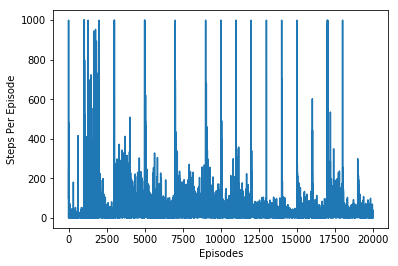

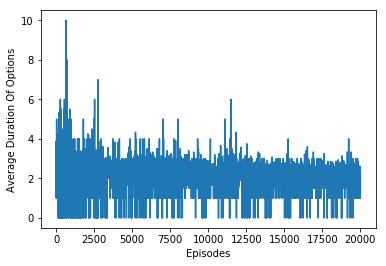

In [13]:
import matplotlib.pyplot as plt

experiment = "experiment11"
save = True

plt.plot(xrange(nepisodes), np.mean(history[:, :, 0], axis=0))
plt.xlabel("Episodes")
plt.ylabel("Steps Per Episode")
if save:
    plt.savefig("plots/{}/learning_curve_nsteps.png".format(experiment))
plt.show()

plt.plot(xrange(nepisodes), np.mean(history[:, :, 1], axis=0))
plt.xlabel("Episodes")
plt.ylabel("Average Duration Of Options")
if save:
    plt.savefig("plots/{}/learning_curve_duration.png".format(experiment))
plt.show()

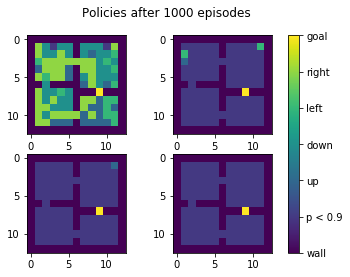

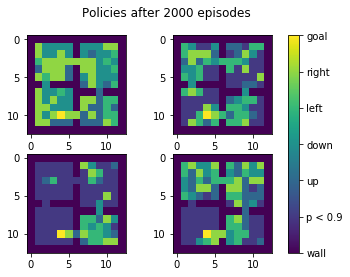

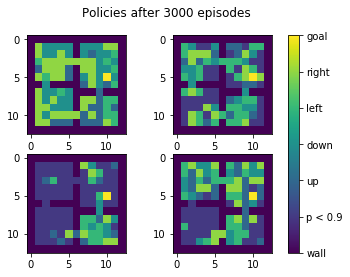

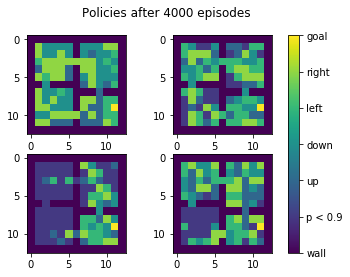

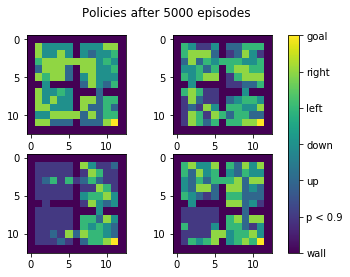

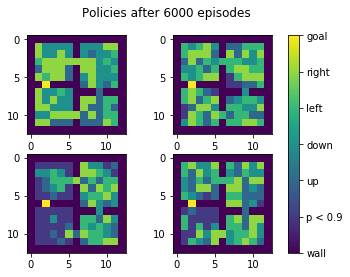

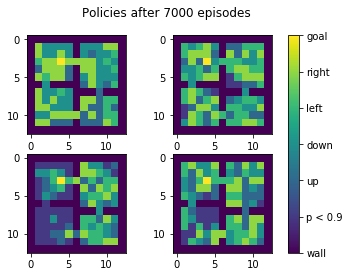

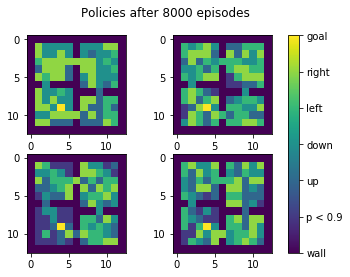

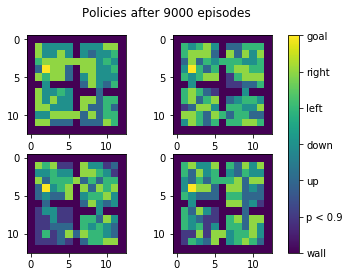

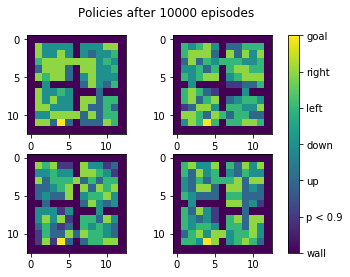

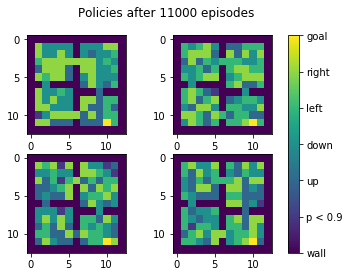

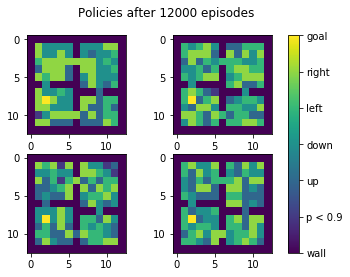

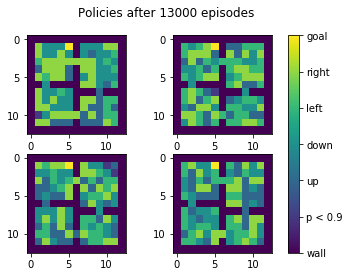

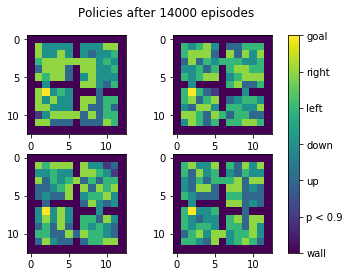

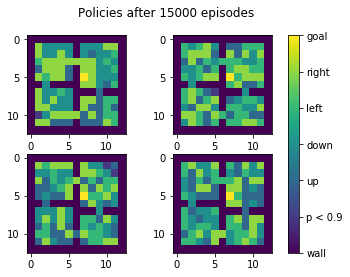

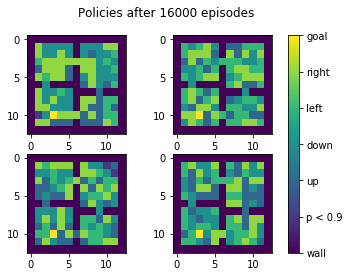

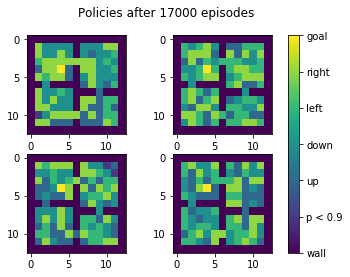

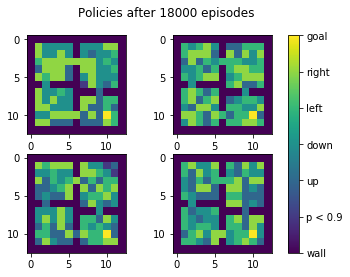

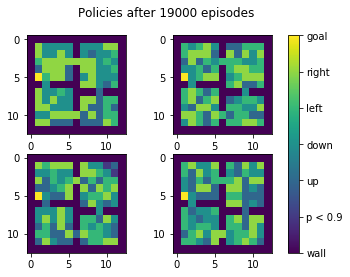

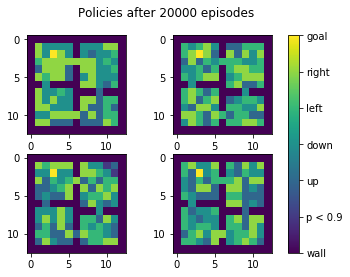

In [14]:
def visualize_policies(policies, goal, title, filename, threshold=0.9):
    fig, axs = plt.subplots(2, 2)
    
    for i in xrange(2):
        for j in xrange(2):
            policy = policies[2 * i + j]
            rooms_map = -2 * env.occupancy
            n_states = policy.weights.shape[0]
            n_actions = 4
            for s in xrange(n_states):
                max_prob = np.max(policy.pmf([s]))
                if max_prob > threshold:
                    rooms_map[env.tocell[s]] = np.argmax(policy.pmf([s]))
                else:
                    rooms_map[env.tocell[s]] = -1
            rooms_map[env.tocell[goal]] = 4
            im = axs[i, j].imshow(rooms_map)

    cbar = fig.colorbar(im, ax=axs.ravel().tolist())
    fig.suptitle(title)
    labels = ['wall', 'p < {}'.format(threshold), 'up', 'down', 'left', 'right', 'goal']
    cbar.ax.set_yticklabels(labels)
    if save:
        plt.savefig("plots/{}/{}.png".format(experiment, filename))
    plt.show()

""" 
policies_before = pickle.load(open("save/policies_before.p", "rb"))
policies_after = pickle.load(open("save/policies_after.p", "rb"))

visualize_policies(policies_before, 62, "Policies before goal change", "policies_before")
visualize_policies(policies_after, env.goal, "Policies after goal change", "policies_after")
"""

for i in xrange(1, change_count + 1):
    policies = pickle.load(open("save/policies_{}.p".format(i), "rb"))
    visualize_policies(policies, goals[i-1], "Policies after {} episodes".format(i * 1000),
                       "policies_{}".format(i))

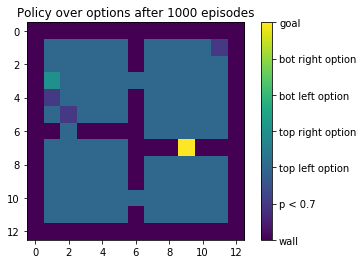

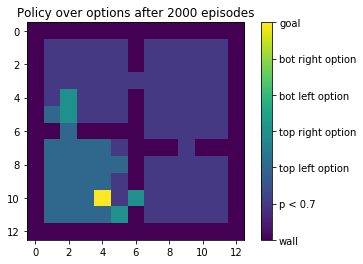

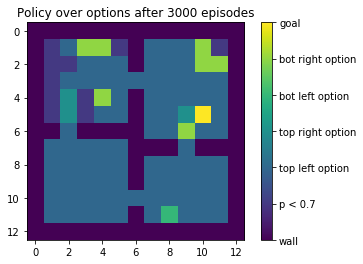

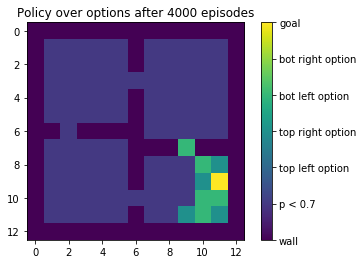

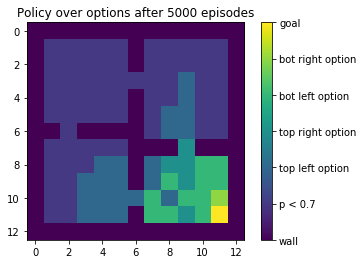

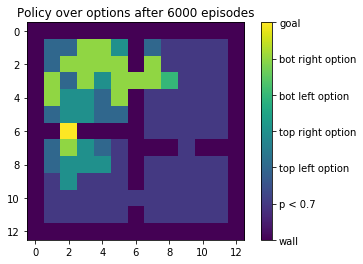

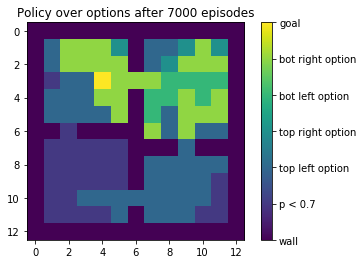

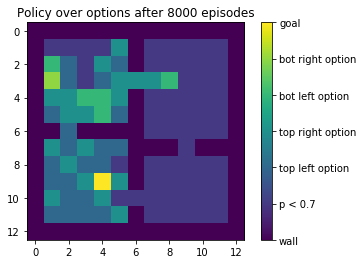

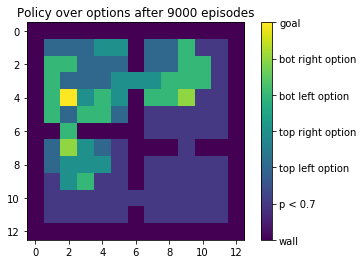

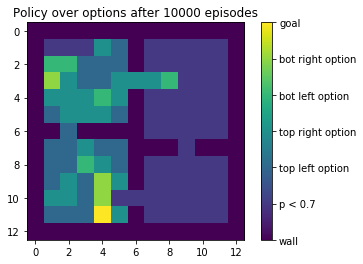

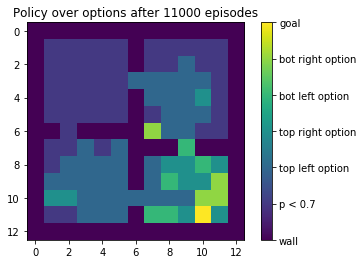

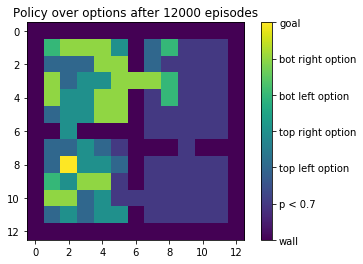

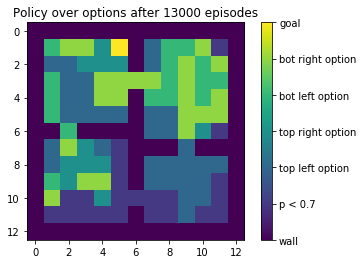

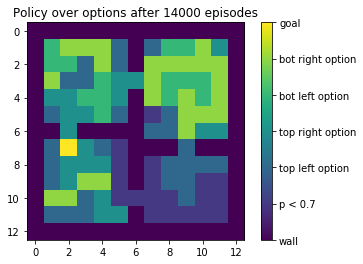

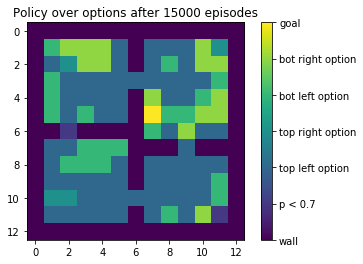

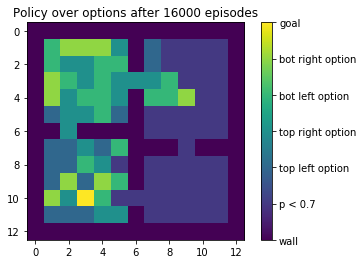

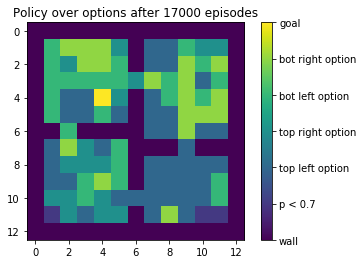

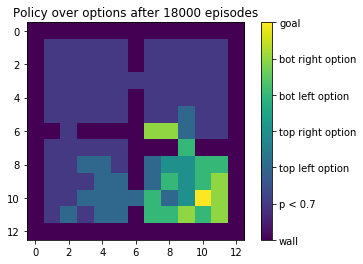

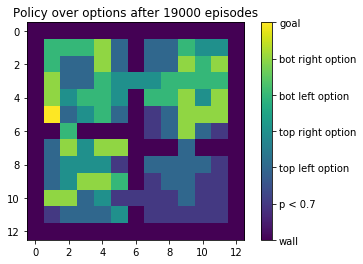

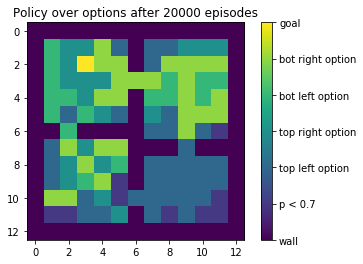

In [15]:
def visualize_policy(policy, goal, title, filename, threshold=0.7):
    rooms_map = -2 * env.occupancy
    n_states = policy.weights.shape[0]
    n_actions = 4
    for s in xrange(n_states):
        max_prob = np.max(policy.value([s]))
        if max_prob > threshold:
            rooms_map[env.tocell[s]] = np.argmax(policy.value([s]))
        else:
            rooms_map[env.tocell[s]] = -1
    rooms_map[env.tocell[goal]] = 4
    
    plt.imshow(rooms_map)
    plt.title(title)
    cbar = plt.colorbar()
    labels = ['wall', 'p < {}'.format(threshold), 'top left option', 
              'top right option', 'bot left option', 
              'bot right option', 'goal']
    cbar.ax.set_yticklabels(labels)
    if save:
        plt.savefig("plots/{}/{}.png".format(experiment, filename))
    plt.show()
    
"""
policy_over_options_before = pickle.load(open("save/mainpolicy_before.p", "rb"))
policy_over_options_after = pickle.load(open("save/mainpolicy_after.p", "rb"))
    
visualize_policy(policy_over_options_before, 62, "Policy over options before goal change", "main_policy_before")
visualize_policy(policy_over_options_after, env.goal, "Policy over options after goal change", "main_policy_after")
"""

for i in xrange(1, change_count + 1):
    policy_over_options = pickle.load(open("save/mainpolicy_{}.p".format(i), "rb"))
    visualize_policy(policy_over_options, goals[i-1], 
                     "Policy over options after {} episodes".format(i * 1000), 
                     "main_policy_{}".format(i))

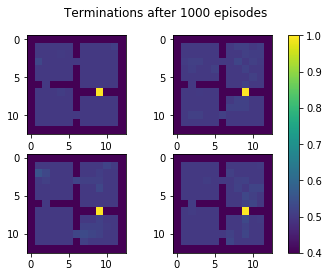

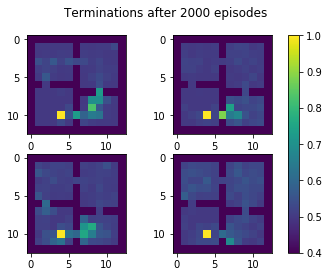

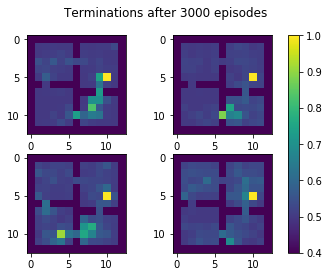

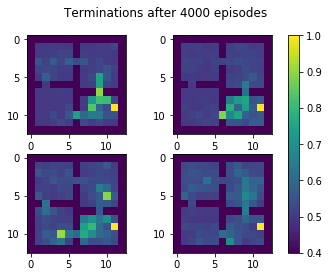

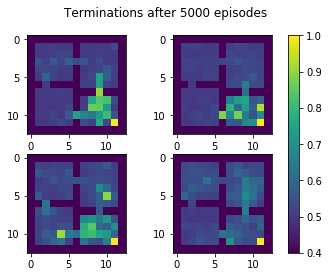

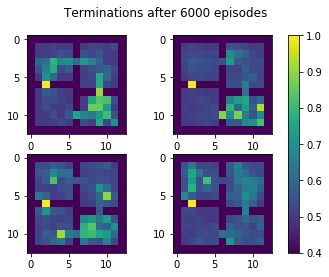

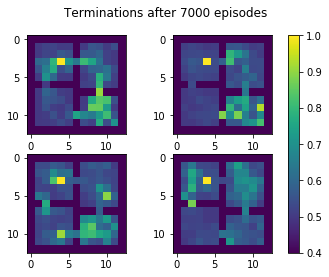

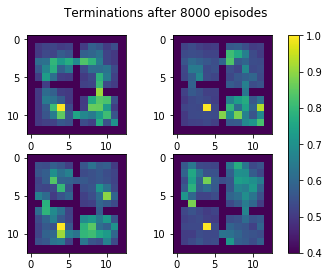

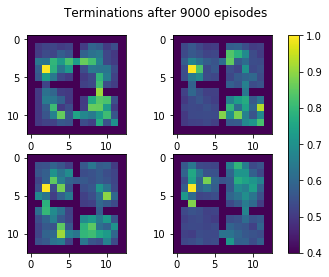

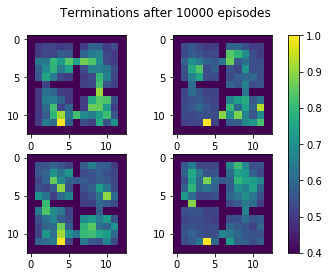

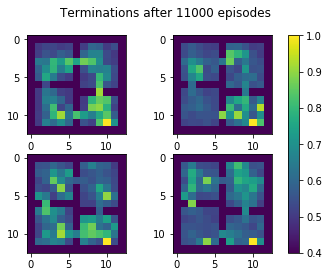

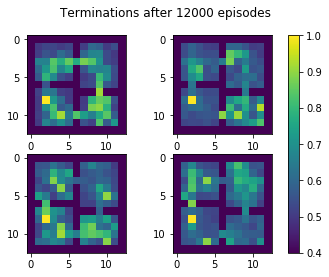

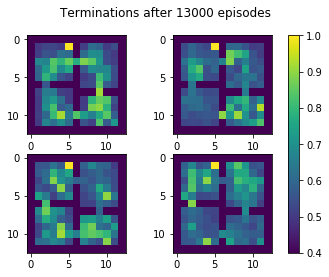

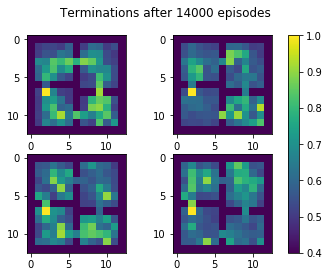

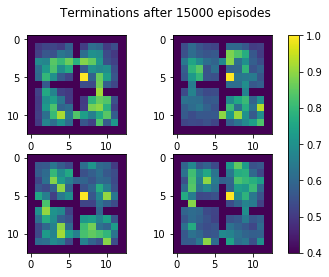

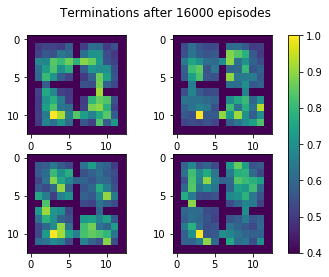

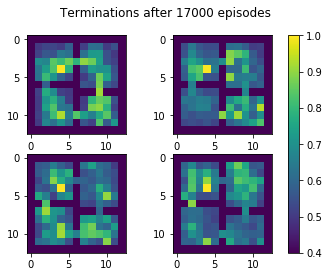

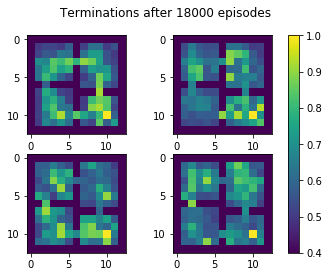

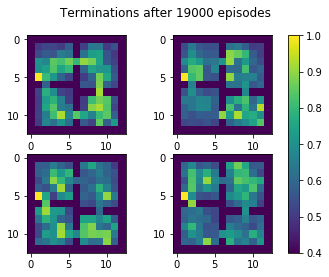

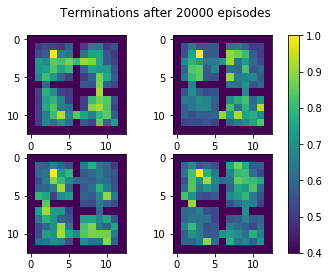

In [16]:
def visualize_terminations(terminations, goal, title, filename):
    fig, axs = plt.subplots(2, 2)
    
    for i in xrange(2):
        for j in xrange(2):
            termination = terminations[i + 2 * j]
            rooms_map = 0.4 * env.occupancy
            n_states = termination.weights.shape[0]
            for s in xrange(n_states):
                rooms_map[env.tocell[s]] = termination.pmf([s])
            rooms_map[env.tocell[goal]] = 1.0
            im = axs[i, j].imshow(rooms_map)
            
    fig.suptitle(title)
    cbar = fig.colorbar(im, ax=axs.ravel().tolist())
    if save:
        plt.savefig("plots/{}/{}.png".format(experiment, filename))
    plt.show()
    
"""
terminations_before = pickle.load(open("save/terminations_before.p", "rb"))
terminations_after = pickle.load(open("save/terminations_after.p", "rb"))

visualize_terminations(terminations_before, 62, "Terminations before goal change", "terminations_before")
visualize_terminations(terminations_after, env.goal, "Terminations after goal change", "terminations_after")
"""

for i in xrange(1, change_count + 1):
    terminations = pickle.load(open("save/terminations_{}.p".format(i), "rb"))
    visualize_terminations(terminations, goals[i-1], 
                           "Terminations after {} episodes".format(i * 1000), 
                           "terminations_{}".format(i))